# AML Challenge 2 Baseline Solution

This notebook is based on the Github [respository](https://github.com/daisukelab/dcase2020_task2_variants). 

We replicate the (Variational Auto-Encoder) VAE method for this AML challenge 2 which is a small scale of the official DCASE challenge [task 2](https://dcase.community/challenge2020/task-unsupervised-detection-of-anomalous-sounds). 

# Required Python Packages

Let's install some python packages used in this notebook.

In [1]:
!pip install torchsummary
!pip install dl-cliche

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 4.3 MB/s eta 0:00:00


To import our own functions, you could upload the .py files in the input folder and do as we do for the "common.py" and "pytorch_common.py" files.

In [2]:
!pip install pytorch-lightning==1.9.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 39.5 MB/s eta 0:00:00
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.0.2
    Uninstalling pytorch-lightning-2.0.2:
      Successfully uninstalled pytorch-lightning-2.0.2


## Choose the model

In [3]:
# model_choice_flag = 0 => Variational Autoencoder
# model_choice_flag = 1 => AnoGAN
model_choice_flag = 1

In [4]:
from shutil import copyfile

# copy our file into the working directory (make sure it has .py suffix)
copyfile(src = "../input/dcase2020-task2-baseline/pytorch_common.py", dst = "../working/pytorch_common.py")
copyfile(src = "../input/dcase2020-task2-baseline/common.py", dst = "../working/common.py")

# import all our functions
import common as com
import pytorch_common
from pytorch_common import *

# public modules
import torch
import torch.nn.functional as F
import torchsummary
import torchvision
import pytorch_lightning as pl
import random
import common as com
import librosa
import os
import glob
import csv
import re
import itertools
import sys
import path
import numpy
import seaborn as sns
from torch import nn
from tqdm import tqdm
from sklearn import metrics
from dlcliche.utils import *
from dlcliche.notebook import *
from dlcliche.utils import (
    sys, random, Path, np, plt, EasyDict,
    ensure_folder, deterministic_everything,
)


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Data Exploration

How many samples included?

How are the raw wave files?

How are the log mel spectrogram of the wave files?

Machine types: ['slider']


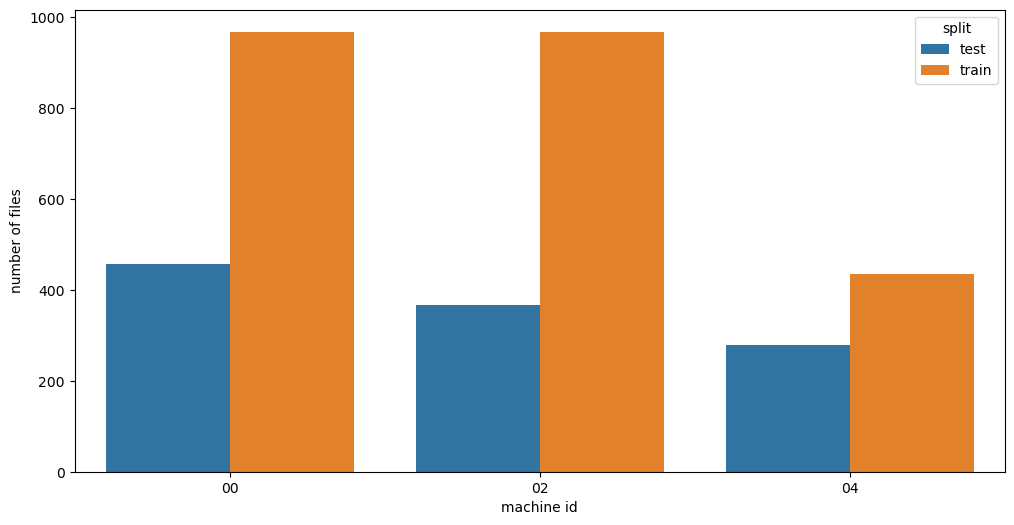

id      00         02         04      
split test train test train test train
file   456   968  367   968  278   434
type   456   968  367   968  278   434

In [5]:
# development dataset
DATA_ROOT=Path("../input/eurecom-aml-2023-challenge-2/dev_data/dev_data")
types = [t.name for t in sorted(DATA_ROOT.glob('*')) if t.is_dir()]
print('Machine types:', types)

df = pd.DataFrame()
df['file'] = sorted(DATA_ROOT.glob('*/*/*.wav'))
df['type'] = df.file.map(lambda f: f.parent.parent.name)
df['split'] = df.file.map(lambda f: f.parent.name)
df['id'] = df.file.map(lambda s: str(s).split('/')[-1].split('_')[-2])

agg = df.groupby(['id', 'split']).agg('count')
fig = plt.figure(figsize=(12.0, 6.0))
g = sns.barplot(x="id", y="file", hue="split", data=agg.reset_index())
plt.xlabel("machine id")
plt.ylabel("number of files")
plt.show()
agg.transpose()

Machine types: ['slider']


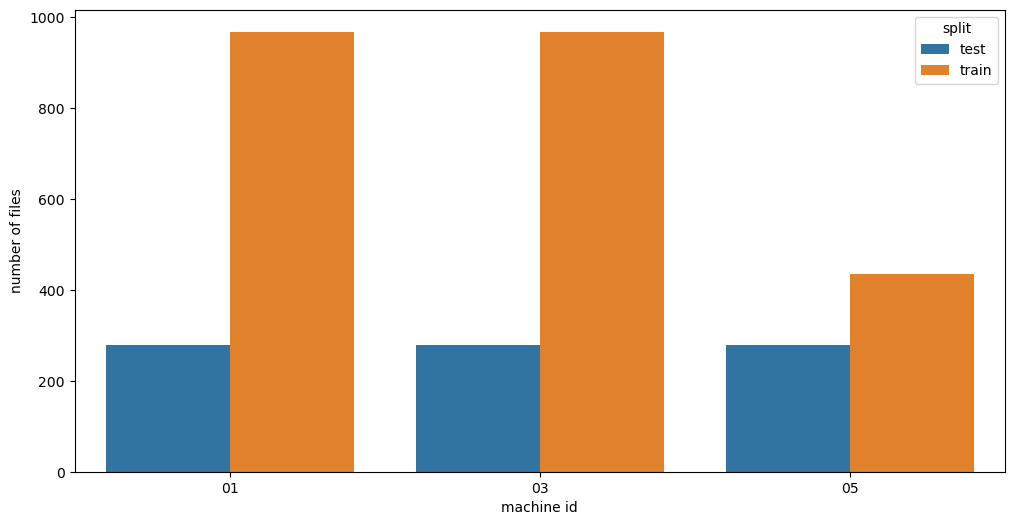

id      01         03         05      
split test train test train test train
file   278   968  278   968  278   434
type   278   968  278   968  278   434

In [6]:
# evaluation dataset
DATA_ROOT=Path("../input/eurecom-aml-2023-challenge-2/eval_data/eval_data")
types = [t.name for t in sorted(DATA_ROOT.glob('*')) if t.is_dir()]
print('Machine types:', types)

df_eval = pd.DataFrame()
df_eval['file'] = sorted(DATA_ROOT.glob('*/*/*.wav'))
df_eval['type'] = df_eval.file.map(lambda f: f.parent.parent.name)
df_eval['split'] = df_eval.file.map(lambda f: f.parent.name)
df_eval['id'] = df_eval.file.map(lambda s: str(s).split('/')[-1].split('_')[-2])

agg = df_eval.groupby(['id', 'split']).agg('count')
fig = plt.figure(figsize=(12.0, 6.0))
g = sns.barplot(x="id", y="file", hue="split", data=agg.reset_index())
plt.xlabel("machine id")
plt.ylabel("number of files")
plt.show()
agg.transpose()

=== Machine type [slider], train set ===


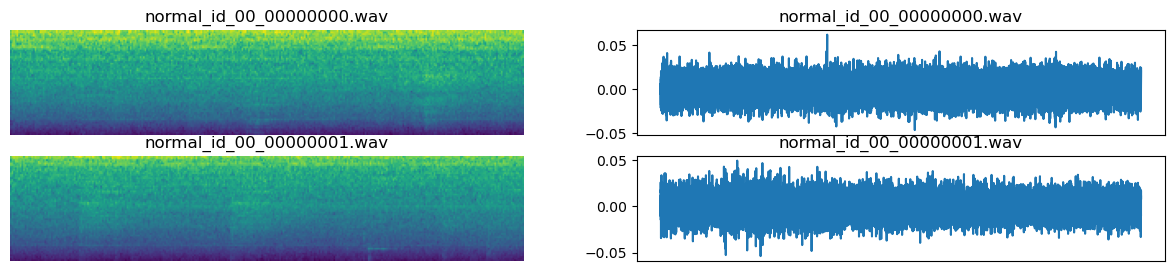

=== Machine type [slider], test set ===


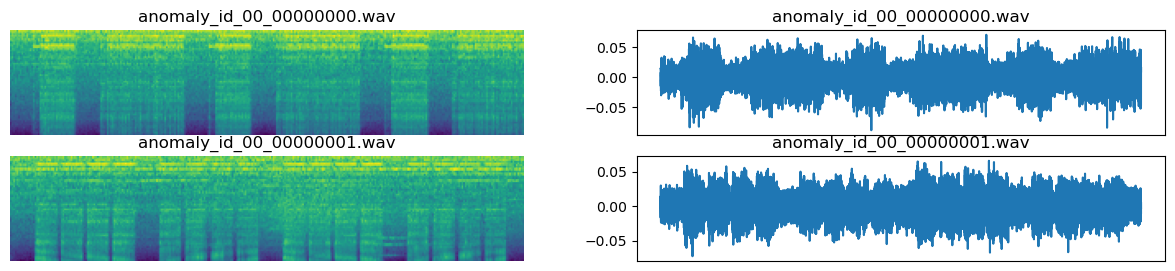

In [7]:
def get_log_mel_spectrogram(filename, n_mels=64,
                        n_fft=1024,
                        hop_length=512,
                        power=2.0):
    wav, sampling_rate = com.file_load(filename)
    mel_spectrogram = librosa.feature.melspectrogram(y=wav,
                                                     sr=sampling_rate,
                                                     n_fft=n_fft,
                                                     hop_length=hop_length,
                                                     n_mels=n_mels,
                                                     power=power)
    log_mel_spectrogram = 20.0 / power * np.log10(mel_spectrogram + sys.float_info.epsilon)
    return log_mel_spectrogram, wav

for t in types:
    for split in ['train', 'test']:
        type_df = df[df['type'] == t][df.split == split].reset_index()
        R = 2
        fig, ax = plt.subplots(R, 2, figsize = (15, 1.5*R))
        print(f'=== Machine type [{t}], {split} set ===')
        for i in range(R * 2):
            file_index = i//2
            file_path = Path(type_df.file[file_index])
            mels, wav = get_log_mel_spectrogram(file_path)
            if i%2==0:
                ax[i//2, i%2].set_title(file_path.name)
                ax[i//2, i%2].imshow(mels)
                ax[i//2, i%2].axis('off')
            else:
                ax[i//2, i%2].set_title(file_path.name)
                ax[i//2, i%2].plot(wav)
                ax[i//2, i%2].get_xaxis().set_ticks([])
        plt.show()

The raw audio file is a time-series data which indicates the amplitude of the sound over time (right figures). 

However, deep learning models rarely take this raw audio directly as input, the common practice is to convert the audio into a spectrogram (left figures). The spectrogram is a concise ‘snapshot’ of an audio wave and since it is an image, it is well suited to being input to CNN-based architectures developed for handling images. If you want to understand the audio spectrogram, this Audio Deep Learning [series](https://towardsdatascience.com/audio-deep-learning-made-simple-part-1-state-of-the-art-techniques-da1d3dff2504) is very useful. In this notebook, we use the spectrogram as input.

# Preprocessing

AnoGAN requires the input to be already in image format. The following blocks of code produce the numpy arrays containing the log mel spectrograms of the input audio files and save them as numpy files.

In [8]:
if model_choice_flag == 1:
    os.makedirs('dev_data')
    os.makedirs('eval_data')

In [9]:
# Dev dataset
if model_choice_flag == 1:
    SAVE_TO = Path("/kaggle/working/dev_data")
    for t in types:
        for split in ['train', 'test']:
            type_df = df[df['type'] == t][df.split == split].reset_index()
            # convert first file, we want to know the shape
            mels, _ = get_log_mel_spectrogram(type_df.file[0])
            # create big bucket to keep all the data
            all_mels = np.zeros((len(type_df), mels.shape[0], mels.shape[1]))
            filename = f'dc2020t2l1-{t}-{split}.npy'
            # convert all files
            print(f'{filename}: making {len(type_df)} log mel spectrogram data as shape {all_mels.shape}')
            all_mels[0, :, :] = mels
            print(type_df.file[0])
            for i, f in enumerate(type_df.file[1:]):
                all_mels[i, :, :], _ = get_log_mel_spectrogram(f)
            np.save(SAVE_TO/filename, all_mels)

dc2020t2l1-slider-train.npy: making 2370 log mel spectrogram data as shape (2370, 64, 313)
../input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/train/normal_id_00_00000000.wav
dc2020t2l1-slider-test.npy: making 1101 log mel spectrogram data as shape (1101, 64, 313)
../input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000000.wav


In [10]:
# Eval dataset
if model_choice_flag == 1:
    SAVE_TO = Path("/kaggle/working/eval_data")
    for t in types:
        for split in ['train', 'test']:
            type_df = df_eval[df_eval['type'] == t][df_eval.split == split].reset_index()
            # convert first file, we want to know the shape
            mels, _ = get_log_mel_spectrogram(type_df.file[0])
            # create big bucket to keep all the data
            all_mels = np.zeros((len(type_df), mels.shape[0], mels.shape[1]))
            filename = f'eval-dc2020t2l1-{t}-{split}.npy'
            # convert all files
            print(f'{filename}: making {len(type_df)} log mel spectrogram data as shape {all_mels.shape}')
            all_mels[0, :, :] = mels
            print(type_df.file[0])
            for i, f in enumerate(type_df.file[1:]):
                all_mels[i, :, :], _ = get_log_mel_spectrogram(f)
            np.save(SAVE_TO/filename, all_mels)

eval-dc2020t2l1-slider-train.npy: making 2370 log mel spectrogram data as shape (2370, 64, 313)
../input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/train/normal_id_01_00000000.wav
eval-dc2020t2l1-slider-test.npy: making 834 log mel spectrogram data as shape (834, 64, 313)
../input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000000.wav


# Network

The implementation of the Variational Auto-Encoder (VAE) model.

In [11]:
class VAE(nn.Module):
    """Mostly borrowed from PyTorch example.
    Thanks to https://github.com/pytorch/examples/blob/master/vae/main.py
    """

    def __init__(self, device, x_dim=640, h_dim=400, z_dim=20):
        super().__init__()
        self.x_dim = x_dim
        #self.fc01 = nn.Conv2d(x_dim,x_dim,kernel_size=3)
        self.fc11 = nn.Linear(x_dim, h_dim)
        self.fc12 = nn.Linear(h_dim, h_dim)
        self.fc21 = nn.Linear(h_dim, z_dim)
        self.fc22 = nn.Linear(h_dim, z_dim)
        self.fc31 = nn.Linear(z_dim, h_dim)
        self.fc32 = nn.Linear(h_dim, h_dim)
        self.fc4 = nn.Linear(h_dim, x_dim)

    def encode(self, x):
        #x= self.fc01(x)
        #x = F.max_pool2d(self.fc10(x))
        x = F.relu(self.fc11(x))
        x = F.relu(self.fc12(x))
        return self.fc21(x), self.fc22(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = F.relu(self.fc31(z))
        h = F.relu(self.fc32(h))
        return torch.sigmoid(self.fc4(h))

    def forward_all(self, x):
        mu, logvar = self.encode(x.view(-1, self.x_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), z, mu, logvar

    def forward(self, x):
        yhat, _, _, _ = self.forward_all(x)
        return yhat


def VAE_loss_function(recon_x, x, mu, logvar, reconst_loss='mse', a_RECONST=1., a_KLD=2, x_dim=640):
    """Loss function for VAE which consists of reconstruction and KL divergence losses.
    Thanks to https://github.com/pytorch/examples/blob/master/vae/main.py

    You can also balance weights for each loss, just to see what if KLD loss is stronger, etc.

    Args:
        reconst_loss: Reconstruction loss calculation: 'mse' or 'bce'
        a_RECONST: Weight for reconstruction loss.
        a_KLD: Weight for KLD loss.
    """

    func = (F.mse_loss if reconst_loss == 'mse'
            else F.binary_cross_entropy if reconst_loss == 'bce'
            else 'Unknown reconst_loss')
    RECONST = func(recon_x, x.view(-1, x_dim), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return RECONST*a_RECONST + KLD*a_KLD


### GAN models for Generator and Discriminator

In [12]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super().__init__()
        self.img_shape = img_shape # (1,64,64)

        self.init_size = img_shape[1] // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, img_shape[0], 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()

        def discriminator_block(in_feat, out_feat, bn=True):
            block = [nn.Conv2d(in_feat, out_feat, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_feat, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(img_shape[0], 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_shape[1] // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        features = self.forward_features(img)
#         out = self.model(img)
#         out = out.view(out.shape[0], -1)
        validity = self.adv_layer(features)
        return validity
    
    def forward_features(self, img):
        features = self.model(img)
        features = features.view(features.shape[0],-1)
        return features


# Parameters

In [14]:
params = {
# inout directory
"dev_directory" : "../input/eurecom-aml-2023-challenge-2/dev_data/dev_data",
"eval_directory" : "../input/eurecom-aml-2023-challenge-2/eval_data/eval_data",
"model_directory": "./model",
"result_directory": "./result",
"result_file": "result.csv",
"max_fpr" : 0.1,
"mode" : True, # mode=True for development dataset, mode=False for evaluation dataset

# preprocessing for mel-spectrogram
"feature": {
"n_mels": 128,
"frames" : 5,
"n_fft": 1024,
"hop_length": 512,
"power": 2.0},

# training
"fit":{
"lr": 0.01,
"b1": 0.9,
"b2": 0.999,
"weight_decay": 0.0,
"epochs" : 100,
"batch_size" : 500,
"shuffle" : True,
"validation_split" : 0.01,
"verbose" : 1},
    
# model architecture
"VAE":{
"x_dim": 640,
"h_dim": 200,
"z_dim": 20}
    
}
params = EasyDict(params)

# create working directory
ensure_folder(params.model_directory)

# test directories
dirs = com.select_dirs(param=params, mode=params.mode)

# fix random seeds
deterministic_everything(2020, pytorch=True)

# PyTorch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2023-05-31 09:56:40,878 - INFO - load_directory <- development


## Parameters for AnoGAN

In [26]:
params_gan = {
# input directory
"dev_directory" : "/kaggle/working/dev_data",
"eval_directory" : "/kaggle/working/eval_data",
"model_directory": "./model",
"result_directory": "./result",
"result_file": "result.csv",
"max_fpr" : 0.1,
"mode" : True, # mode=True for development dataset, mode=False for evaluation dataset

# preprocessing for mel-spectrogram
"feature": {
"n_mels": 64,
"frames" : 5,
"n_fft": 1024,
"hop_length": 512,
"power": 2.0},

# training
"fit":{
"lr": 0.01,
"b1": 0.9,
"b2": 0.999,
"weight_decay": 0.0,
"epochs" : 100,
"batch_size" : 500,
"shuffle" : True,
"validation_split" : 0.1,
"verbose" : 1},
    
# model
"anoGAN":{
"test_epochs": 1000,
"test_lr": 1e-3,
"latent_dim": 100,
"alpha": 0.1}
}

params_gan = EasyDict(params_gan)

# create working directory
ensure_folder(params_gan.model_directory)
    
types = ['slider']

data_files = sorted(Path(params_gan.dev_directory).glob('dc2020t2l1*.npy'))
data = {t:[f for f in data_files if t in str(f)] for t in types}

# fix random seeds
deterministic_everything(2020, pytorch=True)

# PyTorch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training

In [16]:
class Task2Dataset(torch.utils.data.Dataset):
    """PyTorch dataset class for task2. Caching to a file supported.

    Args:
        n_mels, frames, n_fft, hop_length, power, transform: Audio conversion settings.
        normalize: Normalize data value range from [-90, 24] to [0, 1] for VAE, False by default.
        cache_to: Cache filename or None by default, use this for your iterative development.
    """

    def __init__(self, files, n_mels, frames, n_fft, hop_length, power, transform,
                 normalize=False, cache_to=None):
        self.transform = transform
        self.files = files
        self.n_mels, self.frames, self.n_fft = n_mels, frames, n_fft
        self.hop_length, self.power = hop_length, power
        # load cache or convert all the data for the first time
        if cache_to is not None and Path(cache_to).exists():
            com.logger.info(f'Loading cached {Path(cache_to).name}')
            self.X = np.load(cache_to)
        else:
            self.X = com.list_to_vector_array(self.files,
                             n_mels=self.n_mels,
                             frames=self.frames,
                             n_fft=self.n_fft,
                             hop_length=self.hop_length,
                             power=self.power)
            # DEBUG
            print('DEBUG Task2Dataset __init__()')
            print(f'list_to_vector_array() output size: {self.X.shape}')
            
            if cache_to is not None:
                np.save(cache_to, self.X)

        if normalize:
            self.X = normalize_0to1(self.X)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        x = self.X[index]
        x = self.transform(x)
        return x, x


# VAE Training class
class Task2VAELightning(pl.LightningModule):
    """Task2 PyTorch Lightning class, for training only."""

    def __init__(self, device, model, params, files, normalize=False):
        super().__init__()
        self.params = params
        self.normalize = normalize
        self.model = model
        self.mseloss = torch.nn.MSELoss()
        # split data files
        if files is not None:
            n_val = int(params.fit.validation_split * len(files))
            self.val_files = random.sample(files, n_val)
            self.train_files = [f for f in files if f not in self.val_files]

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat, z, mu, logvar = self.model.forward_all(x)
        loss = VAE_loss_function(recon_x=y_hat, x=x, mu=mu, logvar=logvar,
                                 reconst_loss='mse',
                                 a_RECONST=1.,
                                 a_KLD=.01)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        return {'val_loss': self.mseloss(y_hat, y)}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.params.fit.lr,
                                betas=(self.params.fit.b1, self.params.fit.b2),
                                weight_decay=self.params.fit.weight_decay)

    def _get_dl(self, for_what):
        files = self.train_files if for_what == 'train' else self.val_files
        cache_file = f'{self.params.model_directory}/__cache_{str(files[0]).split("/")[-3]}_{for_what}.npy'
        ds = Task2Dataset(files,
                          n_mels=self.params.feature.n_mels,
                          frames=self.params.feature.frames,
                          n_fft=self.params.feature.n_fft,
                          hop_length=self.params.feature.hop_length,
                          power=self.params.feature.power,
                          transform=ToTensor1ch(device=device),
                          normalize=self.normalize,
                          cache_to=cache_file)
        return torch.utils.data.DataLoader(ds, batch_size=self.params.fit.batch_size,
                          shuffle=(self.params.fit.shuffle if for_what == 'train' else False))

    def train_dataloader(self):
        return self._get_dl('train')

    def val_dataloader(self):
        return self._get_dl('val')

In [17]:
# Dataset class used for AnoGAN 
class Task2ImageDataset(torch.utils.data.Dataset):
    """Task 2 dataset to handle samples as 1 channel image.

    Unlike other dataset, set `preprocessed_file` as preprocessed dataset filename.
    For every output, this dataset class crop square image from this original data.

    Number of total samples is `n_sampling` times number of _live data_.
    _Live data_ is all the original data by default, and filtered by splitting functions.

    - For training use, set `random=True`. This will yield randomly cropped square
      image (64x64 for example) from the original sample (64x431 for 10s sample).
    - For validation use, set `random=False`. Image will be cropped from fixed position.

    Augmentation can be flexibly applied to either the output `x` only or `y` only, or both `x` and `y`.
    `aug_x` and `aug_y` control this behavor.

    Data split for training/validation can be done by using:
        `get_index_by_pct()`: generate list of training index.
        `train_split(train_index)`: set live data as original samples listed on `train_index`.
        `val_split(train_index)`: set live data as original samples NOT listed on `train_index`.

    Yields:
        x: square image expected to be used as source.
        y: square image expected to be used as reference for evaluating reconstructed image by training model.
    """

    def __init__(self, preprocessed_file, n_sampling=10, transform=None, augment_tfm=None,
                 normalize=True, random=True, aug_x=True, aug_y=False, debug=False):
        self.n_sampling = n_sampling
        self.transform, self.augment_tfm = transform, augment_tfm
        self.random, self.aug_x, self.aug_y = random, aug_x, aug_y

        self.X = np.load(preprocessed_file)
        if normalize:
            self.X = normalize_0to1(self.X)

        if debug:
            from dlcliche.utils import display
            from dlcliche.math import np_describe
            display(np_describe(self.X[0].cpu().numpy()))

        self.orgX = self.X
  
    def get_index_by_pct(self, split_pct=0.1):
        n = len(self.orgX)
        return random.sample(range(n), k=(n - int(n * split_pct)))

    def train_split(self, train_index):
        self.train_index = train_index
        self.X = self.orgX[train_index]
    
    def val_split(self, train_index):
        n = len(self.orgX)
        self.val_index = [i for i in range(n) if i not in train_index]
        self.X = self.orgX[self.val_index]

    def __len__(self):
        return len(self.X) * self.n_sampling

    def __getitem__(self, index):
        file_index = index // self.n_sampling
        part_index = index % self.n_sampling
        x = self.X[file_index]
        dim, length = x.shape

        # crop square part of sample
        if self.random:
            # random crop
            start = random.randint(0, length - dim)
        else:
            # crop with fixed position
            start = (length // self.n_sampling) * part_index
        start = min(start, length - dim)
        x = x[:, start:start+dim]

        # augmentation transform
        y = x
        if self.augment_tfm is not None:
            tfm_x = self.augment_tfm(x)
            if self.aug_x: x = tfm_x
            if self.aug_y: y = tfm_x

        # transform (convert to tensor here)
        if self.transform is not None:
            x = self.transform(x)
            y = self.transform(y)
        return x, y

In [18]:
class DCGANLightning(pl.LightningModule):

    def __init__(self,
                 device,
                 params,
                 normalize,
                 preprocessed_file,
                 latent_dim: int = 100,
                 lr: float = 0.0002,
                 b1: float = 0.5,
                 b2: float = 0.999,
                 batch_size: int = 64, **kwargs):
        super().__init__()
        self.save_hyperparameters()

        self.params = params
        self.normalize = normalize

        # train & valid datasets
        to_tensor = ToTensor1ch(device=device, image=True)
        self.trn_ds = Task2ImageDataset(preprocessed_file, transform=to_tensor,
                                      normalize=normalize)
        self.val_ds = Task2ImageDataset(preprocessed_file, transform=to_tensor,
                                      normalize=normalize, random=False)
        train_index = self.trn_ds.get_index_by_pct()
        self.trn_ds.train_split(train_index)
        self.val_ds.val_split(train_index)
        
        self.latent_dim = latent_dim
        self.lr = lr
        self.b1 = b1
        self.b2 = b2
        self.batch_size = batch_size
        
        # networks
        img_shape = (1, 64, 64) # TODO Fix? take into account vector_array
        self.generator = Generator(latent_dim=self.latent_dim, img_shape=img_shape)
        self.discriminator = Discriminator(img_shape=img_shape)

        self.validation_z = torch.randn(8, self.latent_dim)

        self.example_input_array = torch.zeros(2, self.latent_dim)

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx, optimizer_idx):
        imgs, _ = batch

        # sample noise
        z = torch.randn(imgs.shape[0], self.latent_dim)
        z = z.type_as(imgs)

        # train generator
        if optimizer_idx == 0:

            # generate images
            self.generated_imgs = self(z)

            # log sampled images
            sample_imgs = self.generated_imgs[:6]
            grid = torchvision.utils.make_grid(sample_imgs)
            self.logger.experiment.add_image('generated_images', grid, 0)

            # ground truth result (ie: all fake)
            # put on GPU because we created this tensor inside training_loop
            valid = torch.ones(imgs.size(0), 1)
            valid = valid.type_as(imgs)

            # adversarial loss is binary cross-entropy
            g_loss = self.adversarial_loss(self.discriminator(self(z)), valid)
            tqdm_dict = {'g_loss': g_loss}
            output = OrderedDict({
                'loss': g_loss,
                'progress_bar': tqdm_dict,
                'log': tqdm_dict
            })
            return output

        # train discriminator
        if optimizer_idx == 1:
            # Measure discriminator's ability to classify real from generated samples

            # how well can it label as real?
            valid = torch.ones(imgs.size(0), 1)
            valid = valid.type_as(imgs)

            real_loss = self.adversarial_loss(self.discriminator(imgs), valid)

            # how well can it label as fake?
            fake = torch.zeros(imgs.size(0), 1)
            fake = fake.type_as(imgs)

            fake_loss = self.adversarial_loss(
                self.discriminator(self(z).detach()), fake)

            # discriminator loss is the average of these
            d_loss = (real_loss + fake_loss) / 2
            tqdm_dict = {'d_loss': d_loss}
            output = OrderedDict({
                'loss': d_loss,
                'progress_bar': tqdm_dict,
                'log': tqdm_dict
            })
            return output

    def configure_optimizers(self):
        lr = self.lr
        b1 = self.b1
        b2 = self.b2

        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
        return [opt_g, opt_d], []
    
    def on_train_epoch_end(self):
        z = self.validation_z.to(self.device)

        # log sampled images
        sample_imgs = self(z)
        grid = torchvision.utils.make_grid(sample_imgs)
        self.logger.experiment.add_image('generated_images', grid, self.current_epoch)
        
        # save the models
        torch.save(self.discriminator.state_dict(), '/kaggle/working/model/D.pth')
        torch.save(self.generator.state_dict(), '/kaggle/working/model/G.pth')
        
    def _get_dl(self, for_what):
        ds = self.trn_ds if for_what == 'train' else self.val_ds
        return torch.utils.data.DataLoader(ds, batch_size=self.params.fit.batch_size,
                          shuffle=(self.params.fit.shuffle if for_what == 'train' else False))
    
    def train_dataloader(self):
        return self._get_dl('train')

    def val_dataloader(self):
        return self._get_dl('val')

In [19]:
for target_dir in dirs: 
    files = com.file_list_generator(target_dir)

def n_machine(file):
    return os.path.normpath(file).split(os.path.sep)[-1].split("_")[2]


def c_machine(files):
    C = [0,0,0,0,0]
    for file in files:
        C[int(n_machine(file))]+=1
    del C[1]
    del C[2]
    
    return(C)

def machines(files):
    L0, L2, L4 = [], [], []
    for file in files: 
        n = int(n_machine(file))
        if n == 0:
            L0.append(file)
        elif n == 2:
            L2.append(file)
        else:
            L4.append(file)
    return L0, L2, L4

def downsize(files,n_min):
    L0, L2, L4 = machines(files)
    L0 = list(numpy.random.choice(L0, n_min))
    L2 = list(numpy.random.choice(L2, n_min))
    L4 = list(numpy.random.choice(L4, n_min))
    return L0+L2+L4

L0, L2, L4 = machines(files)
files2 = L0+L2+L4

2023-05-31 09:56:41,523 - INFO - target_dir : dev_data/slider
2023-05-31 09:56:41,536 - INFO - # of training samples : 2370


In [20]:
# train models, AE
if model_choice_flag == 0:
    def train():
        for target_dir in dirs:
            target = str(target_dir).split('/')[-1]
            print(f'==== Start training [{target}] with {torch.cuda.device_count()} GPU(s). ====')

            files = files2

            model = VAE(device, x_dim=params.VAE.x_dim, h_dim=params.VAE.h_dim, z_dim=params.VAE.z_dim).to(device)
            summary(device, model)
            task2 = Task2VAELightning(device, model, params, files, normalize=True)
            trainer = pl.Trainer(max_epochs=params.fit.epochs,
                                 gpus=torch.cuda.device_count())
            trainer.fit(task2)

            model_file = f'{params.model_directory}/model_{target}.pth'
            torch.save(task2.model.state_dict(), model_file)
            print(f'saved {model_file}.\n')
            torch.cuda.empty_cache()

    train()

In [21]:
import gc
torch.cuda.empty_cache()
gc.collect()

136093

In [22]:
# training, AnoGAN
if model_choice_flag == 1:
    def train_anogan():
        for target_dir in dirs:
            target = str(target_dir).split('/')[-1]
            print(f'==== Start training [{target}] with {torch.cuda.device_count()} GPU(s). ====')

            files = files2

            #summary(device, model)
            task2 = DCGANLightning(device, params, normalize=True, preprocessed_file=data[target][1])
            trainer = pl.Trainer(max_epochs=params.fit.epochs,
                                 gpus=torch.cuda.device_count())
            trainer.fit(task2)

            torch.cuda.empty_cache()

    train_anogan()

==== Start training [slider] with 1 GPU(s). ====


/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

# Testing on Development dataset

In [23]:
if model_choice_flag == 0:
    def test():
        # make output result directory
        os.makedirs(params.result_directory, exist_ok=True)

        # load base directory
        dirs = com.select_dirs(param=params, mode=params.mode)

        # initialize lines in csv for AUC and pAUC
        csv_lines = []

        # PyTorch version specific...
        to_tensor = pytorch_common.ToTensor1ch()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # loop of the base directory
        for idx, target_dir in enumerate(dirs):
            print("\n===========================")
            print("[{idx}/{total}] {dirname}".format(dirname=target_dir, idx=idx+1, total=len(dirs)))
            machine_type = os.path.split(target_dir)[1]

            print("============== MODEL LOAD ==============")
            # set model path
            model_file = "{model}/model_{machine_type}.pth".format(model=params.model_directory,
                                                                   machine_type=machine_type)

            # load model file
            if not os.path.exists(model_file):
                com.logger.error("{} model not found ".format(machine_type))
                sys.exit(-1)
            com.logger.info("loading model: {}".format(model_file))
            model = VAE(device, x_dim=params.VAE.x_dim, h_dim=params.VAE.h_dim, z_dim=params.VAE.z_dim).to(device)
            pytorch_common.load_weights(model, model_file)
            pytorch_common.summary(device, model)
            model.eval()

            if params.mode:
                # results by type
                csv_lines.append([machine_type])
                csv_lines.append(["id", "AUC", "pAUC"])
                performance = []

            machine_id_list = get_machine_id_list_for_test(target_dir)

            for id_str in machine_id_list:
                # load test file
                test_files, y_true = test_file_list_generator(target_dir, id_str, mode=params.mode)

                # setup anomaly score file path
                anomaly_score_csv = "{result}/anomaly_score_{machine_type}_{id_str}.csv".format(
                                                                                         result=params.result_directory,
                                                                                         machine_type=machine_type,
                                                                                         id_str=id_str)
                anomaly_score_list = []

                print("\n============== BEGIN TEST FOR A MACHINE ID ==============")
                y_pred = [0. for k in test_files]
                for file_idx, file_path in tqdm(enumerate(test_files), total=len(test_files)):
                    try:
                        data = com.file_to_vector_array(file_path,
                                                        n_mels=params.feature.n_mels,
                                                        frames=params.feature.frames,
                                                        n_fft=params.feature.n_fft,
                                                        hop_length=params.feature.hop_length,
                                                        power=params.feature.power)
                        data = pytorch_common.normalize_0to1(data)
                        with torch.no_grad():
                            yhat = model(to_tensor(data)).cpu().detach().numpy().reshape(data.shape)
                            errors = numpy.mean(numpy.square(data - yhat), axis=1)
                        y_pred[file_idx] = numpy.mean(errors)
                        anomaly_score_list.append([os.path.basename(file_path), y_pred[file_idx]])
                    except:
                        com.logger.error("file broken!!: {}".format(file_path))
                        sys.exit(-1)

                # save anomaly score
                save_csv(save_file_path=anomaly_score_csv, save_data=anomaly_score_list)
                com.logger.info("anomaly score result ->  {}".format(anomaly_score_csv))

                if params.mode:
                    # append AUC and pAUC to lists
                    auc = metrics.roc_auc_score(y_true, y_pred)
                    p_auc = metrics.roc_auc_score(y_true, y_pred, max_fpr=params.max_fpr)
                    csv_lines.append([id_str.split("_", 1)[1], auc, p_auc])
                    performance.append([auc, p_auc])
                    com.logger.info("AUC : {}".format(auc))
                    com.logger.info("pAUC : {}".format(p_auc))

                print("\n============ END OF TEST FOR A MACHINE ID ============")

            if params.mode:
                # calculate averages for AUCs and pAUCs
                averaged_performance = numpy.mean(numpy.array(performance, dtype=float), axis=0)
                csv_lines.append(["Average"] + list(averaged_performance))
                csv_lines.append([])

        if params.mode:
            # output results
            result_path = "{result}/{file_name}".format(result=params.result_directory, file_name=params.result_file)
            com.logger.info("AUC and pAUC results -> {}".format(result_path))
            save_csv(save_file_path=result_path, save_data=csv_lines)

    test()

In [24]:
def file_to_vector_array_2d(file_name,
                         n_mels=64,
                         steps=20,
                         n_fft=1024,
                         hop_length=512,
                         power=2.0):
    """
    convert file_name to a 2d vector array.
    file_name : str
        target .wav file
    return : np.array( np.array( float ) )
        vector array
        * dataset.shape = (dataset_size, feature_vector_length)
    """
    # 02 generate melspectrogram using librosa
    y, sr = com.file_load(file_name)
    mel_spectrogram = librosa.feature.melspectrogram(y=y,
                                                     sr=sr,
                                                     n_fft=n_fft,
                                                     hop_length=hop_length,
                                                     n_mels=n_mels,
                                                     power=power)

    # 03 convert melspectrogram to log mel energy
    log_mel_spectrogram = 20.0 / power * np.log10(mel_spectrogram + sys.float_info.epsilon)

    # 04 calculate total vector size
    vector_array_size = (log_mel_spectrogram.shape[1] - n_mels + 1) // steps

    # 06 generate feature vectors by concatenating multiframes
    vector_array = np.zeros((vector_array_size, n_mels, n_mels))
    for t in range(vector_array_size):
        vector_array[t] = log_mel_spectrogram[:, t*steps:t*steps+n_mels]

    return vector_array

In [25]:
# Function that evaluates the Anomaly score of a sample, which corre
def Anomaly_Score(x, G_z, D, alpha=0.1):
    # evaluate the residual loss
    residual_loss = torch.abs(x - G_z)
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)
    residual_loss = torch.sum(residual_loss, dim=1)
    
    # evaluate the discrimination loss
    x_feature = D.forward_features(x)
    G_z_feature = D.forward_features(G_z)
    discrimination_loss = torch.abs(x_feature - G_z_feature)
    discrimination_loss = discrimination_loss.view(discrimination_loss.size()[0], -1)
    discrimination_loss = torch.sum(discrimination_loss, dim=1)
    
    anom_score = (1 - alpha) * residual_loss + alpha * discrimination_loss
    anom_score = anom_score.mean() # avg over the 0th dimension TODO REMOVE?
    
    return anom_score

In [43]:
if model_choice_flag == 1:
    def test_gan():
        # make output result directory
        os.makedirs(params.result_directory, exist_ok=True)

        # load base directory
        dirs = com.select_dirs(param=params, mode=params_gan.mode)

        # initialize lines in csv for AUC and pAUC
        csv_lines = []

        # PyTorch version specific...
        to_tensor = pytorch_common.ToTensor1ch(image=True)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # loop of the base directory
        for idx, target_dir in enumerate(dirs):
            print("\n===========================")
            print("[{idx}/{total}] {dirname}".format(dirname=target_dir, idx=idx+1, total=len(dirs)))
            machine_type = os.path.split(target_dir)[1]

            print("============== MODEL LOAD ==============")
            # model paths
            model_G_file = "{model}/G.pth".format(model=params_gan.model_directory)
            model_D_file = "{model}/D.pth".format(model=params_gan.model_directory)

            # load model files
            if (not os.path.exists(model_G_file)) or (not os.path.exists(model_D_file)):
                com.logger.error("model not found.")
                sys.exit(-1)
            com.logger.info("loading model: {}".format(model_G_file))
            com.logger.info("loading model: {}".format(model_D_file))
            
            img_shape = (1, 64, 64) # TODO FIX
            G = Generator(latent_dim=params_gan.anoGAN.latent_dim, img_shape=img_shape).to(device)
            G.load_state_dict(torch.load(model_G_file))
            G.eval()
            D = Discriminator(img_shape).to(device)
            D.load_state_dict(torch.load(model_D_file))
            D.eval()
            for p in D.parameters():
                p.requires_grad = False
            for p in D.parameters():
                p.requires_grad = False

            if params_gan.mode:
                # results by type
                csv_lines.append([machine_type])
                csv_lines.append(["id", "AUC", "pAUC"])
                performance = []

            machine_id_list = get_machine_id_list_for_test(target_dir)

            for id_str in machine_id_list:
                # load test file
                test_files, y_true = test_file_list_generator(target_dir, id_str, mode=params_gan.mode)

                # setup anomaly score file path
                anomaly_score_csv = "{result}/anomaly_score_{machine_type}_{id_str}.csv".format(
                                                                                         result=params_gan.result_directory,
                                                                                         machine_type=machine_type,
                                                                                         id_str=id_str)
                anomaly_score_list = []

                print("\n============== BEGIN TEST FOR A MACHINE ID ==============")
                y_pred = [0. for k in test_files]
                for file_idx, file_path in tqdm(enumerate(test_files), total=len(test_files)):
                    # DEBUG
                    print("DEBUG")
                    print(f'file path: {file_path}')
                    try:
                        data_ = file_to_vector_array_2d(file_path,
                                                        n_mels=params_gan.feature.n_mels,
                                                        n_fft=params_gan.feature.n_fft,
                                                        hop_length=params_gan.feature.hop_length,
                                                        power=params_gan.feature.power)
                        data_ = pytorch_common.normalize_0to1(data_)
#                       with torch.no_grad():
                        ## FIX
                        data_ = torch.from_numpy(data_).float().to(device) # convert to tensor
                        data_ = data_.unsqueeze(1) # shape should be of format (batch_size,channels,w,h)
                        # DEBUG
                        print("DEBUG")
                        print(f"data_.shape: {data_.shape}")

                        z = torch.randn(data_.shape[0], params_gan.anoGAN.latent_dim).to(device)
                        z.requires_grad = True
                        z_optim = torch.optim.Adam([z], lr=params_gan.anoGAN.test_lr)
                        for epoch in range(params_gan.anoGAN.test_epochs):
                            G_z = G(z)
                            loss = Anomaly_Score(data_, G_z, D, alpha=params_gan.anoGAN.alpha)
                            z_optim.zero_grad()
                            loss.backward()
                            z_optim.step()
                        ##
                        # the loss obtained at the last iteration of the mapping process corresponds
                        # to the anomaly score for the test sample
                        print(f'DEBUG | anomaly score for the current sample: {loss}')
                        y_pred[file_idx] = loss.cpu().detach().numpy()
                        anomaly_score_list.append([os.path.basename(file_path), y_pred[file_idx]])
                        torch.cuda.empty_cache()
                    except:
                        com.logger.error("file broken!!: {}".format(file_path))
                        sys.exit(-1)

                # save anomaly score
                save_csv(save_file_path=anomaly_score_csv, save_data=anomaly_score_list)
                com.logger.info("anomaly score result ->  {}".format(anomaly_score_csv))

                if params_gan.mode:
                    # append AUC and pAUC to lists
                    auc = metrics.roc_auc_score(y_true, y_pred)
                    p_auc = metrics.roc_auc_score(y_true, y_pred, max_fpr=params_gan.max_fpr)
                    csv_lines.append([id_str.split("_", 1)[1], auc, p_auc])
                    performance.append([auc, p_auc])
                    com.logger.info("AUC : {}".format(auc))
                    com.logger.info("pAUC : {}".format(p_auc))

                print("\n============ END OF TEST FOR A MACHINE ID ============")

            if params_gan.mode:
                # calculate averages for AUCs and pAUCs
                averaged_performance = numpy.mean(numpy.array(performance, dtype=float), axis=0)
                csv_lines.append(["Average"] + list(averaged_performance))
                csv_lines.append([])

        if params_gan.mode:
            # output results
            result_path = "{result}/{file_name}".format(result=params.result_directory, file_name=params.result_file)
            com.logger.info("AUC and pAUC results -> {}".format(result_path))
            save_csv(save_file_path=result_path, save_data=csv_lines)

    test_gan()

2023-05-31 12:28:51,715 - INFO - load_directory <- development
2023-05-31 12:28:51,723 - INFO - loading model: ./model/G.pth
2023-05-31 12:28:51,724 - INFO - loading model: ./model/D.pth
2023-05-31 12:28:51,787 - INFO - target_dir : /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider_id_00
2023-05-31 12:28:51,793 - INFO - test_file  num : 456



[1/1] /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider
============== MODEL LOAD ==============


============== BEGIN TEST FOR A MACHINE ID ==============


  0%|          | 0/456 [00:00<?, ?it/s]

DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000000.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  0%|          | 1/456 [00:05<42:03,  5.55s/it]

DEBUG | anomaly score for the current sample: 84.2618637084961
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000001.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  0%|          | 2/456 [00:11<41:54,  5.54s/it]

DEBUG | anomaly score for the current sample: 102.36627197265625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000002.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  1%|          | 3/456 [00:16<41:48,  5.54s/it]

DEBUG | anomaly score for the current sample: 137.30775451660156
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000003.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  1%|          | 4/456 [00:22<41:41,  5.53s/it]

DEBUG | anomaly score for the current sample: 92.1613998413086
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000004.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  1%|          | 5/456 [00:27<41:35,  5.53s/it]

DEBUG | anomaly score for the current sample: 88.7130126953125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000005.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  1%|▏         | 6/456 [00:33<41:31,  5.54s/it]

DEBUG | anomaly score for the current sample: 145.87181091308594
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000006.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  2%|▏         | 7/456 [00:38<41:25,  5.54s/it]

DEBUG | anomaly score for the current sample: 78.0576400756836
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000007.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  2%|▏         | 8/456 [00:44<41:21,  5.54s/it]

DEBUG | anomaly score for the current sample: 77.17243957519531
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000008.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  2%|▏         | 9/456 [00:49<41:11,  5.53s/it]

DEBUG | anomaly score for the current sample: 113.90916442871094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000009.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  2%|▏         | 10/456 [00:55<41:06,  5.53s/it]

DEBUG | anomaly score for the current sample: 95.65013122558594
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000010.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  2%|▏         | 11/456 [01:00<41:01,  5.53s/it]

DEBUG | anomaly score for the current sample: 98.33553314208984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000011.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  3%|▎         | 12/456 [01:06<40:57,  5.54s/it]

DEBUG | anomaly score for the current sample: 95.25791931152344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000012.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  3%|▎         | 13/456 [01:11<40:51,  5.53s/it]

DEBUG | anomaly score for the current sample: 96.47723388671875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000013.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  3%|▎         | 14/456 [01:17<40:45,  5.53s/it]

DEBUG | anomaly score for the current sample: 100.2606430053711
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000014.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  3%|▎         | 15/456 [01:23<40:39,  5.53s/it]

DEBUG | anomaly score for the current sample: 81.48344421386719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000015.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  4%|▎         | 16/456 [01:28<40:34,  5.53s/it]

DEBUG | anomaly score for the current sample: 77.59652709960938
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000016.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  4%|▎         | 17/456 [01:34<40:28,  5.53s/it]

DEBUG | anomaly score for the current sample: 80.16903686523438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000017.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  4%|▍         | 18/456 [01:39<40:23,  5.53s/it]

DEBUG | anomaly score for the current sample: 78.28233337402344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000018.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  4%|▍         | 19/456 [01:45<40:17,  5.53s/it]

DEBUG | anomaly score for the current sample: 91.98907470703125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000019.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  4%|▍         | 20/456 [01:50<40:20,  5.55s/it]

DEBUG | anomaly score for the current sample: 104.32354736328125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000020.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  5%|▍         | 21/456 [01:56<40:12,  5.54s/it]

DEBUG | anomaly score for the current sample: 113.26912689208984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000021.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  5%|▍         | 22/456 [02:01<40:04,  5.54s/it]

DEBUG | anomaly score for the current sample: 88.02864837646484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000022.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  5%|▌         | 23/456 [02:07<40:01,  5.55s/it]

DEBUG | anomaly score for the current sample: 77.80612182617188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000023.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  5%|▌         | 24/456 [02:12<39:53,  5.54s/it]

DEBUG | anomaly score for the current sample: 109.94189453125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000024.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  5%|▌         | 25/456 [02:18<39:46,  5.54s/it]

DEBUG | anomaly score for the current sample: 151.22042846679688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000025.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  6%|▌         | 26/456 [02:23<39:44,  5.55s/it]

DEBUG | anomaly score for the current sample: 95.15850830078125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000026.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  6%|▌         | 27/456 [02:29<39:37,  5.54s/it]

DEBUG | anomaly score for the current sample: 78.75856018066406
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000027.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  6%|▌         | 28/456 [02:35<39:31,  5.54s/it]

DEBUG | anomaly score for the current sample: 107.22087097167969
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000028.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  6%|▋         | 29/456 [02:40<39:24,  5.54s/it]

DEBUG | anomaly score for the current sample: 95.86444091796875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000029.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  7%|▋         | 30/456 [02:46<39:19,  5.54s/it]

DEBUG | anomaly score for the current sample: 123.69698333740234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000030.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  7%|▋         | 31/456 [02:51<39:12,  5.54s/it]

DEBUG | anomaly score for the current sample: 83.34306335449219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000031.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  7%|▋         | 32/456 [02:57<39:07,  5.54s/it]

DEBUG | anomaly score for the current sample: 114.79296875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000032.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  7%|▋         | 33/456 [03:02<39:01,  5.54s/it]

DEBUG | anomaly score for the current sample: 78.76011657714844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000033.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  7%|▋         | 34/456 [03:08<38:56,  5.54s/it]

DEBUG | anomaly score for the current sample: 125.51277923583984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000034.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  8%|▊         | 35/456 [03:13<38:50,  5.54s/it]

DEBUG | anomaly score for the current sample: 80.37596893310547
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000035.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  8%|▊         | 36/456 [03:19<38:45,  5.54s/it]

DEBUG | anomaly score for the current sample: 101.9488754272461
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000036.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  8%|▊         | 37/456 [03:24<38:39,  5.54s/it]

DEBUG | anomaly score for the current sample: 89.32762145996094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000037.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  8%|▊         | 38/456 [03:30<38:33,  5.54s/it]

DEBUG | anomaly score for the current sample: 78.92928314208984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000038.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  9%|▊         | 39/456 [03:35<38:28,  5.54s/it]

DEBUG | anomaly score for the current sample: 77.5560531616211
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000039.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  9%|▉         | 40/456 [03:41<38:22,  5.53s/it]

DEBUG | anomaly score for the current sample: 88.42720794677734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000040.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  9%|▉         | 41/456 [03:47<38:16,  5.53s/it]

DEBUG | anomaly score for the current sample: 103.87379455566406
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000041.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  9%|▉         | 42/456 [03:52<38:10,  5.53s/it]

DEBUG | anomaly score for the current sample: 132.72607421875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000042.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  9%|▉         | 43/456 [03:58<38:04,  5.53s/it]

DEBUG | anomaly score for the current sample: 80.81490325927734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000043.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 10%|▉         | 44/456 [04:03<37:59,  5.53s/it]

DEBUG | anomaly score for the current sample: 92.3609848022461
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000044.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 10%|▉         | 45/456 [04:09<37:54,  5.53s/it]

DEBUG | anomaly score for the current sample: 113.74455261230469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000045.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 10%|█         | 46/456 [04:14<37:50,  5.54s/it]

DEBUG | anomaly score for the current sample: 92.69065856933594
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000046.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 10%|█         | 47/456 [04:20<37:44,  5.54s/it]

DEBUG | anomaly score for the current sample: 91.90396118164062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000047.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 11%|█         | 48/456 [04:25<37:38,  5.54s/it]

DEBUG | anomaly score for the current sample: 77.71298217773438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000048.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 11%|█         | 49/456 [04:31<37:37,  5.55s/it]

DEBUG | anomaly score for the current sample: 100.48524475097656
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000049.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 11%|█         | 50/456 [04:36<37:29,  5.54s/it]

DEBUG | anomaly score for the current sample: 76.74852752685547
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000050.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 11%|█         | 51/456 [04:42<37:23,  5.54s/it]

DEBUG | anomaly score for the current sample: 104.74703216552734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000051.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 11%|█▏        | 52/456 [04:47<37:17,  5.54s/it]

DEBUG | anomaly score for the current sample: 94.2556381225586
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000052.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 12%|█▏        | 53/456 [04:53<37:11,  5.54s/it]

DEBUG | anomaly score for the current sample: 78.26405334472656
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000053.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 12%|█▏        | 54/456 [04:58<37:05,  5.54s/it]

DEBUG | anomaly score for the current sample: 130.2347412109375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000054.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 12%|█▏        | 55/456 [05:04<36:59,  5.53s/it]

DEBUG | anomaly score for the current sample: 79.97766876220703
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000055.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 12%|█▏        | 56/456 [05:10<36:53,  5.53s/it]

DEBUG | anomaly score for the current sample: 76.5180892944336
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000056.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 12%|█▎        | 57/456 [05:15<36:47,  5.53s/it]

DEBUG | anomaly score for the current sample: 83.26283264160156
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000057.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 13%|█▎        | 58/456 [05:21<36:41,  5.53s/it]

DEBUG | anomaly score for the current sample: 101.36177825927734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000058.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 13%|█▎        | 59/456 [05:26<36:36,  5.53s/it]

DEBUG | anomaly score for the current sample: 113.8133773803711
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000059.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 13%|█▎        | 60/456 [05:32<36:30,  5.53s/it]

DEBUG | anomaly score for the current sample: 101.35459899902344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000060.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 13%|█▎        | 61/456 [05:37<36:25,  5.53s/it]

DEBUG | anomaly score for the current sample: 117.1454086303711
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000061.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 14%|█▎        | 62/456 [05:43<36:19,  5.53s/it]

DEBUG | anomaly score for the current sample: 98.39530944824219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000062.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 14%|█▍        | 63/456 [05:48<36:14,  5.53s/it]

DEBUG | anomaly score for the current sample: 93.94572448730469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000063.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 14%|█▍        | 64/456 [05:54<36:08,  5.53s/it]

DEBUG | anomaly score for the current sample: 78.32681274414062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000064.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 14%|█▍        | 65/456 [05:59<36:02,  5.53s/it]

DEBUG | anomaly score for the current sample: 76.2385482788086
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000065.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 14%|█▍        | 66/456 [06:05<36:06,  5.55s/it]

DEBUG | anomaly score for the current sample: 78.21233367919922
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000066.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 15%|█▍        | 67/456 [06:10<35:59,  5.55s/it]

DEBUG | anomaly score for the current sample: 78.15586853027344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000067.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 15%|█▍        | 68/456 [06:16<35:51,  5.54s/it]

DEBUG | anomaly score for the current sample: 94.16380310058594
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000068.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 15%|█▌        | 69/456 [06:22<35:44,  5.54s/it]

DEBUG | anomaly score for the current sample: 78.50856018066406
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000069.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 15%|█▌        | 70/456 [06:27<35:37,  5.54s/it]

DEBUG | anomaly score for the current sample: 108.3387680053711
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000070.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 16%|█▌        | 71/456 [06:33<35:31,  5.54s/it]

DEBUG | anomaly score for the current sample: 82.64632415771484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000071.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 16%|█▌        | 72/456 [06:38<35:32,  5.55s/it]

DEBUG | anomaly score for the current sample: 79.63617706298828
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000072.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 16%|█▌        | 73/456 [06:44<35:24,  5.55s/it]

DEBUG | anomaly score for the current sample: 125.75369262695312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000073.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 16%|█▌        | 74/456 [06:49<35:17,  5.54s/it]

DEBUG | anomaly score for the current sample: 102.2039794921875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000074.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 16%|█▋        | 75/456 [06:55<35:10,  5.54s/it]

DEBUG | anomaly score for the current sample: 80.24520111083984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000075.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 17%|█▋        | 76/456 [07:00<35:07,  5.55s/it]

DEBUG | anomaly score for the current sample: 102.23097229003906
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000076.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 17%|█▋        | 77/456 [07:06<34:59,  5.54s/it]

DEBUG | anomaly score for the current sample: 91.00152587890625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000077.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 17%|█▋        | 78/456 [07:11<35:00,  5.56s/it]

DEBUG | anomaly score for the current sample: 83.04696655273438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000078.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 17%|█▋        | 79/456 [07:17<34:51,  5.55s/it]

DEBUG | anomaly score for the current sample: 77.2730941772461
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000079.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 18%|█▊        | 80/456 [07:23<34:50,  5.56s/it]

DEBUG | anomaly score for the current sample: 84.36052703857422
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000080.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 18%|█▊        | 81/456 [07:28<34:42,  5.55s/it]

DEBUG | anomaly score for the current sample: 111.75140380859375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000081.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 18%|█▊        | 82/456 [07:34<34:34,  5.55s/it]

DEBUG | anomaly score for the current sample: 129.54580688476562
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000082.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 18%|█▊        | 83/456 [07:39<34:27,  5.54s/it]

DEBUG | anomaly score for the current sample: 95.44755554199219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000083.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 18%|█▊        | 84/456 [07:45<34:21,  5.54s/it]

DEBUG | anomaly score for the current sample: 87.23921966552734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000084.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 19%|█▊        | 85/456 [07:50<34:14,  5.54s/it]

DEBUG | anomaly score for the current sample: 77.51844787597656
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000085.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 19%|█▉        | 86/456 [07:56<34:08,  5.54s/it]

DEBUG | anomaly score for the current sample: 105.30706024169922
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000086.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 19%|█▉        | 87/456 [08:01<34:01,  5.53s/it]

DEBUG | anomaly score for the current sample: 96.71013641357422
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000087.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 19%|█▉        | 88/456 [08:07<33:56,  5.53s/it]

DEBUG | anomaly score for the current sample: 76.34526062011719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000088.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 20%|█▉        | 89/456 [08:12<33:52,  5.54s/it]

DEBUG | anomaly score for the current sample: 94.93539428710938
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000089.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 20%|█▉        | 90/456 [08:18<33:46,  5.54s/it]

DEBUG | anomaly score for the current sample: 85.10082244873047
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000090.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 20%|█▉        | 91/456 [08:23<33:40,  5.54s/it]

DEBUG | anomaly score for the current sample: 94.97618865966797
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000091.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 20%|██        | 92/456 [08:29<33:34,  5.53s/it]

DEBUG | anomaly score for the current sample: 78.61814880371094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000092.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 20%|██        | 93/456 [08:35<33:28,  5.53s/it]

DEBUG | anomaly score for the current sample: 93.76922607421875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000093.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 21%|██        | 94/456 [08:40<33:26,  5.54s/it]

DEBUG | anomaly score for the current sample: 76.37779235839844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000094.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 21%|██        | 95/456 [08:46<33:21,  5.54s/it]

DEBUG | anomaly score for the current sample: 116.17479705810547
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000095.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 21%|██        | 96/456 [08:51<33:14,  5.54s/it]

DEBUG | anomaly score for the current sample: 92.1790771484375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000096.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 21%|██▏       | 97/456 [08:57<33:08,  5.54s/it]

DEBUG | anomaly score for the current sample: 89.16805267333984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000097.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 21%|██▏       | 98/456 [09:02<33:01,  5.54s/it]

DEBUG | anomaly score for the current sample: 81.1273193359375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000098.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 22%|██▏       | 99/456 [09:08<32:56,  5.54s/it]

DEBUG | anomaly score for the current sample: 88.32066345214844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_00_00000099.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 22%|██▏       | 100/456 [09:13<32:50,  5.54s/it]

DEBUG | anomaly score for the current sample: 93.06639862060547
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000000.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 22%|██▏       | 101/456 [09:19<32:45,  5.54s/it]

DEBUG | anomaly score for the current sample: 132.90660095214844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000001.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 22%|██▏       | 102/456 [09:24<32:40,  5.54s/it]

DEBUG | anomaly score for the current sample: 134.6306610107422
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000002.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 23%|██▎       | 103/456 [09:30<32:34,  5.54s/it]

DEBUG | anomaly score for the current sample: 111.09224700927734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000003.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 23%|██▎       | 104/456 [09:35<32:28,  5.54s/it]

DEBUG | anomaly score for the current sample: 170.6848602294922
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000004.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 23%|██▎       | 105/456 [09:41<32:23,  5.54s/it]

DEBUG | anomaly score for the current sample: 137.05758666992188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000005.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 23%|██▎       | 106/456 [09:47<32:17,  5.53s/it]

DEBUG | anomaly score for the current sample: 124.5464096069336
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000006.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 23%|██▎       | 107/456 [09:52<32:11,  5.53s/it]

DEBUG | anomaly score for the current sample: 124.58501434326172
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000007.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 24%|██▎       | 108/456 [09:58<32:06,  5.53s/it]

DEBUG | anomaly score for the current sample: 135.4604034423828
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000008.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 24%|██▍       | 109/456 [10:03<32:01,  5.54s/it]

DEBUG | anomaly score for the current sample: 119.94793701171875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000009.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 24%|██▍       | 110/456 [10:09<31:55,  5.54s/it]

DEBUG | anomaly score for the current sample: 147.2165069580078
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000010.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 24%|██▍       | 111/456 [10:14<31:50,  5.54s/it]

DEBUG | anomaly score for the current sample: 130.76031494140625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000011.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 25%|██▍       | 112/456 [10:20<31:46,  5.54s/it]

DEBUG | anomaly score for the current sample: 115.30436706542969
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000012.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 25%|██▍       | 113/456 [10:25<31:39,  5.54s/it]

DEBUG | anomaly score for the current sample: 157.1634521484375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000013.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 25%|██▌       | 114/456 [10:31<31:35,  5.54s/it]

DEBUG | anomaly score for the current sample: 133.8466033935547
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000014.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 25%|██▌       | 115/456 [10:36<31:28,  5.54s/it]

DEBUG | anomaly score for the current sample: 112.51484680175781
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000015.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 25%|██▌       | 116/456 [10:42<31:22,  5.54s/it]

DEBUG | anomaly score for the current sample: 110.28898620605469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000016.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 26%|██▌       | 117/456 [10:47<31:22,  5.55s/it]

DEBUG | anomaly score for the current sample: 142.92837524414062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000017.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 26%|██▌       | 118/456 [10:53<31:14,  5.55s/it]

DEBUG | anomaly score for the current sample: 124.87981414794922
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000018.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 26%|██▌       | 119/456 [10:59<31:07,  5.54s/it]

DEBUG | anomaly score for the current sample: 138.55130004882812
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000019.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 26%|██▋       | 120/456 [11:04<31:00,  5.54s/it]

DEBUG | anomaly score for the current sample: 132.31857299804688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000020.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 27%|██▋       | 121/456 [11:10<30:55,  5.54s/it]

DEBUG | anomaly score for the current sample: 120.42659759521484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000021.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 27%|██▋       | 122/456 [11:15<30:50,  5.54s/it]

DEBUG | anomaly score for the current sample: 106.56819915771484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000022.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 27%|██▋       | 123/456 [11:21<30:44,  5.54s/it]

DEBUG | anomaly score for the current sample: 142.6967010498047
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000023.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 27%|██▋       | 124/456 [11:26<30:38,  5.54s/it]

DEBUG | anomaly score for the current sample: 121.93879699707031
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000024.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 27%|██▋       | 125/456 [11:32<30:34,  5.54s/it]

DEBUG | anomaly score for the current sample: 129.88027954101562
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000025.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 28%|██▊       | 126/456 [11:37<30:28,  5.54s/it]

DEBUG | anomaly score for the current sample: 131.62130737304688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000026.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 28%|██▊       | 127/456 [11:43<30:21,  5.54s/it]

DEBUG | anomaly score for the current sample: 160.9706268310547
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000027.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 28%|██▊       | 128/456 [11:48<30:15,  5.54s/it]

DEBUG | anomaly score for the current sample: 141.30917358398438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000028.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 28%|██▊       | 129/456 [11:54<30:09,  5.53s/it]

DEBUG | anomaly score for the current sample: 134.20639038085938
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000029.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 29%|██▊       | 130/456 [11:59<30:03,  5.53s/it]

DEBUG | anomaly score for the current sample: 112.53070068359375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000030.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 29%|██▊       | 131/456 [12:05<29:58,  5.53s/it]

DEBUG | anomaly score for the current sample: 135.6843719482422
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000031.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 29%|██▉       | 132/456 [12:11<29:52,  5.53s/it]

DEBUG | anomaly score for the current sample: 138.12925720214844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000032.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 29%|██▉       | 133/456 [12:16<29:47,  5.53s/it]

DEBUG | anomaly score for the current sample: 109.4349594116211
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000033.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 29%|██▉       | 134/456 [12:22<29:41,  5.53s/it]

DEBUG | anomaly score for the current sample: 127.24240112304688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000034.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 30%|██▉       | 135/456 [12:27<29:37,  5.54s/it]

DEBUG | anomaly score for the current sample: 145.62420654296875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000035.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 30%|██▉       | 136/456 [12:33<29:31,  5.54s/it]

DEBUG | anomaly score for the current sample: 137.0146484375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000036.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 30%|███       | 137/456 [12:38<29:25,  5.54s/it]

DEBUG | anomaly score for the current sample: 148.703857421875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000037.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 30%|███       | 138/456 [12:44<29:19,  5.53s/it]

DEBUG | anomaly score for the current sample: 135.12208557128906
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000038.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 30%|███       | 139/456 [12:49<29:13,  5.53s/it]

DEBUG | anomaly score for the current sample: 142.30068969726562
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000039.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 31%|███       | 140/456 [12:55<29:08,  5.53s/it]

DEBUG | anomaly score for the current sample: 115.96617126464844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000040.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 31%|███       | 141/456 [13:00<29:02,  5.53s/it]

DEBUG | anomaly score for the current sample: 118.84581756591797
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000041.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 31%|███       | 142/456 [13:06<28:57,  5.53s/it]

DEBUG | anomaly score for the current sample: 114.30812072753906
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000042.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 31%|███▏      | 143/456 [13:11<28:51,  5.53s/it]

DEBUG | anomaly score for the current sample: 107.91426849365234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000043.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 32%|███▏      | 144/456 [13:17<28:46,  5.53s/it]

DEBUG | anomaly score for the current sample: 137.6780242919922
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000044.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 32%|███▏      | 145/456 [13:22<28:40,  5.53s/it]

DEBUG | anomaly score for the current sample: 124.97976684570312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000045.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 32%|███▏      | 146/456 [13:28<28:35,  5.53s/it]

DEBUG | anomaly score for the current sample: 163.1341552734375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000046.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 32%|███▏      | 147/456 [13:34<28:29,  5.53s/it]

DEBUG | anomaly score for the current sample: 115.44931030273438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000047.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 32%|███▏      | 148/456 [13:39<28:23,  5.53s/it]

DEBUG | anomaly score for the current sample: 129.85171508789062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000048.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 33%|███▎      | 149/456 [13:45<28:18,  5.53s/it]

DEBUG | anomaly score for the current sample: 114.85808563232422
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000049.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 33%|███▎      | 150/456 [13:50<28:12,  5.53s/it]

DEBUG | anomaly score for the current sample: 131.80641174316406
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000050.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 33%|███▎      | 151/456 [13:56<28:06,  5.53s/it]

DEBUG | anomaly score for the current sample: 111.48497772216797
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000051.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 33%|███▎      | 152/456 [14:01<28:01,  5.53s/it]

DEBUG | anomaly score for the current sample: 134.825927734375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000052.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 34%|███▎      | 153/456 [14:07<27:56,  5.53s/it]

DEBUG | anomaly score for the current sample: 137.6103973388672
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000053.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 34%|███▍      | 154/456 [14:12<27:50,  5.53s/it]

DEBUG | anomaly score for the current sample: 133.8371124267578
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000054.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 34%|███▍      | 155/456 [14:18<27:44,  5.53s/it]

DEBUG | anomaly score for the current sample: 131.52481079101562
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000055.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 34%|███▍      | 156/456 [14:23<27:39,  5.53s/it]

DEBUG | anomaly score for the current sample: 122.71568298339844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000056.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 34%|███▍      | 157/456 [14:29<27:34,  5.53s/it]

DEBUG | anomaly score for the current sample: 126.85008239746094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000057.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 35%|███▍      | 158/456 [14:34<27:30,  5.54s/it]

DEBUG | anomaly score for the current sample: 134.78182983398438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000058.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 35%|███▍      | 159/456 [14:40<27:24,  5.54s/it]

DEBUG | anomaly score for the current sample: 127.20121765136719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000059.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 35%|███▌      | 160/456 [14:45<27:19,  5.54s/it]

DEBUG | anomaly score for the current sample: 136.72117614746094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000060.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 35%|███▌      | 161/456 [14:51<27:13,  5.54s/it]

DEBUG | anomaly score for the current sample: 116.5078353881836
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000061.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 36%|███▌      | 162/456 [14:57<27:07,  5.54s/it]

DEBUG | anomaly score for the current sample: 133.19027709960938
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000062.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 36%|███▌      | 163/456 [15:02<27:01,  5.53s/it]

DEBUG | anomaly score for the current sample: 142.91439819335938
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000063.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 36%|███▌      | 164/456 [15:08<26:55,  5.53s/it]

DEBUG | anomaly score for the current sample: 161.47378540039062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000064.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 36%|███▌      | 165/456 [15:13<26:50,  5.53s/it]

DEBUG | anomaly score for the current sample: 113.6090087890625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000065.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 36%|███▋      | 166/456 [15:19<26:44,  5.53s/it]

DEBUG | anomaly score for the current sample: 117.72789764404297
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000066.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 37%|███▋      | 167/456 [15:24<26:38,  5.53s/it]

DEBUG | anomaly score for the current sample: 109.92460632324219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000067.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 37%|███▋      | 168/456 [15:30<26:33,  5.53s/it]

DEBUG | anomaly score for the current sample: 115.01422119140625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000068.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 37%|███▋      | 169/456 [15:35<26:32,  5.55s/it]

DEBUG | anomaly score for the current sample: 141.1680145263672
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000069.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 37%|███▋      | 170/456 [15:41<26:25,  5.54s/it]

DEBUG | anomaly score for the current sample: 136.00827026367188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000070.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 38%|███▊      | 171/456 [15:46<26:18,  5.54s/it]

DEBUG | anomaly score for the current sample: 114.18602752685547
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000071.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 38%|███▊      | 172/456 [15:52<26:12,  5.54s/it]

DEBUG | anomaly score for the current sample: 162.8663330078125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000072.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 38%|███▊      | 173/456 [15:57<26:06,  5.54s/it]

DEBUG | anomaly score for the current sample: 113.94432067871094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000073.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 38%|███▊      | 174/456 [16:03<26:00,  5.53s/it]

DEBUG | anomaly score for the current sample: 112.33859252929688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000074.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 38%|███▊      | 175/456 [16:09<25:56,  5.54s/it]

DEBUG | anomaly score for the current sample: 132.83502197265625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000075.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 39%|███▊      | 176/456 [16:14<25:50,  5.54s/it]

DEBUG | anomaly score for the current sample: 140.30267333984375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000076.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 39%|███▉      | 177/456 [16:20<25:44,  5.54s/it]

DEBUG | anomaly score for the current sample: 106.1301498413086
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000077.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 39%|███▉      | 178/456 [16:25<25:38,  5.54s/it]

DEBUG | anomaly score for the current sample: 138.223876953125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000078.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 39%|███▉      | 179/456 [16:31<25:32,  5.53s/it]

DEBUG | anomaly score for the current sample: 132.75086975097656
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000079.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 39%|███▉      | 180/456 [16:36<25:27,  5.53s/it]

DEBUG | anomaly score for the current sample: 109.41881561279297
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000080.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 40%|███▉      | 181/456 [16:42<25:21,  5.53s/it]

DEBUG | anomaly score for the current sample: 121.09593200683594
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000081.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 40%|███▉      | 182/456 [16:47<25:15,  5.53s/it]

DEBUG | anomaly score for the current sample: 109.93199920654297
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000082.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 40%|████      | 183/456 [16:53<25:10,  5.53s/it]

DEBUG | anomaly score for the current sample: 111.7226791381836
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000083.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 40%|████      | 184/456 [16:58<25:04,  5.53s/it]

DEBUG | anomaly score for the current sample: 114.5317611694336
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000084.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 41%|████      | 185/456 [17:04<24:59,  5.53s/it]

DEBUG | anomaly score for the current sample: 111.3697738647461
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000085.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 41%|████      | 186/456 [17:09<24:53,  5.53s/it]

DEBUG | anomaly score for the current sample: 124.52825927734375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000086.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 41%|████      | 187/456 [17:15<24:47,  5.53s/it]

DEBUG | anomaly score for the current sample: 138.50152587890625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000087.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 41%|████      | 188/456 [17:20<24:42,  5.53s/it]

DEBUG | anomaly score for the current sample: 132.57070922851562
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000088.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 41%|████▏     | 189/456 [17:26<24:36,  5.53s/it]

DEBUG | anomaly score for the current sample: 115.51774597167969
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000089.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 42%|████▏     | 190/456 [17:32<24:31,  5.53s/it]

DEBUG | anomaly score for the current sample: 98.13350677490234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000090.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 42%|████▏     | 191/456 [17:37<24:25,  5.53s/it]

DEBUG | anomaly score for the current sample: 132.87002563476562
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000091.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 42%|████▏     | 192/456 [17:43<24:20,  5.53s/it]

DEBUG | anomaly score for the current sample: 100.01119232177734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000092.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 42%|████▏     | 193/456 [17:48<24:15,  5.54s/it]

DEBUG | anomaly score for the current sample: 134.3818817138672
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000093.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 43%|████▎     | 194/456 [17:54<24:10,  5.54s/it]

DEBUG | anomaly score for the current sample: 136.1018524169922
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000094.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 43%|████▎     | 195/456 [17:59<24:05,  5.54s/it]

DEBUG | anomaly score for the current sample: 141.90301513671875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000095.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 43%|████▎     | 196/456 [18:05<23:59,  5.54s/it]

DEBUG | anomaly score for the current sample: 145.49441528320312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000096.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 43%|████▎     | 197/456 [18:10<23:53,  5.53s/it]

DEBUG | anomaly score for the current sample: 137.83917236328125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000097.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 43%|████▎     | 198/456 [18:16<23:52,  5.55s/it]

DEBUG | anomaly score for the current sample: 118.53167724609375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000098.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 44%|████▎     | 199/456 [18:21<23:46,  5.55s/it]

DEBUG | anomaly score for the current sample: 124.73011779785156
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000099.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 44%|████▍     | 200/456 [18:27<23:39,  5.55s/it]

DEBUG | anomaly score for the current sample: 155.33053588867188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000100.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 44%|████▍     | 201/456 [18:32<23:33,  5.54s/it]

DEBUG | anomaly score for the current sample: 127.42823791503906
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000101.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 44%|████▍     | 202/456 [18:38<23:27,  5.54s/it]

DEBUG | anomaly score for the current sample: 118.25506591796875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000102.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 45%|████▍     | 203/456 [18:44<23:20,  5.54s/it]

DEBUG | anomaly score for the current sample: 161.2985382080078
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000103.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 45%|████▍     | 204/456 [18:49<23:15,  5.54s/it]

DEBUG | anomaly score for the current sample: 116.81843566894531
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000104.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 45%|████▍     | 205/456 [18:55<23:09,  5.54s/it]

DEBUG | anomaly score for the current sample: 132.9362030029297
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000105.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 45%|████▌     | 206/456 [19:00<23:04,  5.54s/it]

DEBUG | anomaly score for the current sample: 163.32232666015625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000106.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 45%|████▌     | 207/456 [19:06<22:58,  5.53s/it]

DEBUG | anomaly score for the current sample: 113.17342376708984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000107.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 46%|████▌     | 208/456 [19:11<22:52,  5.53s/it]

DEBUG | anomaly score for the current sample: 127.94970703125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000108.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 46%|████▌     | 209/456 [19:17<22:46,  5.53s/it]

DEBUG | anomaly score for the current sample: 108.84629821777344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000109.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 46%|████▌     | 210/456 [19:22<22:41,  5.53s/it]

DEBUG | anomaly score for the current sample: 119.75566864013672
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000110.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 46%|████▋     | 211/456 [19:28<22:35,  5.53s/it]

DEBUG | anomaly score for the current sample: 111.89031219482422
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000111.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 46%|████▋     | 212/456 [19:33<22:30,  5.53s/it]

DEBUG | anomaly score for the current sample: 124.37054443359375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000112.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 47%|████▋     | 213/456 [19:39<22:24,  5.53s/it]

DEBUG | anomaly score for the current sample: 147.7388916015625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000113.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 47%|████▋     | 214/456 [19:44<22:18,  5.53s/it]

DEBUG | anomaly score for the current sample: 115.8958740234375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000114.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 47%|████▋     | 215/456 [19:50<22:19,  5.56s/it]

DEBUG | anomaly score for the current sample: 109.17800903320312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000115.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 47%|████▋     | 216/456 [19:56<22:11,  5.55s/it]

DEBUG | anomaly score for the current sample: 110.92422485351562
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000116.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 48%|████▊     | 217/456 [20:01<22:05,  5.54s/it]

DEBUG | anomaly score for the current sample: 119.13609313964844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000117.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 48%|████▊     | 218/456 [20:07<21:58,  5.54s/it]

DEBUG | anomaly score for the current sample: 111.56510925292969
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000118.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 48%|████▊     | 219/456 [20:12<21:52,  5.54s/it]

DEBUG | anomaly score for the current sample: 110.44952392578125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000119.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 48%|████▊     | 220/456 [20:18<21:46,  5.54s/it]

DEBUG | anomaly score for the current sample: 121.27800750732422
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000120.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 48%|████▊     | 221/456 [20:23<21:40,  5.54s/it]

DEBUG | anomaly score for the current sample: 117.3634262084961
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000121.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 49%|████▊     | 222/456 [20:29<21:34,  5.53s/it]

DEBUG | anomaly score for the current sample: 125.18183898925781
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000122.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 49%|████▉     | 223/456 [20:34<21:29,  5.53s/it]

DEBUG | anomaly score for the current sample: 146.8074188232422
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000123.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 49%|████▉     | 224/456 [20:40<21:23,  5.53s/it]

DEBUG | anomaly score for the current sample: 119.45025634765625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000124.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 49%|████▉     | 225/456 [20:45<21:21,  5.55s/it]

DEBUG | anomaly score for the current sample: 155.02777099609375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000125.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 50%|████▉     | 226/456 [20:51<21:14,  5.54s/it]

DEBUG | anomaly score for the current sample: 136.53335571289062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000126.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 50%|████▉     | 227/456 [20:56<21:12,  5.56s/it]

DEBUG | anomaly score for the current sample: 136.39028930664062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000127.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 50%|█████     | 228/456 [21:02<21:05,  5.55s/it]

DEBUG | anomaly score for the current sample: 110.82256317138672
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000128.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 50%|█████     | 229/456 [21:08<21:00,  5.55s/it]

DEBUG | anomaly score for the current sample: 132.89889526367188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000129.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 50%|█████     | 230/456 [21:13<20:53,  5.55s/it]

DEBUG | anomaly score for the current sample: 98.72015380859375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000130.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 51%|█████     | 231/456 [21:19<20:47,  5.54s/it]

DEBUG | anomaly score for the current sample: 136.32781982421875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000131.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 51%|█████     | 232/456 [21:24<20:41,  5.54s/it]

DEBUG | anomaly score for the current sample: 109.38713073730469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000132.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 51%|█████     | 233/456 [21:30<20:35,  5.54s/it]

DEBUG | anomaly score for the current sample: 131.88900756835938
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000133.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 51%|█████▏    | 234/456 [21:35<20:29,  5.54s/it]

DEBUG | anomaly score for the current sample: 139.46795654296875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000134.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 52%|█████▏    | 235/456 [21:41<20:23,  5.54s/it]

DEBUG | anomaly score for the current sample: 112.94529724121094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000135.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 52%|█████▏    | 236/456 [21:46<20:17,  5.53s/it]

DEBUG | anomaly score for the current sample: 150.19821166992188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000136.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 52%|█████▏    | 237/456 [21:52<20:11,  5.53s/it]

DEBUG | anomaly score for the current sample: 132.6596221923828
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000137.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 52%|█████▏    | 238/456 [21:57<20:08,  5.55s/it]

DEBUG | anomaly score for the current sample: 130.58642578125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000138.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 52%|█████▏    | 239/456 [22:03<20:02,  5.54s/it]

DEBUG | anomaly score for the current sample: 119.1068115234375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000139.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 53%|█████▎    | 240/456 [22:08<19:56,  5.54s/it]

DEBUG | anomaly score for the current sample: 135.69776916503906
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000140.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 53%|█████▎    | 241/456 [22:14<19:50,  5.54s/it]

DEBUG | anomaly score for the current sample: 165.89231872558594
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000141.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 53%|█████▎    | 242/456 [22:20<19:44,  5.53s/it]

DEBUG | anomaly score for the current sample: 150.01348876953125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000142.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 53%|█████▎    | 243/456 [22:25<19:38,  5.53s/it]

DEBUG | anomaly score for the current sample: 136.6439208984375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000143.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 54%|█████▎    | 244/456 [22:31<19:33,  5.53s/it]

DEBUG | anomaly score for the current sample: 119.58950805664062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000144.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 54%|█████▎    | 245/456 [22:36<19:27,  5.53s/it]

DEBUG | anomaly score for the current sample: 116.79729461669922
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000145.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 54%|█████▍    | 246/456 [22:42<19:21,  5.53s/it]

DEBUG | anomaly score for the current sample: 124.56490325927734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000146.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 54%|█████▍    | 247/456 [22:47<19:16,  5.53s/it]

DEBUG | anomaly score for the current sample: 120.21510314941406
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000147.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 54%|█████▍    | 248/456 [22:53<19:10,  5.53s/it]

DEBUG | anomaly score for the current sample: 134.7290802001953
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000148.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 55%|█████▍    | 249/456 [22:58<19:05,  5.53s/it]

DEBUG | anomaly score for the current sample: 121.75984191894531
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000149.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 55%|█████▍    | 250/456 [23:04<18:59,  5.53s/it]

DEBUG | anomaly score for the current sample: 119.21843719482422
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000150.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 55%|█████▌    | 251/456 [23:09<18:54,  5.53s/it]

DEBUG | anomaly score for the current sample: 134.43356323242188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000151.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 55%|█████▌    | 252/456 [23:15<18:48,  5.53s/it]

DEBUG | anomaly score for the current sample: 116.73082733154297
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000152.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 55%|█████▌    | 253/456 [23:20<18:42,  5.53s/it]

DEBUG | anomaly score for the current sample: 140.2816925048828
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000153.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 56%|█████▌    | 254/456 [23:26<18:37,  5.53s/it]

DEBUG | anomaly score for the current sample: 121.56804656982422
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000154.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 56%|█████▌    | 255/456 [23:31<18:31,  5.53s/it]

DEBUG | anomaly score for the current sample: 125.71470642089844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000155.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 56%|█████▌    | 256/456 [23:37<18:26,  5.53s/it]

DEBUG | anomaly score for the current sample: 124.26731872558594
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000156.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 56%|█████▋    | 257/456 [23:43<18:21,  5.53s/it]

DEBUG | anomaly score for the current sample: 118.687744140625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000157.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 57%|█████▋    | 258/456 [23:48<18:15,  5.53s/it]

DEBUG | anomaly score for the current sample: 120.64299011230469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000158.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 57%|█████▋    | 259/456 [23:54<18:10,  5.53s/it]

DEBUG | anomaly score for the current sample: 120.6284408569336
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000159.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 57%|█████▋    | 260/456 [23:59<18:05,  5.54s/it]

DEBUG | anomaly score for the current sample: 111.45318603515625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000160.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 57%|█████▋    | 261/456 [24:05<18:00,  5.54s/it]

DEBUG | anomaly score for the current sample: 125.74004364013672
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000161.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 57%|█████▋    | 262/456 [24:10<17:54,  5.54s/it]

DEBUG | anomaly score for the current sample: 125.51634979248047
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000162.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 58%|█████▊    | 263/456 [24:16<17:48,  5.54s/it]

DEBUG | anomaly score for the current sample: 126.33721923828125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000163.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 58%|█████▊    | 264/456 [24:21<17:42,  5.53s/it]

DEBUG | anomaly score for the current sample: 135.54600524902344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000164.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 58%|█████▊    | 265/456 [24:27<17:37,  5.53s/it]

DEBUG | anomaly score for the current sample: 132.95762634277344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000165.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 58%|█████▊    | 266/456 [24:32<17:34,  5.55s/it]

DEBUG | anomaly score for the current sample: 140.39288330078125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000166.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 59%|█████▊    | 267/456 [24:38<17:27,  5.54s/it]

DEBUG | anomaly score for the current sample: 117.11988830566406
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000167.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 59%|█████▉    | 268/456 [24:43<17:21,  5.54s/it]

DEBUG | anomaly score for the current sample: 129.141845703125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000168.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 59%|█████▉    | 269/456 [24:49<17:15,  5.54s/it]

DEBUG | anomaly score for the current sample: 118.1371078491211
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000169.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 59%|█████▉    | 270/456 [24:55<17:09,  5.54s/it]

DEBUG | anomaly score for the current sample: 111.58309936523438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000170.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 59%|█████▉    | 271/456 [25:00<17:04,  5.54s/it]

DEBUG | anomaly score for the current sample: 121.83740234375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000171.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 60%|█████▉    | 272/456 [25:06<16:58,  5.53s/it]

DEBUG | anomaly score for the current sample: 115.17462158203125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000172.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 60%|█████▉    | 273/456 [25:11<16:52,  5.53s/it]

DEBUG | anomaly score for the current sample: 135.6106414794922
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000173.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 60%|██████    | 274/456 [25:17<16:47,  5.53s/it]

DEBUG | anomaly score for the current sample: 128.63514709472656
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000174.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 60%|██████    | 275/456 [25:22<16:41,  5.53s/it]

DEBUG | anomaly score for the current sample: 136.1699981689453
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000175.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 61%|██████    | 276/456 [25:28<16:37,  5.54s/it]

DEBUG | anomaly score for the current sample: 116.03762817382812
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000176.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 61%|██████    | 277/456 [25:33<16:31,  5.54s/it]

DEBUG | anomaly score for the current sample: 160.54656982421875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000177.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 61%|██████    | 278/456 [25:39<16:26,  5.54s/it]

DEBUG | anomaly score for the current sample: 113.65089416503906
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000178.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 61%|██████    | 279/456 [25:44<16:19,  5.54s/it]

DEBUG | anomaly score for the current sample: 106.2315673828125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000179.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 61%|██████▏   | 280/456 [25:50<16:14,  5.53s/it]

DEBUG | anomaly score for the current sample: 140.348876953125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000180.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 62%|██████▏   | 281/456 [25:55<16:08,  5.53s/it]

DEBUG | anomaly score for the current sample: 163.2379913330078
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000181.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 62%|██████▏   | 282/456 [26:01<16:03,  5.54s/it]

DEBUG | anomaly score for the current sample: 141.45396423339844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000182.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 62%|██████▏   | 283/456 [26:07<15:57,  5.54s/it]

DEBUG | anomaly score for the current sample: 133.7174072265625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000183.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 62%|██████▏   | 284/456 [26:12<15:54,  5.55s/it]

DEBUG | anomaly score for the current sample: 137.4123992919922
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000184.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 62%|██████▎   | 285/456 [26:18<15:47,  5.54s/it]

DEBUG | anomaly score for the current sample: 134.80299377441406
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000185.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 63%|██████▎   | 286/456 [26:23<15:41,  5.54s/it]

DEBUG | anomaly score for the current sample: 90.76792907714844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000186.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 63%|██████▎   | 287/456 [26:29<15:36,  5.54s/it]

DEBUG | anomaly score for the current sample: 130.8067626953125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000187.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 63%|██████▎   | 288/456 [26:34<15:30,  5.54s/it]

DEBUG | anomaly score for the current sample: 116.99101257324219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000188.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 63%|██████▎   | 289/456 [26:40<15:24,  5.54s/it]

DEBUG | anomaly score for the current sample: 166.695556640625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000189.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 64%|██████▎   | 290/456 [26:45<15:18,  5.54s/it]

DEBUG | anomaly score for the current sample: 137.82904052734375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000190.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 64%|██████▍   | 291/456 [26:51<15:13,  5.53s/it]

DEBUG | anomaly score for the current sample: 166.20657348632812
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000191.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 64%|██████▍   | 292/456 [26:56<15:07,  5.53s/it]

DEBUG | anomaly score for the current sample: 135.8726806640625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000192.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 64%|██████▍   | 293/456 [27:02<15:01,  5.53s/it]

DEBUG | anomaly score for the current sample: 119.73663330078125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000193.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 64%|██████▍   | 294/456 [27:07<14:56,  5.53s/it]

DEBUG | anomaly score for the current sample: 125.47816467285156
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000194.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 65%|██████▍   | 295/456 [27:13<14:50,  5.53s/it]

DEBUG | anomaly score for the current sample: 127.84498596191406
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000195.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 65%|██████▍   | 296/456 [27:18<14:45,  5.53s/it]

DEBUG | anomaly score for the current sample: 134.60391235351562
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000196.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 65%|██████▌   | 297/456 [27:24<14:39,  5.53s/it]

DEBUG | anomaly score for the current sample: 120.908935546875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000197.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 65%|██████▌   | 298/456 [27:30<14:34,  5.53s/it]

DEBUG | anomaly score for the current sample: 135.4358367919922
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000198.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 66%|██████▌   | 299/456 [27:35<14:28,  5.53s/it]

DEBUG | anomaly score for the current sample: 121.82389831542969
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000199.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 66%|██████▌   | 300/456 [27:41<14:23,  5.53s/it]

DEBUG | anomaly score for the current sample: 112.14585876464844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000200.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 66%|██████▌   | 301/456 [27:46<14:17,  5.53s/it]

DEBUG | anomaly score for the current sample: 115.84066009521484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000201.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 66%|██████▌   | 302/456 [27:52<14:12,  5.53s/it]

DEBUG | anomaly score for the current sample: 134.10543823242188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000202.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 66%|██████▋   | 303/456 [27:57<14:06,  5.53s/it]

DEBUG | anomaly score for the current sample: 129.53652954101562
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000203.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 67%|██████▋   | 304/456 [28:03<14:01,  5.53s/it]

DEBUG | anomaly score for the current sample: 133.2386016845703
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000204.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 67%|██████▋   | 305/456 [28:08<13:55,  5.53s/it]

DEBUG | anomaly score for the current sample: 127.06343841552734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000205.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 67%|██████▋   | 306/456 [28:14<13:49,  5.53s/it]

DEBUG | anomaly score for the current sample: 114.6075668334961
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000206.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 67%|██████▋   | 307/456 [28:19<13:44,  5.53s/it]

DEBUG | anomaly score for the current sample: 121.53844451904297
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000207.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 68%|██████▊   | 308/456 [28:25<13:38,  5.53s/it]

DEBUG | anomaly score for the current sample: 164.4167938232422
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000208.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 68%|██████▊   | 309/456 [28:30<13:33,  5.53s/it]

DEBUG | anomaly score for the current sample: 129.0484619140625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000209.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 68%|██████▊   | 310/456 [28:36<13:27,  5.53s/it]

DEBUG | anomaly score for the current sample: 126.25477600097656
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000210.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 68%|██████▊   | 311/456 [28:41<13:22,  5.53s/it]

DEBUG | anomaly score for the current sample: 118.56254577636719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000211.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 68%|██████▊   | 312/456 [28:47<13:16,  5.53s/it]

DEBUG | anomaly score for the current sample: 123.36714935302734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000212.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 69%|██████▊   | 313/456 [28:53<13:10,  5.53s/it]

DEBUG | anomaly score for the current sample: 108.5008773803711
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000213.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 69%|██████▉   | 314/456 [28:58<13:05,  5.53s/it]

DEBUG | anomaly score for the current sample: 145.1542205810547
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000214.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 69%|██████▉   | 315/456 [29:04<13:00,  5.53s/it]

DEBUG | anomaly score for the current sample: 116.40884399414062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000215.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 69%|██████▉   | 316/456 [29:09<12:54,  5.54s/it]

DEBUG | anomaly score for the current sample: 124.38525390625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000216.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 70%|██████▉   | 317/456 [29:15<12:49,  5.53s/it]

DEBUG | anomaly score for the current sample: 108.30532836914062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000217.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 70%|██████▉   | 318/456 [29:20<12:45,  5.55s/it]

DEBUG | anomaly score for the current sample: 133.06353759765625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000218.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 70%|██████▉   | 319/456 [29:26<12:39,  5.54s/it]

DEBUG | anomaly score for the current sample: 116.14070892333984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000219.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 70%|███████   | 320/456 [29:31<12:33,  5.54s/it]

DEBUG | anomaly score for the current sample: 117.3827133178711
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000220.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 70%|███████   | 321/456 [29:37<12:27,  5.54s/it]

DEBUG | anomaly score for the current sample: 111.69540405273438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000221.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 71%|███████   | 322/456 [29:42<12:21,  5.54s/it]

DEBUG | anomaly score for the current sample: 130.80416870117188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000222.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 71%|███████   | 323/456 [29:48<12:16,  5.53s/it]

DEBUG | anomaly score for the current sample: 118.51416015625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000223.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 71%|███████   | 324/456 [29:53<12:10,  5.54s/it]

DEBUG | anomaly score for the current sample: 121.0150146484375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000224.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 71%|███████▏  | 325/456 [29:59<12:05,  5.54s/it]

DEBUG | anomaly score for the current sample: 164.73001098632812
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000225.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 71%|███████▏  | 326/456 [30:05<11:59,  5.54s/it]

DEBUG | anomaly score for the current sample: 111.96624755859375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000226.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 72%|███████▏  | 327/456 [30:10<11:54,  5.54s/it]

DEBUG | anomaly score for the current sample: 138.59417724609375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000227.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 72%|███████▏  | 328/456 [30:16<11:48,  5.53s/it]

DEBUG | anomaly score for the current sample: 131.96728515625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000228.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 72%|███████▏  | 329/456 [30:21<11:42,  5.53s/it]

DEBUG | anomaly score for the current sample: 175.8645477294922
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000229.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 72%|███████▏  | 330/456 [30:27<11:37,  5.53s/it]

DEBUG | anomaly score for the current sample: 138.9463348388672
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000230.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 73%|███████▎  | 331/456 [30:32<11:33,  5.55s/it]

DEBUG | anomaly score for the current sample: 128.3310546875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000231.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 73%|███████▎  | 332/456 [30:38<11:27,  5.55s/it]

DEBUG | anomaly score for the current sample: 111.15156555175781
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000232.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 73%|███████▎  | 333/456 [30:43<11:21,  5.54s/it]

DEBUG | anomaly score for the current sample: 139.38241577148438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000233.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 73%|███████▎  | 334/456 [30:49<11:16,  5.54s/it]

DEBUG | anomaly score for the current sample: 165.69773864746094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000234.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 73%|███████▎  | 335/456 [30:54<11:10,  5.54s/it]

DEBUG | anomaly score for the current sample: 131.0919189453125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000235.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 74%|███████▎  | 336/456 [31:00<11:05,  5.55s/it]

DEBUG | anomaly score for the current sample: 149.88571166992188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000236.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 74%|███████▍  | 337/456 [31:06<11:00,  5.55s/it]

DEBUG | anomaly score for the current sample: 151.55279541015625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000237.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 74%|███████▍  | 338/456 [31:11<10:54,  5.54s/it]

DEBUG | anomaly score for the current sample: 139.31906127929688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000238.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 74%|███████▍  | 339/456 [31:17<10:48,  5.54s/it]

DEBUG | anomaly score for the current sample: 134.2523651123047
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000239.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 75%|███████▍  | 340/456 [31:22<10:42,  5.54s/it]

DEBUG | anomaly score for the current sample: 113.60554504394531
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000240.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 75%|███████▍  | 341/456 [31:28<10:37,  5.54s/it]

DEBUG | anomaly score for the current sample: 131.6355438232422
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000241.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 75%|███████▌  | 342/456 [31:33<10:31,  5.54s/it]

DEBUG | anomaly score for the current sample: 113.11528015136719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000242.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 75%|███████▌  | 343/456 [31:39<10:25,  5.54s/it]

DEBUG | anomaly score for the current sample: 135.78892517089844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000243.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 75%|███████▌  | 344/456 [31:44<10:20,  5.54s/it]

DEBUG | anomaly score for the current sample: 143.30484008789062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000244.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 76%|███████▌  | 345/456 [31:50<10:14,  5.54s/it]

DEBUG | anomaly score for the current sample: 112.36104583740234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000245.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 76%|███████▌  | 346/456 [31:55<10:09,  5.54s/it]

DEBUG | anomaly score for the current sample: 118.42460632324219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000246.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 76%|███████▌  | 347/456 [32:01<10:03,  5.54s/it]

DEBUG | anomaly score for the current sample: 122.0906982421875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000247.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 76%|███████▋  | 348/456 [32:06<09:57,  5.54s/it]

DEBUG | anomaly score for the current sample: 132.1034393310547
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000248.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 77%|███████▋  | 349/456 [32:12<09:52,  5.54s/it]

DEBUG | anomaly score for the current sample: 128.01693725585938
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000249.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 77%|███████▋  | 350/456 [32:18<09:46,  5.54s/it]

DEBUG | anomaly score for the current sample: 127.54805755615234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000250.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 77%|███████▋  | 351/456 [32:23<09:41,  5.53s/it]

DEBUG | anomaly score for the current sample: 115.94194793701172
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000251.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 77%|███████▋  | 352/456 [32:29<09:35,  5.53s/it]

DEBUG | anomaly score for the current sample: 137.45172119140625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000252.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 77%|███████▋  | 353/456 [32:34<09:29,  5.53s/it]

DEBUG | anomaly score for the current sample: 139.9322509765625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000253.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 78%|███████▊  | 354/456 [32:40<09:24,  5.53s/it]

DEBUG | anomaly score for the current sample: 110.42778015136719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000254.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 78%|███████▊  | 355/456 [32:45<09:18,  5.53s/it]

DEBUG | anomaly score for the current sample: 137.6489715576172
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000255.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 78%|███████▊  | 356/456 [32:51<09:13,  5.53s/it]

DEBUG | anomaly score for the current sample: 108.26119995117188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000256.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 78%|███████▊  | 357/456 [32:56<09:07,  5.53s/it]

DEBUG | anomaly score for the current sample: 131.69076538085938
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000257.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 79%|███████▊  | 358/456 [33:02<09:02,  5.53s/it]

DEBUG | anomaly score for the current sample: 123.88525390625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000258.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 79%|███████▊  | 359/456 [33:07<08:56,  5.53s/it]

DEBUG | anomaly score for the current sample: 132.563720703125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000259.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 79%|███████▉  | 360/456 [33:13<08:51,  5.53s/it]

DEBUG | anomaly score for the current sample: 156.109375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000260.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 79%|███████▉  | 361/456 [33:18<08:45,  5.53s/it]

DEBUG | anomaly score for the current sample: 120.66271209716797
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000261.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 79%|███████▉  | 362/456 [33:24<08:40,  5.53s/it]

DEBUG | anomaly score for the current sample: 117.68119812011719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000262.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 80%|███████▉  | 363/456 [33:29<08:34,  5.53s/it]

DEBUG | anomaly score for the current sample: 123.64705657958984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000263.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 80%|███████▉  | 364/456 [33:35<08:30,  5.55s/it]

DEBUG | anomaly score for the current sample: 116.76156616210938
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000264.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 80%|████████  | 365/456 [33:41<08:24,  5.54s/it]

DEBUG | anomaly score for the current sample: 126.10174560546875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000265.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 80%|████████  | 366/456 [33:46<08:18,  5.54s/it]

DEBUG | anomaly score for the current sample: 130.83270263671875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000266.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 80%|████████  | 367/456 [33:52<08:12,  5.54s/it]

DEBUG | anomaly score for the current sample: 97.35075378417969
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000267.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 81%|████████  | 368/456 [33:57<08:07,  5.54s/it]

DEBUG | anomaly score for the current sample: 138.78802490234375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000268.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 81%|████████  | 369/456 [34:03<08:01,  5.54s/it]

DEBUG | anomaly score for the current sample: 139.1927947998047
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000269.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 81%|████████  | 370/456 [34:08<07:57,  5.55s/it]

DEBUG | anomaly score for the current sample: 112.55846405029297
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000270.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 81%|████████▏ | 371/456 [34:14<07:51,  5.55s/it]

DEBUG | anomaly score for the current sample: 129.59898376464844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000271.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 82%|████████▏ | 372/456 [34:19<07:46,  5.55s/it]

DEBUG | anomaly score for the current sample: 135.2560272216797
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000272.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 82%|████████▏ | 373/456 [34:25<07:40,  5.54s/it]

DEBUG | anomaly score for the current sample: 116.20555114746094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000273.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 82%|████████▏ | 374/456 [34:30<07:35,  5.55s/it]

DEBUG | anomaly score for the current sample: 125.35995483398438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000274.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 82%|████████▏ | 375/456 [34:36<07:29,  5.55s/it]

DEBUG | anomaly score for the current sample: 143.71791076660156
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000275.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 82%|████████▏ | 376/456 [34:42<07:25,  5.56s/it]

DEBUG | anomaly score for the current sample: 128.93617248535156
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000276.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 83%|████████▎ | 377/456 [34:47<07:18,  5.55s/it]

DEBUG | anomaly score for the current sample: 152.13726806640625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000277.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 83%|████████▎ | 378/456 [34:53<07:13,  5.55s/it]

DEBUG | anomaly score for the current sample: 119.09725189208984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000278.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 83%|████████▎ | 379/456 [34:58<07:07,  5.55s/it]

DEBUG | anomaly score for the current sample: 125.21006774902344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000279.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 83%|████████▎ | 380/456 [35:04<07:01,  5.54s/it]

DEBUG | anomaly score for the current sample: 115.19671630859375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000280.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 84%|████████▎ | 381/456 [35:09<06:55,  5.54s/it]

DEBUG | anomaly score for the current sample: 139.94586181640625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000281.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 84%|████████▍ | 382/456 [35:15<06:49,  5.54s/it]

DEBUG | anomaly score for the current sample: 147.9200439453125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000282.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 84%|████████▍ | 383/456 [35:20<06:44,  5.54s/it]

DEBUG | anomaly score for the current sample: 109.28181457519531
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000283.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 84%|████████▍ | 384/456 [35:26<06:38,  5.54s/it]

DEBUG | anomaly score for the current sample: 120.73159790039062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000284.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 84%|████████▍ | 385/456 [35:31<06:32,  5.53s/it]

DEBUG | anomaly score for the current sample: 124.5339584350586
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000285.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 85%|████████▍ | 386/456 [35:37<06:27,  5.53s/it]

DEBUG | anomaly score for the current sample: 133.45587158203125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000286.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 85%|████████▍ | 387/456 [35:42<06:22,  5.54s/it]

DEBUG | anomaly score for the current sample: 122.25743103027344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000287.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 85%|████████▌ | 388/456 [35:48<06:16,  5.54s/it]

DEBUG | anomaly score for the current sample: 157.6849822998047
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000288.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 85%|████████▌ | 389/456 [35:54<06:11,  5.54s/it]

DEBUG | anomaly score for the current sample: 138.08885192871094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000289.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 86%|████████▌ | 390/456 [35:59<06:05,  5.54s/it]

DEBUG | anomaly score for the current sample: 141.41522216796875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000290.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 86%|████████▌ | 391/456 [36:05<05:59,  5.54s/it]

DEBUG | anomaly score for the current sample: 132.43206787109375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000291.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 86%|████████▌ | 392/456 [36:10<05:54,  5.54s/it]

DEBUG | anomaly score for the current sample: 115.54109191894531
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000292.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 86%|████████▌ | 393/456 [36:16<05:48,  5.54s/it]

DEBUG | anomaly score for the current sample: 127.29545593261719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000293.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 86%|████████▋ | 394/456 [36:21<05:43,  5.53s/it]

DEBUG | anomaly score for the current sample: 110.44597625732422
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000294.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 87%|████████▋ | 395/456 [36:27<05:37,  5.53s/it]

DEBUG | anomaly score for the current sample: 125.71659851074219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000295.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 87%|████████▋ | 396/456 [36:32<05:31,  5.53s/it]

DEBUG | anomaly score for the current sample: 117.83416748046875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000296.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 87%|████████▋ | 397/456 [36:38<05:26,  5.53s/it]

DEBUG | anomaly score for the current sample: 114.52935791015625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000297.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 87%|████████▋ | 398/456 [36:43<05:20,  5.53s/it]

DEBUG | anomaly score for the current sample: 136.50167846679688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000298.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 88%|████████▊ | 399/456 [36:49<05:15,  5.53s/it]

DEBUG | anomaly score for the current sample: 115.8648681640625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000299.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 88%|████████▊ | 400/456 [36:54<05:09,  5.53s/it]

DEBUG | anomaly score for the current sample: 111.20873260498047
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000300.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 88%|████████▊ | 401/456 [37:00<05:04,  5.53s/it]

DEBUG | anomaly score for the current sample: 125.84275817871094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000301.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 88%|████████▊ | 402/456 [37:06<04:58,  5.53s/it]

DEBUG | anomaly score for the current sample: 129.8255615234375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000302.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 88%|████████▊ | 403/456 [37:11<04:53,  5.54s/it]

DEBUG | anomaly score for the current sample: 118.87022399902344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000303.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 89%|████████▊ | 404/456 [37:17<04:47,  5.54s/it]

DEBUG | anomaly score for the current sample: 117.52238464355469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000304.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 89%|████████▉ | 405/456 [37:22<04:42,  5.53s/it]

DEBUG | anomaly score for the current sample: 124.54315185546875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000305.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 89%|████████▉ | 406/456 [37:28<04:36,  5.53s/it]

DEBUG | anomaly score for the current sample: 137.8383026123047
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000306.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 89%|████████▉ | 407/456 [37:33<04:31,  5.53s/it]

DEBUG | anomaly score for the current sample: 142.6888427734375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000307.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 89%|████████▉ | 408/456 [37:39<04:25,  5.53s/it]

DEBUG | anomaly score for the current sample: 129.80465698242188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000308.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 90%|████████▉ | 409/456 [37:44<04:20,  5.53s/it]

DEBUG | anomaly score for the current sample: 142.497802734375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000309.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 90%|████████▉ | 410/456 [37:50<04:14,  5.53s/it]

DEBUG | anomaly score for the current sample: 142.3197479248047
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000310.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 90%|█████████ | 411/456 [37:55<04:09,  5.53s/it]

DEBUG | anomaly score for the current sample: 139.89718627929688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000311.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 90%|█████████ | 412/456 [38:01<04:03,  5.53s/it]

DEBUG | anomaly score for the current sample: 120.95622253417969
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000312.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 91%|█████████ | 413/456 [38:06<03:57,  5.53s/it]

DEBUG | anomaly score for the current sample: 112.43428802490234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000313.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 91%|█████████ | 414/456 [38:12<03:52,  5.53s/it]

DEBUG | anomaly score for the current sample: 126.06969451904297
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000314.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 91%|█████████ | 415/456 [38:18<03:47,  5.56s/it]

DEBUG | anomaly score for the current sample: 122.76162719726562
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000315.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 91%|█████████ | 416/456 [38:23<03:41,  5.55s/it]

DEBUG | anomaly score for the current sample: 131.72781372070312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000316.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 91%|█████████▏| 417/456 [38:29<03:36,  5.54s/it]

DEBUG | anomaly score for the current sample: 113.935546875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000317.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 92%|█████████▏| 418/456 [38:34<03:30,  5.54s/it]

DEBUG | anomaly score for the current sample: 116.36250305175781
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000318.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 92%|█████████▏| 419/456 [38:40<03:24,  5.54s/it]

DEBUG | anomaly score for the current sample: 111.60368347167969
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000319.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 92%|█████████▏| 420/456 [38:45<03:19,  5.54s/it]

DEBUG | anomaly score for the current sample: 116.13619232177734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000320.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 92%|█████████▏| 421/456 [38:51<03:13,  5.54s/it]

DEBUG | anomaly score for the current sample: 133.6568145751953
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000321.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 93%|█████████▎| 422/456 [38:56<03:08,  5.54s/it]

DEBUG | anomaly score for the current sample: 92.0960693359375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000322.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 93%|█████████▎| 423/456 [39:02<03:02,  5.54s/it]

DEBUG | anomaly score for the current sample: 120.95977783203125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000323.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 93%|█████████▎| 424/456 [39:07<02:57,  5.53s/it]

DEBUG | anomaly score for the current sample: 113.6567611694336
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000324.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 93%|█████████▎| 425/456 [39:13<02:51,  5.54s/it]

DEBUG | anomaly score for the current sample: 136.56756591796875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000325.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 93%|█████████▎| 426/456 [39:18<02:46,  5.54s/it]

DEBUG | anomaly score for the current sample: 113.362548828125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000326.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 94%|█████████▎| 427/456 [39:24<02:40,  5.54s/it]

DEBUG | anomaly score for the current sample: 139.51358032226562
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000327.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 94%|█████████▍| 428/456 [39:29<02:34,  5.53s/it]

DEBUG | anomaly score for the current sample: 132.53770446777344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000328.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 94%|█████████▍| 429/456 [39:35<02:29,  5.53s/it]

DEBUG | anomaly score for the current sample: 116.54188537597656
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000329.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 94%|█████████▍| 430/456 [39:41<02:23,  5.53s/it]

DEBUG | anomaly score for the current sample: 134.65354919433594
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000330.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 95%|█████████▍| 431/456 [39:46<02:18,  5.53s/it]

DEBUG | anomaly score for the current sample: 157.2018280029297
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000331.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 95%|█████████▍| 432/456 [39:52<02:12,  5.53s/it]

DEBUG | anomaly score for the current sample: 126.22325134277344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000332.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 95%|█████████▍| 433/456 [39:57<02:07,  5.53s/it]

DEBUG | anomaly score for the current sample: 126.687255859375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000333.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 95%|█████████▌| 434/456 [40:03<02:01,  5.53s/it]

DEBUG | anomaly score for the current sample: 111.37911224365234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000334.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 95%|█████████▌| 435/456 [40:08<01:56,  5.53s/it]

DEBUG | anomaly score for the current sample: 116.59602355957031
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000335.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 96%|█████████▌| 436/456 [40:14<01:50,  5.53s/it]

DEBUG | anomaly score for the current sample: 126.82073211669922
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000336.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 96%|█████████▌| 437/456 [40:19<01:45,  5.53s/it]

DEBUG | anomaly score for the current sample: 141.43377685546875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000337.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 96%|█████████▌| 438/456 [40:25<01:39,  5.53s/it]

DEBUG | anomaly score for the current sample: 132.49322509765625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000338.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 96%|█████████▋| 439/456 [40:30<01:34,  5.54s/it]

DEBUG | anomaly score for the current sample: 143.2059783935547
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000339.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 96%|█████████▋| 440/456 [40:36<01:28,  5.54s/it]

DEBUG | anomaly score for the current sample: 126.61643981933594
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000340.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 97%|█████████▋| 441/456 [40:41<01:23,  5.54s/it]

DEBUG | anomaly score for the current sample: 125.16134643554688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000341.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 97%|█████████▋| 442/456 [40:47<01:17,  5.54s/it]

DEBUG | anomaly score for the current sample: 125.66158294677734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000342.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 97%|█████████▋| 443/456 [40:52<01:11,  5.53s/it]

DEBUG | anomaly score for the current sample: 115.09686279296875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000343.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 97%|█████████▋| 444/456 [40:58<01:06,  5.53s/it]

DEBUG | anomaly score for the current sample: 144.54763793945312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000344.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 98%|█████████▊| 445/456 [41:04<01:00,  5.54s/it]

DEBUG | anomaly score for the current sample: 107.095703125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000345.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 98%|█████████▊| 446/456 [41:09<00:55,  5.54s/it]

DEBUG | anomaly score for the current sample: 116.49844360351562
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000346.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 98%|█████████▊| 447/456 [41:15<00:49,  5.54s/it]

DEBUG | anomaly score for the current sample: 130.88247680664062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000347.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 98%|█████████▊| 448/456 [41:20<00:44,  5.53s/it]

DEBUG | anomaly score for the current sample: 103.55061340332031
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000348.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 98%|█████████▊| 449/456 [41:26<00:38,  5.53s/it]

DEBUG | anomaly score for the current sample: 118.53636169433594
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000349.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 99%|█████████▊| 450/456 [41:31<00:33,  5.54s/it]

DEBUG | anomaly score for the current sample: 153.42474365234375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000350.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 99%|█████████▉| 451/456 [41:37<00:27,  5.54s/it]

DEBUG | anomaly score for the current sample: 141.10791015625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000351.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 99%|█████████▉| 452/456 [41:42<00:22,  5.54s/it]

DEBUG | anomaly score for the current sample: 114.80464935302734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000352.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 99%|█████████▉| 453/456 [41:48<00:16,  5.53s/it]

DEBUG | anomaly score for the current sample: 113.06746673583984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000353.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


100%|█████████▉| 454/456 [41:53<00:11,  5.53s/it]

DEBUG | anomaly score for the current sample: 126.55537414550781
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000354.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


100%|█████████▉| 455/456 [41:59<00:05,  5.53s/it]

DEBUG | anomaly score for the current sample: 134.416748046875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_00_00000355.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


100%|██████████| 456/456 [42:04<00:00,  5.54s/it]
2023-05-31 13:10:56,730 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_00.csv
2023-05-31 13:10:56,740 - INFO - AUC : 0.9231460674157304
2023-05-31 13:10:56,741 - INFO - pAUC : 0.6852454169130693
2023-05-31 13:10:56,742 - INFO - target_dir : /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider_id_02
2023-05-31 13:10:56,750 - INFO - test_file  num : 367


DEBUG | anomaly score for the current sample: 103.4348373413086

============ END OF TEST FOR A MACHINE ID ============


============== BEGIN TEST FOR A MACHINE ID ==============


  0%|          | 0/367 [00:00<?, ?it/s]

DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000000.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  0%|          | 1/367 [00:05<33:43,  5.53s/it]

DEBUG | anomaly score for the current sample: 88.12774658203125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000001.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  1%|          | 2/367 [00:11<33:40,  5.54s/it]

DEBUG | anomaly score for the current sample: 93.74833679199219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000002.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  1%|          | 3/367 [00:16<33:34,  5.53s/it]

DEBUG | anomaly score for the current sample: 100.1931381225586
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000003.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  1%|          | 4/367 [00:22<33:28,  5.53s/it]

DEBUG | anomaly score for the current sample: 142.77536010742188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000004.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  1%|▏         | 5/367 [00:27<33:22,  5.53s/it]

DEBUG | anomaly score for the current sample: 124.60395812988281
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000005.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  2%|▏         | 6/367 [00:33<33:17,  5.53s/it]

DEBUG | anomaly score for the current sample: 87.99947357177734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000006.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  2%|▏         | 7/367 [00:38<33:11,  5.53s/it]

DEBUG | anomaly score for the current sample: 92.4530029296875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000007.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  2%|▏         | 8/367 [00:44<33:06,  5.53s/it]

DEBUG | anomaly score for the current sample: 83.34403991699219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000008.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  2%|▏         | 9/367 [00:49<33:00,  5.53s/it]

DEBUG | anomaly score for the current sample: 92.14183044433594
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000009.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  3%|▎         | 10/367 [00:55<32:54,  5.53s/it]

DEBUG | anomaly score for the current sample: 102.5752182006836
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000010.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  3%|▎         | 11/367 [01:00<32:54,  5.55s/it]

DEBUG | anomaly score for the current sample: 156.5669708251953
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000011.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  3%|▎         | 12/367 [01:06<32:46,  5.54s/it]

DEBUG | anomaly score for the current sample: 130.45350646972656
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000012.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  4%|▎         | 13/367 [01:11<32:40,  5.54s/it]

DEBUG | anomaly score for the current sample: 82.62034606933594
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000013.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  4%|▍         | 14/367 [01:17<32:34,  5.54s/it]

DEBUG | anomaly score for the current sample: 113.39602661132812
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000014.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  4%|▍         | 15/367 [01:23<32:28,  5.53s/it]

DEBUG | anomaly score for the current sample: 93.72029876708984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000015.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  4%|▍         | 16/367 [01:28<32:22,  5.53s/it]

DEBUG | anomaly score for the current sample: 82.89071655273438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000016.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  5%|▍         | 17/367 [01:34<32:19,  5.54s/it]

DEBUG | anomaly score for the current sample: 80.25486755371094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000017.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  5%|▍         | 18/367 [01:39<32:13,  5.54s/it]

DEBUG | anomaly score for the current sample: 80.2482681274414
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000018.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  5%|▌         | 19/367 [01:45<32:07,  5.54s/it]

DEBUG | anomaly score for the current sample: 83.9634017944336
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000019.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  5%|▌         | 20/367 [01:50<32:01,  5.54s/it]

DEBUG | anomaly score for the current sample: 94.2387924194336
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000020.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  6%|▌         | 21/367 [01:56<31:55,  5.54s/it]

DEBUG | anomaly score for the current sample: 97.1993637084961
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000021.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  6%|▌         | 22/367 [02:01<31:49,  5.54s/it]

DEBUG | anomaly score for the current sample: 119.16899108886719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000022.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  6%|▋         | 23/367 [02:07<31:43,  5.53s/it]

DEBUG | anomaly score for the current sample: 99.0262451171875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000023.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  7%|▋         | 24/367 [02:12<31:37,  5.53s/it]

DEBUG | anomaly score for the current sample: 78.45262145996094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000024.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  7%|▋         | 25/367 [02:18<31:31,  5.53s/it]

DEBUG | anomaly score for the current sample: 80.28240203857422
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000025.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  7%|▋         | 26/367 [02:23<31:26,  5.53s/it]

DEBUG | anomaly score for the current sample: 109.79396057128906
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000026.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  7%|▋         | 27/367 [02:29<31:21,  5.53s/it]

DEBUG | anomaly score for the current sample: 95.44908142089844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000027.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  8%|▊         | 28/367 [02:34<31:15,  5.53s/it]

DEBUG | anomaly score for the current sample: 102.0957260131836
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000028.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  8%|▊         | 29/367 [02:40<31:10,  5.53s/it]

DEBUG | anomaly score for the current sample: 115.77388000488281
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000029.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  8%|▊         | 30/367 [02:46<31:04,  5.53s/it]

DEBUG | anomaly score for the current sample: 78.9782943725586
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000030.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  8%|▊         | 31/367 [02:51<30:59,  5.53s/it]

DEBUG | anomaly score for the current sample: 133.95306396484375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000031.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  9%|▊         | 32/367 [02:57<30:53,  5.53s/it]

DEBUG | anomaly score for the current sample: 93.76888275146484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000032.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  9%|▉         | 33/367 [03:02<30:48,  5.53s/it]

DEBUG | anomaly score for the current sample: 95.1001205444336
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000033.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  9%|▉         | 34/367 [03:08<30:42,  5.53s/it]

DEBUG | anomaly score for the current sample: 79.95106506347656
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000034.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 10%|▉         | 35/367 [03:13<30:37,  5.53s/it]

DEBUG | anomaly score for the current sample: 94.66458129882812
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000035.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 10%|▉         | 36/367 [03:19<30:31,  5.53s/it]

DEBUG | anomaly score for the current sample: 118.57624816894531
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000036.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 10%|█         | 37/367 [03:24<30:25,  5.53s/it]

DEBUG | anomaly score for the current sample: 87.72197723388672
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000037.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 10%|█         | 38/367 [03:30<30:20,  5.53s/it]

DEBUG | anomaly score for the current sample: 76.35934448242188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000038.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 11%|█         | 39/367 [03:35<30:14,  5.53s/it]

DEBUG | anomaly score for the current sample: 77.47686004638672
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000039.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 11%|█         | 40/367 [03:41<30:07,  5.53s/it]

DEBUG | anomaly score for the current sample: 93.08935546875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000040.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 11%|█         | 41/367 [03:46<30:02,  5.53s/it]

DEBUG | anomaly score for the current sample: 82.07037353515625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000041.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 11%|█▏        | 42/367 [03:52<29:57,  5.53s/it]

DEBUG | anomaly score for the current sample: 120.36674499511719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000042.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 12%|█▏        | 43/367 [03:57<29:52,  5.53s/it]

DEBUG | anomaly score for the current sample: 113.18179321289062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000043.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 12%|█▏        | 44/367 [04:03<29:46,  5.53s/it]

DEBUG | anomaly score for the current sample: 89.11138916015625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000044.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 12%|█▏        | 45/367 [04:09<29:41,  5.53s/it]

DEBUG | anomaly score for the current sample: 89.58908081054688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000045.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 13%|█▎        | 46/367 [04:14<29:35,  5.53s/it]

DEBUG | anomaly score for the current sample: 91.43666076660156
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000046.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 13%|█▎        | 47/367 [04:20<29:31,  5.54s/it]

DEBUG | anomaly score for the current sample: 81.16809844970703
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000047.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 13%|█▎        | 48/367 [04:25<29:26,  5.54s/it]

DEBUG | anomaly score for the current sample: 78.15110778808594
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000048.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 13%|█▎        | 49/367 [04:31<29:20,  5.54s/it]

DEBUG | anomaly score for the current sample: 91.78837585449219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000049.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 14%|█▎        | 50/367 [04:36<29:14,  5.53s/it]

DEBUG | anomaly score for the current sample: 79.71072387695312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000050.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 14%|█▍        | 51/367 [04:42<29:08,  5.53s/it]

DEBUG | anomaly score for the current sample: 93.29481506347656
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000051.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 14%|█▍        | 52/367 [04:47<29:02,  5.53s/it]

DEBUG | anomaly score for the current sample: 78.18352508544922
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000052.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 14%|█▍        | 53/367 [04:53<28:57,  5.53s/it]

DEBUG | anomaly score for the current sample: 119.6395492553711
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000053.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 15%|█▍        | 54/367 [04:58<28:51,  5.53s/it]

DEBUG | anomaly score for the current sample: 80.75190734863281
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000054.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 15%|█▍        | 55/367 [05:04<28:46,  5.53s/it]

DEBUG | anomaly score for the current sample: 114.65794372558594
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000055.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 15%|█▌        | 56/367 [05:09<28:40,  5.53s/it]

DEBUG | anomaly score for the current sample: 94.0971908569336
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000056.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 16%|█▌        | 57/367 [05:15<28:43,  5.56s/it]

DEBUG | anomaly score for the current sample: 97.45320892333984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000057.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 16%|█▌        | 58/367 [05:21<28:36,  5.56s/it]

DEBUG | anomaly score for the current sample: 89.39277648925781
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000058.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 16%|█▌        | 59/367 [05:26<28:28,  5.55s/it]

DEBUG | anomaly score for the current sample: 81.68831634521484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000059.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 16%|█▋        | 60/367 [05:32<28:21,  5.54s/it]

DEBUG | anomaly score for the current sample: 87.73307800292969
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000060.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 17%|█▋        | 61/367 [05:37<28:14,  5.54s/it]

DEBUG | anomaly score for the current sample: 109.65621185302734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000061.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 17%|█▋        | 62/367 [05:43<28:09,  5.54s/it]

DEBUG | anomaly score for the current sample: 99.29903411865234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000062.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 17%|█▋        | 63/367 [05:48<28:05,  5.54s/it]

DEBUG | anomaly score for the current sample: 116.75190734863281
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000063.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 17%|█▋        | 64/367 [05:54<27:58,  5.54s/it]

DEBUG | anomaly score for the current sample: 112.7665023803711
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000064.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 18%|█▊        | 65/367 [05:59<27:53,  5.54s/it]

DEBUG | anomaly score for the current sample: 112.97665405273438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000065.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 18%|█▊        | 66/367 [06:05<27:47,  5.54s/it]

DEBUG | anomaly score for the current sample: 100.51119232177734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000066.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 18%|█▊        | 67/367 [06:10<27:45,  5.55s/it]

DEBUG | anomaly score for the current sample: 108.57635498046875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000067.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 19%|█▊        | 68/367 [06:16<27:38,  5.55s/it]

DEBUG | anomaly score for the current sample: 90.75401306152344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000068.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 19%|█▉        | 69/367 [06:22<27:36,  5.56s/it]

DEBUG | anomaly score for the current sample: 80.72589874267578
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000069.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 19%|█▉        | 70/367 [06:27<27:28,  5.55s/it]

DEBUG | anomaly score for the current sample: 99.01387786865234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000070.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 19%|█▉        | 71/367 [06:33<27:22,  5.55s/it]

DEBUG | anomaly score for the current sample: 94.700927734375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000071.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 20%|█▉        | 72/367 [06:38<27:15,  5.55s/it]

DEBUG | anomaly score for the current sample: 90.48497772216797
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000072.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 20%|█▉        | 73/367 [06:44<27:09,  5.54s/it]

DEBUG | anomaly score for the current sample: 90.45484924316406
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000073.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 20%|██        | 74/367 [06:49<27:03,  5.54s/it]

DEBUG | anomaly score for the current sample: 116.52803802490234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000074.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 20%|██        | 75/367 [06:55<26:56,  5.54s/it]

DEBUG | anomaly score for the current sample: 102.48971557617188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000075.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 21%|██        | 76/367 [07:00<26:50,  5.54s/it]

DEBUG | anomaly score for the current sample: 109.4949951171875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000076.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 21%|██        | 77/367 [07:06<26:45,  5.54s/it]

DEBUG | anomaly score for the current sample: 93.4491195678711
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000077.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 21%|██▏       | 78/367 [07:11<26:39,  5.53s/it]

DEBUG | anomaly score for the current sample: 174.98703002929688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000078.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 22%|██▏       | 79/367 [07:17<26:34,  5.54s/it]

DEBUG | anomaly score for the current sample: 145.10177612304688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000079.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 22%|██▏       | 80/367 [07:22<26:31,  5.55s/it]

DEBUG | anomaly score for the current sample: 98.562744140625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000080.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 22%|██▏       | 81/367 [07:28<26:25,  5.54s/it]

DEBUG | anomaly score for the current sample: 83.42194366455078
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000081.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 22%|██▏       | 82/367 [07:34<26:18,  5.54s/it]

DEBUG | anomaly score for the current sample: 83.50897216796875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000082.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 23%|██▎       | 83/367 [07:39<26:12,  5.54s/it]

DEBUG | anomaly score for the current sample: 175.43341064453125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000083.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 23%|██▎       | 84/367 [07:45<26:06,  5.54s/it]

DEBUG | anomaly score for the current sample: 95.27522277832031
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000084.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 23%|██▎       | 85/367 [07:50<26:01,  5.54s/it]

DEBUG | anomaly score for the current sample: 110.7811508178711
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000085.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 23%|██▎       | 86/367 [07:56<25:55,  5.53s/it]

DEBUG | anomaly score for the current sample: 94.5407943725586
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000086.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 24%|██▎       | 87/367 [08:01<25:49,  5.53s/it]

DEBUG | anomaly score for the current sample: 97.01043701171875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000087.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 24%|██▍       | 88/367 [08:07<25:44,  5.54s/it]

DEBUG | anomaly score for the current sample: 94.39280700683594
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000088.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 24%|██▍       | 89/367 [08:12<25:38,  5.54s/it]

DEBUG | anomaly score for the current sample: 77.61087036132812
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000089.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 25%|██▍       | 90/367 [08:18<25:32,  5.53s/it]

DEBUG | anomaly score for the current sample: 98.35322570800781
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000090.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 25%|██▍       | 91/367 [08:23<25:27,  5.53s/it]

DEBUG | anomaly score for the current sample: 81.60750579833984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000091.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 25%|██▌       | 92/367 [08:29<25:21,  5.53s/it]

DEBUG | anomaly score for the current sample: 114.30198669433594
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000092.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 25%|██▌       | 93/367 [08:34<25:16,  5.53s/it]

DEBUG | anomaly score for the current sample: 94.2850341796875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000093.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 26%|██▌       | 94/367 [08:40<25:10,  5.53s/it]

DEBUG | anomaly score for the current sample: 94.29779052734375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000094.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 26%|██▌       | 95/367 [08:46<25:05,  5.53s/it]

DEBUG | anomaly score for the current sample: 94.12901306152344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000095.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 26%|██▌       | 96/367 [08:51<24:59,  5.53s/it]

DEBUG | anomaly score for the current sample: 91.42137145996094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000096.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 26%|██▋       | 97/367 [08:57<24:54,  5.53s/it]

DEBUG | anomaly score for the current sample: 104.66915130615234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000097.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 27%|██▋       | 98/367 [09:02<24:49,  5.54s/it]

DEBUG | anomaly score for the current sample: 96.91398620605469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000098.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 27%|██▋       | 99/367 [09:08<24:43,  5.53s/it]

DEBUG | anomaly score for the current sample: 87.08639526367188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_02_00000099.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 27%|██▋       | 100/367 [09:13<24:37,  5.53s/it]

DEBUG | anomaly score for the current sample: 102.03087615966797
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000000.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 28%|██▊       | 101/367 [09:19<24:31,  5.53s/it]

DEBUG | anomaly score for the current sample: 100.73827362060547
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000001.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 28%|██▊       | 102/367 [09:24<24:26,  5.53s/it]

DEBUG | anomaly score for the current sample: 117.76506805419922
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000002.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 28%|██▊       | 103/367 [09:30<24:21,  5.54s/it]

DEBUG | anomaly score for the current sample: 106.98016357421875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000003.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 28%|██▊       | 104/367 [09:35<24:16,  5.54s/it]

DEBUG | anomaly score for the current sample: 127.44850158691406
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000004.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 29%|██▊       | 105/367 [09:41<24:10,  5.54s/it]

DEBUG | anomaly score for the current sample: 105.5438461303711
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000005.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 29%|██▉       | 106/367 [09:46<24:05,  5.54s/it]

DEBUG | anomaly score for the current sample: 114.2547836303711
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000006.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 29%|██▉       | 107/367 [09:52<23:59,  5.54s/it]

DEBUG | anomaly score for the current sample: 118.54461669921875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000007.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 29%|██▉       | 108/367 [09:58<23:58,  5.55s/it]

DEBUG | anomaly score for the current sample: 101.7383041381836
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000008.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 30%|██▉       | 109/367 [10:03<23:51,  5.55s/it]

DEBUG | anomaly score for the current sample: 92.50020599365234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000009.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 30%|██▉       | 110/367 [10:09<23:44,  5.54s/it]

DEBUG | anomaly score for the current sample: 84.33653259277344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000010.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 30%|███       | 111/367 [10:14<23:38,  5.54s/it]

DEBUG | anomaly score for the current sample: 101.39580535888672
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000011.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 31%|███       | 112/367 [10:20<23:32,  5.54s/it]

DEBUG | anomaly score for the current sample: 101.17953491210938
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000012.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 31%|███       | 113/367 [10:25<23:26,  5.54s/it]

DEBUG | anomaly score for the current sample: 80.99530792236328
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000013.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 31%|███       | 114/367 [10:31<23:20,  5.53s/it]

DEBUG | anomaly score for the current sample: 98.71471405029297
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000014.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 31%|███▏      | 115/367 [10:36<23:14,  5.53s/it]

DEBUG | anomaly score for the current sample: 123.37432861328125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000015.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 32%|███▏      | 116/367 [10:42<23:08,  5.53s/it]

DEBUG | anomaly score for the current sample: 124.38578796386719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000016.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 32%|███▏      | 117/367 [10:47<23:03,  5.53s/it]

DEBUG | anomaly score for the current sample: 124.56291961669922
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000017.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 32%|███▏      | 118/367 [10:53<22:57,  5.53s/it]

DEBUG | anomaly score for the current sample: 103.41313171386719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000018.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 32%|███▏      | 119/367 [10:58<22:51,  5.53s/it]

DEBUG | anomaly score for the current sample: 102.03453063964844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000019.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 33%|███▎      | 120/367 [11:04<22:46,  5.53s/it]

DEBUG | anomaly score for the current sample: 92.18434143066406
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000020.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 33%|███▎      | 121/367 [11:09<22:41,  5.53s/it]

DEBUG | anomaly score for the current sample: 125.85131072998047
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000021.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 33%|███▎      | 122/367 [11:15<22:35,  5.53s/it]

DEBUG | anomaly score for the current sample: 101.97665405273438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000022.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 34%|███▎      | 123/367 [11:21<22:30,  5.54s/it]

DEBUG | anomaly score for the current sample: 95.58677673339844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000023.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 34%|███▍      | 124/367 [11:26<22:24,  5.53s/it]

DEBUG | anomaly score for the current sample: 108.2166748046875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000024.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 34%|███▍      | 125/367 [11:32<22:18,  5.53s/it]

DEBUG | anomaly score for the current sample: 134.7996063232422
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000025.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 34%|███▍      | 126/367 [11:37<22:14,  5.54s/it]

DEBUG | anomaly score for the current sample: 98.347412109375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000026.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 35%|███▍      | 127/367 [11:43<22:08,  5.54s/it]

DEBUG | anomaly score for the current sample: 100.36971282958984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000027.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 35%|███▍      | 128/367 [11:48<22:03,  5.54s/it]

DEBUG | anomaly score for the current sample: 134.90347290039062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000028.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 35%|███▌      | 129/367 [11:54<21:57,  5.54s/it]

DEBUG | anomaly score for the current sample: 112.23299407958984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000029.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 35%|███▌      | 130/367 [11:59<21:51,  5.54s/it]

DEBUG | anomaly score for the current sample: 124.18235778808594
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000030.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 36%|███▌      | 131/367 [12:05<21:46,  5.53s/it]

DEBUG | anomaly score for the current sample: 130.38832092285156
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000031.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 36%|███▌      | 132/367 [12:10<21:40,  5.53s/it]

DEBUG | anomaly score for the current sample: 94.09500122070312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000032.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 36%|███▌      | 133/367 [12:16<21:36,  5.54s/it]

DEBUG | anomaly score for the current sample: 97.31746673583984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000033.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 37%|███▋      | 134/367 [12:21<21:30,  5.54s/it]

DEBUG | anomaly score for the current sample: 97.88984680175781
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000034.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 37%|███▋      | 135/367 [12:27<21:24,  5.54s/it]

DEBUG | anomaly score for the current sample: 145.53875732421875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000035.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 37%|███▋      | 136/367 [12:32<21:18,  5.53s/it]

DEBUG | anomaly score for the current sample: 121.89801025390625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000036.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 37%|███▋      | 137/367 [12:38<21:12,  5.53s/it]

DEBUG | anomaly score for the current sample: 118.24275207519531
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000037.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 38%|███▊      | 138/367 [12:44<21:06,  5.53s/it]

DEBUG | anomaly score for the current sample: 82.13638305664062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000038.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 38%|███▊      | 139/367 [12:49<21:01,  5.53s/it]

DEBUG | anomaly score for the current sample: 116.97207641601562
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000039.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 38%|███▊      | 140/367 [12:55<20:55,  5.53s/it]

DEBUG | anomaly score for the current sample: 104.9954833984375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000040.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 38%|███▊      | 141/367 [13:00<20:50,  5.53s/it]

DEBUG | anomaly score for the current sample: 123.43193054199219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000041.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 39%|███▊      | 142/367 [13:06<20:44,  5.53s/it]

DEBUG | anomaly score for the current sample: 105.498779296875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000042.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 39%|███▉      | 143/367 [13:11<20:40,  5.54s/it]

DEBUG | anomaly score for the current sample: 108.51641845703125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000043.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 39%|███▉      | 144/367 [13:17<20:34,  5.53s/it]

DEBUG | anomaly score for the current sample: 118.73826599121094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000044.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 40%|███▉      | 145/367 [13:22<20:29,  5.54s/it]

DEBUG | anomaly score for the current sample: 97.37413024902344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000045.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 40%|███▉      | 146/367 [13:28<20:23,  5.54s/it]

DEBUG | anomaly score for the current sample: 107.1599349975586
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000046.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 40%|████      | 147/367 [13:33<20:17,  5.53s/it]

DEBUG | anomaly score for the current sample: 94.72157287597656
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000047.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 40%|████      | 148/367 [13:39<20:11,  5.53s/it]

DEBUG | anomaly score for the current sample: 104.73896789550781
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000048.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 41%|████      | 149/367 [13:44<20:06,  5.53s/it]

DEBUG | anomaly score for the current sample: 117.24124145507812
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000049.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 41%|████      | 150/367 [13:50<20:00,  5.53s/it]

DEBUG | anomaly score for the current sample: 101.6152572631836
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000050.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 41%|████      | 151/367 [13:55<19:55,  5.53s/it]

DEBUG | anomaly score for the current sample: 123.03087615966797
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000051.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 41%|████▏     | 152/367 [14:01<19:49,  5.53s/it]

DEBUG | anomaly score for the current sample: 98.984130859375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000052.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 42%|████▏     | 153/367 [14:07<19:44,  5.54s/it]

DEBUG | anomaly score for the current sample: 81.2073745727539
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000053.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 42%|████▏     | 154/367 [14:12<19:43,  5.56s/it]

DEBUG | anomaly score for the current sample: 124.13328552246094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000054.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 42%|████▏     | 155/367 [14:18<19:36,  5.55s/it]

DEBUG | anomaly score for the current sample: 94.63603210449219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000055.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 43%|████▎     | 156/367 [14:23<19:29,  5.54s/it]

DEBUG | anomaly score for the current sample: 122.71299743652344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000056.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 43%|████▎     | 157/367 [14:29<19:23,  5.54s/it]

DEBUG | anomaly score for the current sample: 112.75270080566406
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000057.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 43%|████▎     | 158/367 [14:34<19:17,  5.54s/it]

DEBUG | anomaly score for the current sample: 119.35466003417969
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000058.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 43%|████▎     | 159/367 [14:40<19:11,  5.54s/it]

DEBUG | anomaly score for the current sample: 101.47659301757812
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000059.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 44%|████▎     | 160/367 [14:45<19:05,  5.53s/it]

DEBUG | anomaly score for the current sample: 112.64277648925781
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000060.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 44%|████▍     | 161/367 [14:51<19:00,  5.54s/it]

DEBUG | anomaly score for the current sample: 84.59797668457031
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000061.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 44%|████▍     | 162/367 [14:56<18:54,  5.53s/it]

DEBUG | anomaly score for the current sample: 119.67110443115234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000062.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 44%|████▍     | 163/367 [15:02<18:48,  5.53s/it]

DEBUG | anomaly score for the current sample: 97.22425842285156
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000063.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 45%|████▍     | 164/367 [15:07<18:42,  5.53s/it]

DEBUG | anomaly score for the current sample: 118.45232391357422
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000064.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 45%|████▍     | 165/367 [15:13<18:37,  5.53s/it]

DEBUG | anomaly score for the current sample: 102.36602783203125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000065.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 45%|████▌     | 166/367 [15:19<18:31,  5.53s/it]

DEBUG | anomaly score for the current sample: 103.90283203125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000066.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 46%|████▌     | 167/367 [15:24<18:26,  5.53s/it]

DEBUG | anomaly score for the current sample: 114.20006561279297
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000067.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 46%|████▌     | 168/367 [15:30<18:20,  5.53s/it]

DEBUG | anomaly score for the current sample: 99.31832122802734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000068.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 46%|████▌     | 169/367 [15:35<18:15,  5.53s/it]

DEBUG | anomaly score for the current sample: 112.37416076660156
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000069.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 46%|████▋     | 170/367 [15:41<18:09,  5.53s/it]

DEBUG | anomaly score for the current sample: 97.66646575927734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000070.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 47%|████▋     | 171/367 [15:46<18:04,  5.53s/it]

DEBUG | anomaly score for the current sample: 83.76361083984375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000071.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 47%|████▋     | 172/367 [15:52<17:58,  5.53s/it]

DEBUG | anomaly score for the current sample: 119.29339599609375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000072.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 47%|████▋     | 173/367 [15:57<17:53,  5.53s/it]

DEBUG | anomaly score for the current sample: 122.03019714355469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000073.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 47%|████▋     | 174/367 [16:03<17:47,  5.53s/it]

DEBUG | anomaly score for the current sample: 120.55239868164062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000074.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 48%|████▊     | 175/367 [16:08<17:41,  5.53s/it]

DEBUG | anomaly score for the current sample: 120.87156677246094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000075.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 48%|████▊     | 176/367 [16:14<17:36,  5.53s/it]

DEBUG | anomaly score for the current sample: 98.25157928466797
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000076.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 48%|████▊     | 177/367 [16:19<17:30,  5.53s/it]

DEBUG | anomaly score for the current sample: 121.54206848144531
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000077.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 49%|████▊     | 178/367 [16:25<17:25,  5.53s/it]

DEBUG | anomaly score for the current sample: 102.61152648925781
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000078.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 49%|████▉     | 179/367 [16:30<17:20,  5.53s/it]

DEBUG | anomaly score for the current sample: 102.6615219116211
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000079.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 49%|████▉     | 180/367 [16:36<17:14,  5.53s/it]

DEBUG | anomaly score for the current sample: 84.04181671142578
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000080.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 49%|████▉     | 181/367 [16:42<17:09,  5.53s/it]

DEBUG | anomaly score for the current sample: 107.1899642944336
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000081.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 50%|████▉     | 182/367 [16:47<17:03,  5.53s/it]

DEBUG | anomaly score for the current sample: 97.1372299194336
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000082.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 50%|████▉     | 183/367 [16:53<16:58,  5.54s/it]

DEBUG | anomaly score for the current sample: 101.88561248779297
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000083.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 50%|█████     | 184/367 [16:58<16:52,  5.53s/it]

DEBUG | anomaly score for the current sample: 122.50654602050781
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000084.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 50%|█████     | 185/367 [17:04<16:47,  5.53s/it]

DEBUG | anomaly score for the current sample: 124.37724304199219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000085.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 51%|█████     | 186/367 [17:09<16:42,  5.54s/it]

DEBUG | anomaly score for the current sample: 117.89103698730469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000086.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 51%|█████     | 187/367 [17:15<16:36,  5.54s/it]

DEBUG | anomaly score for the current sample: 107.52947998046875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000087.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 51%|█████     | 188/367 [17:20<16:30,  5.53s/it]

DEBUG | anomaly score for the current sample: 105.73226165771484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000088.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 51%|█████▏    | 189/367 [17:26<16:25,  5.54s/it]

DEBUG | anomaly score for the current sample: 99.12764739990234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000089.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 52%|█████▏    | 190/367 [17:31<16:19,  5.54s/it]

DEBUG | anomaly score for the current sample: 101.48527526855469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000090.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 52%|█████▏    | 191/367 [17:37<16:14,  5.53s/it]

DEBUG | anomaly score for the current sample: 111.81863403320312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000091.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 52%|█████▏    | 192/367 [17:42<16:08,  5.53s/it]

DEBUG | anomaly score for the current sample: 105.80438232421875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000092.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 53%|█████▎    | 193/367 [17:48<16:02,  5.53s/it]

DEBUG | anomaly score for the current sample: 122.10392761230469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000093.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 53%|█████▎    | 194/367 [17:53<15:57,  5.54s/it]

DEBUG | anomaly score for the current sample: 107.73214721679688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000094.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 53%|█████▎    | 195/367 [17:59<15:51,  5.53s/it]

DEBUG | anomaly score for the current sample: 113.42681884765625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000095.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 53%|█████▎    | 196/367 [18:05<15:46,  5.53s/it]

DEBUG | anomaly score for the current sample: 81.50454711914062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000096.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 54%|█████▎    | 197/367 [18:10<15:40,  5.53s/it]

DEBUG | anomaly score for the current sample: 79.00997924804688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000097.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 54%|█████▍    | 198/367 [18:16<15:34,  5.53s/it]

DEBUG | anomaly score for the current sample: 119.30221557617188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000098.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 54%|█████▍    | 199/367 [18:21<15:29,  5.53s/it]

DEBUG | anomaly score for the current sample: 102.94175720214844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000099.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 54%|█████▍    | 200/367 [18:27<15:24,  5.53s/it]

DEBUG | anomaly score for the current sample: 111.01107025146484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000100.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 55%|█████▍    | 201/367 [18:32<15:18,  5.53s/it]

DEBUG | anomaly score for the current sample: 117.6052474975586
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000101.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 55%|█████▌    | 202/367 [18:38<15:12,  5.53s/it]

DEBUG | anomaly score for the current sample: 107.3719711303711
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000102.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 55%|█████▌    | 203/367 [18:43<15:07,  5.53s/it]

DEBUG | anomaly score for the current sample: 105.7498779296875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000103.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 56%|█████▌    | 204/367 [18:49<15:01,  5.53s/it]

DEBUG | anomaly score for the current sample: 102.79901123046875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000104.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 56%|█████▌    | 205/367 [18:54<14:56,  5.53s/it]

DEBUG | anomaly score for the current sample: 97.86808776855469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000105.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 56%|█████▌    | 206/367 [19:00<14:56,  5.57s/it]

DEBUG | anomaly score for the current sample: 92.36495208740234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000106.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 56%|█████▋    | 207/367 [19:06<14:49,  5.56s/it]

DEBUG | anomaly score for the current sample: 142.47311401367188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000107.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 57%|█████▋    | 208/367 [19:11<14:42,  5.55s/it]

DEBUG | anomaly score for the current sample: 103.62261199951172
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000108.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 57%|█████▋    | 209/367 [19:17<14:36,  5.55s/it]

DEBUG | anomaly score for the current sample: 124.87289428710938
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000109.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 57%|█████▋    | 210/367 [19:22<14:30,  5.54s/it]

DEBUG | anomaly score for the current sample: 84.09553527832031
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000110.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 57%|█████▋    | 211/367 [19:28<14:24,  5.54s/it]

DEBUG | anomaly score for the current sample: 94.9393539428711
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000111.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 58%|█████▊    | 212/367 [19:33<14:18,  5.54s/it]

DEBUG | anomaly score for the current sample: 121.24346923828125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000112.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 58%|█████▊    | 213/367 [19:39<14:12,  5.54s/it]

DEBUG | anomaly score for the current sample: 117.4543685913086
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000113.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 58%|█████▊    | 214/367 [19:44<14:06,  5.53s/it]

DEBUG | anomaly score for the current sample: 124.34515380859375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000114.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 59%|█████▊    | 215/367 [19:50<14:01,  5.54s/it]

DEBUG | anomaly score for the current sample: 100.6732177734375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000115.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 59%|█████▉    | 216/367 [19:55<13:55,  5.53s/it]

DEBUG | anomaly score for the current sample: 102.43025970458984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000116.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 59%|█████▉    | 217/367 [20:01<13:49,  5.53s/it]

DEBUG | anomaly score for the current sample: 81.22354888916016
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000117.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 59%|█████▉    | 218/367 [20:06<13:45,  5.54s/it]

DEBUG | anomaly score for the current sample: 92.32853698730469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000118.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 60%|█████▉    | 219/367 [20:12<13:39,  5.54s/it]

DEBUG | anomaly score for the current sample: 95.23304748535156
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000119.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 60%|█████▉    | 220/367 [20:18<13:36,  5.55s/it]

DEBUG | anomaly score for the current sample: 79.45108795166016
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000120.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 60%|██████    | 221/367 [20:23<13:29,  5.55s/it]

DEBUG | anomaly score for the current sample: 101.86153411865234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000121.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 60%|██████    | 222/367 [20:29<13:24,  5.55s/it]

DEBUG | anomaly score for the current sample: 98.46098327636719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000122.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 61%|██████    | 223/367 [20:34<13:18,  5.54s/it]

DEBUG | anomaly score for the current sample: 117.67537689208984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000123.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 61%|██████    | 224/367 [20:40<13:12,  5.54s/it]

DEBUG | anomaly score for the current sample: 105.40020751953125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000124.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 61%|██████▏   | 225/367 [20:45<13:06,  5.54s/it]

DEBUG | anomaly score for the current sample: 121.4879150390625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000125.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 62%|██████▏   | 226/367 [20:51<13:00,  5.54s/it]

DEBUG | anomaly score for the current sample: 110.0570068359375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000126.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 62%|██████▏   | 227/367 [20:56<12:55,  5.54s/it]

DEBUG | anomaly score for the current sample: 106.1642074584961
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000127.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 62%|██████▏   | 228/367 [21:02<12:49,  5.54s/it]

DEBUG | anomaly score for the current sample: 81.25269317626953
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000128.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 62%|██████▏   | 229/367 [21:07<12:43,  5.53s/it]

DEBUG | anomaly score for the current sample: 118.25401306152344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000129.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 63%|██████▎   | 230/367 [21:13<12:38,  5.53s/it]

DEBUG | anomaly score for the current sample: 100.98574829101562
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000130.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 63%|██████▎   | 231/367 [21:18<12:32,  5.53s/it]

DEBUG | anomaly score for the current sample: 97.80255126953125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000131.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 63%|██████▎   | 232/367 [21:24<12:26,  5.53s/it]

DEBUG | anomaly score for the current sample: 123.704345703125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000132.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 63%|██████▎   | 233/367 [21:29<12:21,  5.53s/it]

DEBUG | anomaly score for the current sample: 103.3203353881836
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000133.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 64%|██████▍   | 234/367 [21:35<12:15,  5.53s/it]

DEBUG | anomaly score for the current sample: 104.15910339355469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000134.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 64%|██████▍   | 235/367 [21:41<12:10,  5.53s/it]

DEBUG | anomaly score for the current sample: 101.46316528320312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000135.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 64%|██████▍   | 236/367 [21:46<12:04,  5.53s/it]

DEBUG | anomaly score for the current sample: 117.94285583496094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000136.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 65%|██████▍   | 237/367 [21:52<11:59,  5.53s/it]

DEBUG | anomaly score for the current sample: 82.96037292480469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000137.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 65%|██████▍   | 238/367 [21:57<11:54,  5.54s/it]

DEBUG | anomaly score for the current sample: 101.0460205078125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000138.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 65%|██████▌   | 239/367 [22:03<11:49,  5.54s/it]

DEBUG | anomaly score for the current sample: 99.39653778076172
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000139.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 65%|██████▌   | 240/367 [22:08<11:43,  5.54s/it]

DEBUG | anomaly score for the current sample: 99.19206237792969
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000140.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 66%|██████▌   | 241/367 [22:14<11:37,  5.54s/it]

DEBUG | anomaly score for the current sample: 97.24031066894531
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000141.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 66%|██████▌   | 242/367 [22:19<11:31,  5.53s/it]

DEBUG | anomaly score for the current sample: 84.14822387695312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000142.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 66%|██████▌   | 243/367 [22:25<11:26,  5.53s/it]

DEBUG | anomaly score for the current sample: 94.43113708496094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000143.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 66%|██████▋   | 244/367 [22:30<11:20,  5.54s/it]

DEBUG | anomaly score for the current sample: 135.70034790039062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000144.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 67%|██████▋   | 245/367 [22:36<11:15,  5.53s/it]

DEBUG | anomaly score for the current sample: 106.2545394897461
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000145.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 67%|██████▋   | 246/367 [22:41<11:09,  5.53s/it]

DEBUG | anomaly score for the current sample: 98.49153900146484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000146.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 67%|██████▋   | 247/367 [22:47<11:03,  5.53s/it]

DEBUG | anomaly score for the current sample: 105.8398666381836
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000147.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 68%|██████▊   | 248/367 [22:53<10:58,  5.53s/it]

DEBUG | anomaly score for the current sample: 84.05587768554688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000148.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 68%|██████▊   | 249/367 [22:58<10:53,  5.54s/it]

DEBUG | anomaly score for the current sample: 114.34590911865234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000149.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 68%|██████▊   | 250/367 [23:04<10:47,  5.54s/it]

DEBUG | anomaly score for the current sample: 118.75567626953125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000150.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 68%|██████▊   | 251/367 [23:09<10:42,  5.54s/it]

DEBUG | anomaly score for the current sample: 120.06468963623047
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000151.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 69%|██████▊   | 252/367 [23:15<10:37,  5.54s/it]

DEBUG | anomaly score for the current sample: 111.18986511230469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000152.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 69%|██████▉   | 253/367 [23:20<10:31,  5.54s/it]

DEBUG | anomaly score for the current sample: 103.28143310546875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000153.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 69%|██████▉   | 254/367 [23:26<10:25,  5.54s/it]

DEBUG | anomaly score for the current sample: 122.0840072631836
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000154.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 69%|██████▉   | 255/367 [23:31<10:19,  5.54s/it]

DEBUG | anomaly score for the current sample: 100.31868743896484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000155.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 70%|██████▉   | 256/367 [23:37<10:14,  5.53s/it]

DEBUG | anomaly score for the current sample: 102.23110961914062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000156.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 70%|███████   | 257/367 [23:42<10:10,  5.55s/it]

DEBUG | anomaly score for the current sample: 127.49752807617188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000157.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 70%|███████   | 258/367 [23:48<10:04,  5.54s/it]

DEBUG | anomaly score for the current sample: 122.35961151123047
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000158.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 71%|███████   | 259/367 [23:53<09:58,  5.54s/it]

DEBUG | anomaly score for the current sample: 86.12437438964844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000159.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 71%|███████   | 260/367 [23:59<09:52,  5.54s/it]

DEBUG | anomaly score for the current sample: 126.6056137084961
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000160.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 71%|███████   | 261/367 [24:05<09:46,  5.54s/it]

DEBUG | anomaly score for the current sample: 125.6852035522461
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000161.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 71%|███████▏  | 262/367 [24:10<09:41,  5.53s/it]

DEBUG | anomaly score for the current sample: 102.28642272949219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000162.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 72%|███████▏  | 263/367 [24:16<09:35,  5.54s/it]

DEBUG | anomaly score for the current sample: 137.53854370117188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000163.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 72%|███████▏  | 264/367 [24:21<09:30,  5.54s/it]

DEBUG | anomaly score for the current sample: 105.56554412841797
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000164.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 72%|███████▏  | 265/367 [24:27<09:24,  5.54s/it]

DEBUG | anomaly score for the current sample: 85.04693603515625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000165.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 72%|███████▏  | 266/367 [24:32<09:18,  5.53s/it]

DEBUG | anomaly score for the current sample: 97.63377380371094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000166.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 73%|███████▎  | 267/367 [24:38<09:13,  5.53s/it]

DEBUG | anomaly score for the current sample: 80.49886322021484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000167.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 73%|███████▎  | 268/367 [24:43<09:07,  5.53s/it]

DEBUG | anomaly score for the current sample: 153.00233459472656
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000168.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 73%|███████▎  | 269/367 [24:49<09:02,  5.53s/it]

DEBUG | anomaly score for the current sample: 81.5188217163086
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000169.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 74%|███████▎  | 270/367 [24:54<08:56,  5.53s/it]

DEBUG | anomaly score for the current sample: 94.69621276855469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000170.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 74%|███████▍  | 271/367 [25:00<08:50,  5.53s/it]

DEBUG | anomaly score for the current sample: 81.73599243164062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000171.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 74%|███████▍  | 272/367 [25:05<08:45,  5.53s/it]

DEBUG | anomaly score for the current sample: 138.88967895507812
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000172.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 74%|███████▍  | 273/367 [25:11<08:40,  5.53s/it]

DEBUG | anomaly score for the current sample: 120.00910949707031
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000173.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 75%|███████▍  | 274/367 [25:16<08:34,  5.53s/it]

DEBUG | anomaly score for the current sample: 96.72320556640625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000174.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 75%|███████▍  | 275/367 [25:22<08:29,  5.54s/it]

DEBUG | anomaly score for the current sample: 89.92161560058594
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000175.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 75%|███████▌  | 276/367 [25:28<08:23,  5.54s/it]

DEBUG | anomaly score for the current sample: 101.20394134521484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000176.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 75%|███████▌  | 277/367 [25:33<08:18,  5.53s/it]

DEBUG | anomaly score for the current sample: 116.828125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000177.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 76%|███████▌  | 278/367 [25:39<08:12,  5.53s/it]

DEBUG | anomaly score for the current sample: 119.10987854003906
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000178.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 76%|███████▌  | 279/367 [25:44<08:06,  5.53s/it]

DEBUG | anomaly score for the current sample: 108.72235107421875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000179.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 76%|███████▋  | 280/367 [25:50<08:01,  5.53s/it]

DEBUG | anomaly score for the current sample: 96.16770935058594
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000180.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 77%|███████▋  | 281/367 [25:55<07:55,  5.53s/it]

DEBUG | anomaly score for the current sample: 102.9341049194336
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000181.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 77%|███████▋  | 282/367 [26:01<07:50,  5.53s/it]

DEBUG | anomaly score for the current sample: 87.51611328125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000182.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 77%|███████▋  | 283/367 [26:06<07:44,  5.53s/it]

DEBUG | anomaly score for the current sample: 104.9337387084961
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000183.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 77%|███████▋  | 284/367 [26:12<07:39,  5.53s/it]

DEBUG | anomaly score for the current sample: 100.00154113769531
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000184.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 78%|███████▊  | 285/367 [26:17<07:33,  5.53s/it]

DEBUG | anomaly score for the current sample: 96.16829681396484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000185.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 78%|███████▊  | 286/367 [26:23<07:28,  5.53s/it]

DEBUG | anomaly score for the current sample: 134.10369873046875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000186.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 78%|███████▊  | 287/367 [26:28<07:22,  5.54s/it]

DEBUG | anomaly score for the current sample: 120.70812225341797
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000187.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 78%|███████▊  | 288/367 [26:34<07:17,  5.53s/it]

DEBUG | anomaly score for the current sample: 80.43696594238281
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000188.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 79%|███████▊  | 289/367 [26:39<07:11,  5.53s/it]

DEBUG | anomaly score for the current sample: 127.17623901367188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000189.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 79%|███████▉  | 290/367 [26:45<07:06,  5.53s/it]

DEBUG | anomaly score for the current sample: 85.1790542602539
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000190.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 79%|███████▉  | 291/367 [26:51<07:00,  5.53s/it]

DEBUG | anomaly score for the current sample: 100.43733978271484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000191.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 80%|███████▉  | 292/367 [26:56<06:54,  5.53s/it]

DEBUG | anomaly score for the current sample: 120.79234313964844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000192.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 80%|███████▉  | 293/367 [27:02<06:49,  5.53s/it]

DEBUG | anomaly score for the current sample: 111.71931457519531
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000193.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 80%|████████  | 294/367 [27:07<06:43,  5.53s/it]

DEBUG | anomaly score for the current sample: 108.7288818359375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000194.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 80%|████████  | 295/367 [27:13<06:38,  5.53s/it]

DEBUG | anomaly score for the current sample: 110.09039306640625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000195.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 81%|████████  | 296/367 [27:18<06:32,  5.53s/it]

DEBUG | anomaly score for the current sample: 109.56346130371094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000196.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 81%|████████  | 297/367 [27:24<06:27,  5.53s/it]

DEBUG | anomaly score for the current sample: 82.12194061279297
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000197.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 81%|████████  | 298/367 [27:29<06:21,  5.53s/it]

DEBUG | anomaly score for the current sample: 96.87767028808594
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000198.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 81%|████████▏ | 299/367 [27:35<06:16,  5.53s/it]

DEBUG | anomaly score for the current sample: 99.253662109375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000199.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 82%|████████▏ | 300/367 [27:40<06:10,  5.53s/it]

DEBUG | anomaly score for the current sample: 107.9930648803711
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000200.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 82%|████████▏ | 301/367 [27:46<06:05,  5.53s/it]

DEBUG | anomaly score for the current sample: 127.08479309082031
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000201.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 82%|████████▏ | 302/367 [27:51<05:59,  5.53s/it]

DEBUG | anomaly score for the current sample: 97.114013671875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000202.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 83%|████████▎ | 303/367 [27:57<05:55,  5.56s/it]

DEBUG | anomaly score for the current sample: 81.28590393066406
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000203.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 83%|████████▎ | 304/367 [28:02<05:49,  5.55s/it]

DEBUG | anomaly score for the current sample: 82.97294616699219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000204.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 83%|████████▎ | 305/367 [28:08<05:43,  5.55s/it]

DEBUG | anomaly score for the current sample: 104.58922576904297
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000205.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 83%|████████▎ | 306/367 [28:14<05:38,  5.54s/it]

DEBUG | anomaly score for the current sample: 111.46554565429688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000206.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 84%|████████▎ | 307/367 [28:19<05:32,  5.54s/it]

DEBUG | anomaly score for the current sample: 117.11366271972656
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000207.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 84%|████████▍ | 308/367 [28:25<05:26,  5.54s/it]

DEBUG | anomaly score for the current sample: 103.98973083496094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000208.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 84%|████████▍ | 309/367 [28:30<05:21,  5.54s/it]

DEBUG | anomaly score for the current sample: 96.60943603515625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000209.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 84%|████████▍ | 310/367 [28:36<05:15,  5.54s/it]

DEBUG | anomaly score for the current sample: 104.4161376953125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000210.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 85%|████████▍ | 311/367 [28:41<05:10,  5.54s/it]

DEBUG | anomaly score for the current sample: 98.39898681640625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000211.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 85%|████████▌ | 312/367 [28:47<05:04,  5.54s/it]

DEBUG | anomaly score for the current sample: 130.88583374023438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000212.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 85%|████████▌ | 313/367 [28:52<04:58,  5.53s/it]

DEBUG | anomaly score for the current sample: 118.7448959350586
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000213.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 86%|████████▌ | 314/367 [28:58<04:53,  5.53s/it]

DEBUG | anomaly score for the current sample: 112.71282196044922
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000214.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 86%|████████▌ | 315/367 [29:03<04:48,  5.55s/it]

DEBUG | anomaly score for the current sample: 98.5685043334961
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000215.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 86%|████████▌ | 316/367 [29:09<04:42,  5.55s/it]

DEBUG | anomaly score for the current sample: 112.56170654296875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000216.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 86%|████████▋ | 317/367 [29:15<04:37,  5.54s/it]

DEBUG | anomaly score for the current sample: 104.5830078125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000217.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 87%|████████▋ | 318/367 [29:20<04:31,  5.54s/it]

DEBUG | anomaly score for the current sample: 118.39750671386719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000218.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 87%|████████▋ | 319/367 [29:26<04:25,  5.53s/it]

DEBUG | anomaly score for the current sample: 92.67106628417969
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000219.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 87%|████████▋ | 320/367 [29:31<04:20,  5.53s/it]

DEBUG | anomaly score for the current sample: 97.76473999023438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000220.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 87%|████████▋ | 321/367 [29:37<04:14,  5.53s/it]

DEBUG | anomaly score for the current sample: 104.48660278320312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000221.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 88%|████████▊ | 322/367 [29:42<04:08,  5.53s/it]

DEBUG | anomaly score for the current sample: 98.52287292480469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000222.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 88%|████████▊ | 323/367 [29:48<04:03,  5.53s/it]

DEBUG | anomaly score for the current sample: 132.0104522705078
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000223.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 88%|████████▊ | 324/367 [29:53<03:57,  5.53s/it]

DEBUG | anomaly score for the current sample: 125.03971862792969
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000224.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 89%|████████▊ | 325/367 [29:59<03:52,  5.53s/it]

DEBUG | anomaly score for the current sample: 110.01641845703125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000225.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 89%|████████▉ | 326/367 [30:04<03:46,  5.53s/it]

DEBUG | anomaly score for the current sample: 97.79314422607422
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000226.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 89%|████████▉ | 327/367 [30:10<03:41,  5.53s/it]

DEBUG | anomaly score for the current sample: 84.72827911376953
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000227.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 89%|████████▉ | 328/367 [30:15<03:35,  5.53s/it]

DEBUG | anomaly score for the current sample: 123.99187469482422
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000228.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 90%|████████▉ | 329/367 [30:21<03:30,  5.53s/it]

DEBUG | anomaly score for the current sample: 118.78680419921875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000229.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 90%|████████▉ | 330/367 [30:26<03:24,  5.53s/it]

DEBUG | anomaly score for the current sample: 80.29979705810547
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000230.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 90%|█████████ | 331/367 [30:32<03:19,  5.53s/it]

DEBUG | anomaly score for the current sample: 140.7377166748047
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000231.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 90%|█████████ | 332/367 [30:37<03:13,  5.53s/it]

DEBUG | anomaly score for the current sample: 111.59637451171875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000232.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 91%|█████████ | 333/367 [30:43<03:08,  5.53s/it]

DEBUG | anomaly score for the current sample: 97.754638671875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000233.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 91%|█████████ | 334/367 [30:49<03:02,  5.53s/it]

DEBUG | anomaly score for the current sample: 79.43461608886719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000234.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 91%|█████████▏| 335/367 [30:54<02:57,  5.53s/it]

DEBUG | anomaly score for the current sample: 124.03105163574219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000235.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 92%|█████████▏| 336/367 [31:00<02:51,  5.53s/it]

DEBUG | anomaly score for the current sample: 81.85018920898438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000236.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 92%|█████████▏| 337/367 [31:05<02:45,  5.53s/it]

DEBUG | anomaly score for the current sample: 104.34278869628906
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000237.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 92%|█████████▏| 338/367 [31:11<02:40,  5.54s/it]

DEBUG | anomaly score for the current sample: 100.57379150390625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000238.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 92%|█████████▏| 339/367 [31:16<02:34,  5.54s/it]

DEBUG | anomaly score for the current sample: 110.15243530273438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000239.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 93%|█████████▎| 340/367 [31:22<02:29,  5.53s/it]

DEBUG | anomaly score for the current sample: 129.20138549804688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000240.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 93%|█████████▎| 341/367 [31:27<02:23,  5.53s/it]

DEBUG | anomaly score for the current sample: 105.46771240234375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000241.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 93%|█████████▎| 342/367 [31:33<02:18,  5.53s/it]

DEBUG | anomaly score for the current sample: 79.99423217773438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000242.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 93%|█████████▎| 343/367 [31:38<02:12,  5.53s/it]

DEBUG | anomaly score for the current sample: 87.81254577636719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000243.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 94%|█████████▎| 344/367 [31:44<02:07,  5.53s/it]

DEBUG | anomaly score for the current sample: 107.54801940917969
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000244.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 94%|█████████▍| 345/367 [31:49<02:01,  5.53s/it]

DEBUG | anomaly score for the current sample: 79.19450378417969
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000245.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 94%|█████████▍| 346/367 [31:55<01:56,  5.53s/it]

DEBUG | anomaly score for the current sample: 140.4138641357422
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000246.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 95%|█████████▍| 347/367 [32:00<01:50,  5.53s/it]

DEBUG | anomaly score for the current sample: 131.75079345703125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000247.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 95%|█████████▍| 348/367 [32:06<01:45,  5.53s/it]

DEBUG | anomaly score for the current sample: 112.46031951904297
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000248.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 95%|█████████▌| 349/367 [32:12<01:39,  5.53s/it]

DEBUG | anomaly score for the current sample: 103.31392669677734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000249.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 95%|█████████▌| 350/367 [32:17<01:34,  5.53s/it]

DEBUG | anomaly score for the current sample: 80.94583129882812
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000250.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 96%|█████████▌| 351/367 [32:23<01:28,  5.53s/it]

DEBUG | anomaly score for the current sample: 98.70378112792969
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000251.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 96%|█████████▌| 352/367 [32:28<01:22,  5.53s/it]

DEBUG | anomaly score for the current sample: 117.07450866699219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000252.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 96%|█████████▌| 353/367 [32:34<01:17,  5.53s/it]

DEBUG | anomaly score for the current sample: 95.47789001464844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000253.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 96%|█████████▋| 354/367 [32:39<01:11,  5.53s/it]

DEBUG | anomaly score for the current sample: 81.34107208251953
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000254.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 97%|█████████▋| 355/367 [32:45<01:06,  5.56s/it]

DEBUG | anomaly score for the current sample: 80.65364074707031
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000255.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 97%|█████████▋| 356/367 [32:50<01:01,  5.55s/it]

DEBUG | anomaly score for the current sample: 81.80120086669922
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000256.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 97%|█████████▋| 357/367 [32:56<00:55,  5.54s/it]

DEBUG | anomaly score for the current sample: 111.98490905761719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000257.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 98%|█████████▊| 358/367 [33:01<00:49,  5.54s/it]

DEBUG | anomaly score for the current sample: 90.41539001464844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000258.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 98%|█████████▊| 359/367 [33:07<00:44,  5.54s/it]

DEBUG | anomaly score for the current sample: 113.99250793457031
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000259.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 98%|█████████▊| 360/367 [33:12<00:38,  5.53s/it]

DEBUG | anomaly score for the current sample: 126.5952377319336
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000260.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 98%|█████████▊| 361/367 [33:18<00:33,  5.54s/it]

DEBUG | anomaly score for the current sample: 108.47161865234375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000261.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 99%|█████████▊| 362/367 [33:24<00:27,  5.53s/it]

DEBUG | anomaly score for the current sample: 99.12535858154297
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000262.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 99%|█████████▉| 363/367 [33:29<00:22,  5.53s/it]

DEBUG | anomaly score for the current sample: 123.18418884277344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000263.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 99%|█████████▉| 364/367 [33:35<00:16,  5.53s/it]

DEBUG | anomaly score for the current sample: 137.6062774658203
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000264.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 99%|█████████▉| 365/367 [33:40<00:11,  5.53s/it]

DEBUG | anomaly score for the current sample: 102.87738037109375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000265.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


100%|█████████▉| 366/367 [33:46<00:05,  5.53s/it]

DEBUG | anomaly score for the current sample: 128.1757049560547
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_02_00000266.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


100%|██████████| 367/367 [33:51<00:00,  5.54s/it]
2023-05-31 13:44:48,444 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_02.csv
2023-05-31 13:44:48,450 - INFO - AUC : 0.6793258426966291
2023-05-31 13:44:48,451 - INFO - pAUC : 0.5075891977133846
2023-05-31 13:44:48,451 - INFO - target_dir : /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider_id_04
2023-05-31 13:44:48,463 - INFO - test_file  num : 278


DEBUG | anomaly score for the current sample: 80.03694152832031

============ END OF TEST FOR A MACHINE ID ============


============== BEGIN TEST FOR A MACHINE ID ==============


  0%|          | 0/278 [00:00<?, ?it/s]

DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000000.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  0%|          | 1/278 [00:05<25:31,  5.53s/it]

DEBUG | anomaly score for the current sample: 102.45992279052734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000001.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  1%|          | 2/278 [00:11<25:29,  5.54s/it]

DEBUG | anomaly score for the current sample: 111.60302734375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000002.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  1%|          | 3/278 [00:16<25:22,  5.54s/it]

DEBUG | anomaly score for the current sample: 92.81256103515625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000003.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  1%|▏         | 4/278 [00:22<25:20,  5.55s/it]

DEBUG | anomaly score for the current sample: 119.5172119140625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000004.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  2%|▏         | 5/278 [00:27<25:13,  5.54s/it]

DEBUG | anomaly score for the current sample: 96.30421447753906
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000005.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  2%|▏         | 6/278 [00:33<25:10,  5.55s/it]

DEBUG | anomaly score for the current sample: 101.29833984375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000006.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  3%|▎         | 7/278 [00:38<25:03,  5.55s/it]

DEBUG | anomaly score for the current sample: 102.74124145507812
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000007.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  3%|▎         | 8/278 [00:44<25:01,  5.56s/it]

DEBUG | anomaly score for the current sample: 119.7589340209961
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000008.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  3%|▎         | 9/278 [00:49<24:53,  5.55s/it]

DEBUG | anomaly score for the current sample: 129.48178100585938
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000009.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  4%|▎         | 10/278 [00:55<24:47,  5.55s/it]

DEBUG | anomaly score for the current sample: 112.83870697021484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000010.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  4%|▍         | 11/278 [01:01<24:43,  5.56s/it]

DEBUG | anomaly score for the current sample: 100.30220031738281
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000011.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  4%|▍         | 12/278 [01:06<24:36,  5.55s/it]

DEBUG | anomaly score for the current sample: 100.2613754272461
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000012.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  5%|▍         | 13/278 [01:12<24:28,  5.54s/it]

DEBUG | anomaly score for the current sample: 96.3543930053711
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000013.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  5%|▌         | 14/278 [01:17<24:22,  5.54s/it]

DEBUG | anomaly score for the current sample: 123.6993637084961
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000014.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  5%|▌         | 15/278 [01:23<24:16,  5.54s/it]

DEBUG | anomaly score for the current sample: 137.348876953125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000015.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  6%|▌         | 16/278 [01:28<24:10,  5.54s/it]

DEBUG | anomaly score for the current sample: 97.03387451171875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000016.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  6%|▌         | 17/278 [01:34<24:04,  5.53s/it]

DEBUG | anomaly score for the current sample: 117.21319580078125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000017.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  6%|▋         | 18/278 [01:39<23:58,  5.53s/it]

DEBUG | anomaly score for the current sample: 115.71074676513672
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000018.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  7%|▋         | 19/278 [01:45<23:53,  5.53s/it]

DEBUG | anomaly score for the current sample: 93.5133285522461
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000019.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  7%|▋         | 20/278 [01:50<23:47,  5.53s/it]

DEBUG | anomaly score for the current sample: 111.32464599609375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000020.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  8%|▊         | 21/278 [01:56<23:41,  5.53s/it]

DEBUG | anomaly score for the current sample: 100.5994873046875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000021.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  8%|▊         | 22/278 [02:01<23:36,  5.53s/it]

DEBUG | anomaly score for the current sample: 100.94161987304688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000022.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  8%|▊         | 23/278 [02:07<23:30,  5.53s/it]

DEBUG | anomaly score for the current sample: 110.5360107421875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000023.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  9%|▊         | 24/278 [02:12<23:24,  5.53s/it]

DEBUG | anomaly score for the current sample: 102.56615447998047
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000024.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  9%|▉         | 25/278 [02:18<23:19,  5.53s/it]

DEBUG | anomaly score for the current sample: 115.61906433105469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000025.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  9%|▉         | 26/278 [02:24<23:13,  5.53s/it]

DEBUG | anomaly score for the current sample: 119.07073211669922
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000026.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 10%|▉         | 27/278 [02:29<23:08,  5.53s/it]

DEBUG | anomaly score for the current sample: 121.67179870605469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000027.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 10%|█         | 28/278 [02:35<23:02,  5.53s/it]

DEBUG | anomaly score for the current sample: 119.0941162109375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000028.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 10%|█         | 29/278 [02:40<22:57,  5.53s/it]

DEBUG | anomaly score for the current sample: 98.0143051147461
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000029.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 11%|█         | 30/278 [02:46<22:51,  5.53s/it]

DEBUG | anomaly score for the current sample: 105.6788558959961
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000030.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 11%|█         | 31/278 [02:51<22:46,  5.53s/it]

DEBUG | anomaly score for the current sample: 127.4485092163086
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000031.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 12%|█▏        | 32/278 [02:57<22:40,  5.53s/it]

DEBUG | anomaly score for the current sample: 104.0714340209961
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000032.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 12%|█▏        | 33/278 [03:02<22:39,  5.55s/it]

DEBUG | anomaly score for the current sample: 96.26602172851562
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000033.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 12%|█▏        | 34/278 [03:08<22:36,  5.56s/it]

DEBUG | anomaly score for the current sample: 121.95958709716797
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000034.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 13%|█▎        | 35/278 [03:13<22:29,  5.55s/it]

DEBUG | anomaly score for the current sample: 125.26153564453125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000035.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 13%|█▎        | 36/278 [03:19<22:22,  5.55s/it]

DEBUG | anomaly score for the current sample: 121.59001159667969
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000036.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 13%|█▎        | 37/278 [03:24<22:15,  5.54s/it]

DEBUG | anomaly score for the current sample: 102.20611572265625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000037.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 14%|█▎        | 38/278 [03:30<22:09,  5.54s/it]

DEBUG | anomaly score for the current sample: 119.29161071777344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000038.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 14%|█▍        | 39/278 [03:36<22:06,  5.55s/it]

DEBUG | anomaly score for the current sample: 121.61769104003906
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000039.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 14%|█▍        | 40/278 [03:41<21:59,  5.54s/it]

DEBUG | anomaly score for the current sample: 95.95394897460938
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000040.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 15%|█▍        | 41/278 [03:47<21:53,  5.54s/it]

DEBUG | anomaly score for the current sample: 98.14570617675781
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000041.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 15%|█▌        | 42/278 [03:52<21:47,  5.54s/it]

DEBUG | anomaly score for the current sample: 101.33235931396484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000042.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 15%|█▌        | 43/278 [03:58<21:41,  5.54s/it]

DEBUG | anomaly score for the current sample: 117.1417236328125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000043.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 16%|█▌        | 44/278 [04:03<21:35,  5.54s/it]

DEBUG | anomaly score for the current sample: 96.64519500732422
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000044.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 16%|█▌        | 45/278 [04:09<21:30,  5.54s/it]

DEBUG | anomaly score for the current sample: 115.30992889404297
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000045.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 17%|█▋        | 46/278 [04:14<21:24,  5.54s/it]

DEBUG | anomaly score for the current sample: 118.81636047363281
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000046.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 17%|█▋        | 47/278 [04:20<21:18,  5.54s/it]

DEBUG | anomaly score for the current sample: 98.98258972167969
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000047.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 17%|█▋        | 48/278 [04:25<21:13,  5.54s/it]

DEBUG | anomaly score for the current sample: 113.2862777709961
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000048.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 18%|█▊        | 49/278 [04:31<21:07,  5.53s/it]

DEBUG | anomaly score for the current sample: 118.73330688476562
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000049.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 18%|█▊        | 50/278 [04:36<21:02,  5.54s/it]

DEBUG | anomaly score for the current sample: 111.73155212402344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000050.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 18%|█▊        | 51/278 [04:42<20:57,  5.54s/it]

DEBUG | anomaly score for the current sample: 116.56645202636719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000051.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 19%|█▊        | 52/278 [04:48<20:51,  5.54s/it]

DEBUG | anomaly score for the current sample: 128.3422088623047
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000052.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 19%|█▉        | 53/278 [04:53<20:45,  5.54s/it]

DEBUG | anomaly score for the current sample: 128.0148162841797
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000053.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 19%|█▉        | 54/278 [04:59<20:39,  5.53s/it]

DEBUG | anomaly score for the current sample: 111.50041961669922
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000054.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 20%|█▉        | 55/278 [05:04<20:33,  5.53s/it]

DEBUG | anomaly score for the current sample: 115.77299499511719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000055.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 20%|██        | 56/278 [05:10<20:27,  5.53s/it]

DEBUG | anomaly score for the current sample: 107.37425994873047
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000056.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 21%|██        | 57/278 [05:15<20:24,  5.54s/it]

DEBUG | anomaly score for the current sample: 120.22945404052734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000057.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 21%|██        | 58/278 [05:21<20:18,  5.54s/it]

DEBUG | anomaly score for the current sample: 103.4342269897461
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000058.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 21%|██        | 59/278 [05:26<20:12,  5.53s/it]

DEBUG | anomaly score for the current sample: 99.96928405761719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000059.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 22%|██▏       | 60/278 [05:32<20:06,  5.53s/it]

DEBUG | anomaly score for the current sample: 104.76081848144531
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000060.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 22%|██▏       | 61/278 [05:37<20:00,  5.53s/it]

DEBUG | anomaly score for the current sample: 109.71297454833984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000061.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 22%|██▏       | 62/278 [05:43<19:54,  5.53s/it]

DEBUG | anomaly score for the current sample: 142.70266723632812
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000062.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 23%|██▎       | 63/278 [05:48<19:49,  5.53s/it]

DEBUG | anomaly score for the current sample: 118.5404052734375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000063.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 23%|██▎       | 64/278 [05:54<19:43,  5.53s/it]

DEBUG | anomaly score for the current sample: 109.94705200195312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000064.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 23%|██▎       | 65/278 [05:59<19:38,  5.53s/it]

DEBUG | anomaly score for the current sample: 97.01668548583984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000065.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 24%|██▎       | 66/278 [06:05<19:32,  5.53s/it]

DEBUG | anomaly score for the current sample: 118.05293273925781
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000066.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 24%|██▍       | 67/278 [06:11<19:26,  5.53s/it]

DEBUG | anomaly score for the current sample: 126.28515625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000067.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 24%|██▍       | 68/278 [06:16<19:21,  5.53s/it]

DEBUG | anomaly score for the current sample: 115.04476928710938
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000068.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 25%|██▍       | 69/278 [06:22<19:15,  5.53s/it]

DEBUG | anomaly score for the current sample: 101.25768280029297
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000069.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 25%|██▌       | 70/278 [06:27<19:10,  5.53s/it]

DEBUG | anomaly score for the current sample: 131.32382202148438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000070.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 26%|██▌       | 71/278 [06:33<19:05,  5.53s/it]

DEBUG | anomaly score for the current sample: 110.79253387451172
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000071.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 26%|██▌       | 72/278 [06:38<18:59,  5.53s/it]

DEBUG | anomaly score for the current sample: 98.73284912109375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000072.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 26%|██▋       | 73/278 [06:44<18:53,  5.53s/it]

DEBUG | anomaly score for the current sample: 137.1156768798828
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000073.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 27%|██▋       | 74/278 [06:49<18:50,  5.54s/it]

DEBUG | anomaly score for the current sample: 121.04094696044922
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000074.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 27%|██▋       | 75/278 [06:55<18:44,  5.54s/it]

DEBUG | anomaly score for the current sample: 124.77288055419922
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000075.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 27%|██▋       | 76/278 [07:00<18:38,  5.54s/it]

DEBUG | anomaly score for the current sample: 130.96347045898438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000076.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 28%|██▊       | 77/278 [07:06<18:32,  5.53s/it]

DEBUG | anomaly score for the current sample: 144.61642456054688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000077.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 28%|██▊       | 78/278 [07:11<18:26,  5.53s/it]

DEBUG | anomaly score for the current sample: 96.62789154052734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000078.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 28%|██▊       | 79/278 [07:17<18:20,  5.53s/it]

DEBUG | anomaly score for the current sample: 105.76652526855469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000079.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 29%|██▉       | 80/278 [07:22<18:15,  5.53s/it]

DEBUG | anomaly score for the current sample: 127.04388427734375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000080.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 29%|██▉       | 81/278 [07:28<18:09,  5.53s/it]

DEBUG | anomaly score for the current sample: 114.92462158203125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000081.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 29%|██▉       | 82/278 [07:34<18:04,  5.53s/it]

DEBUG | anomaly score for the current sample: 125.10858154296875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000082.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 30%|██▉       | 83/278 [07:39<17:58,  5.53s/it]

DEBUG | anomaly score for the current sample: 127.40853118896484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000083.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 30%|███       | 84/278 [07:45<17:52,  5.53s/it]

DEBUG | anomaly score for the current sample: 112.1653060913086
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000084.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 31%|███       | 85/278 [07:50<17:51,  5.55s/it]

DEBUG | anomaly score for the current sample: 128.37501525878906
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000085.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 31%|███       | 86/278 [07:56<17:44,  5.55s/it]

DEBUG | anomaly score for the current sample: 100.81211853027344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000086.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 31%|███▏      | 87/278 [08:01<17:39,  5.55s/it]

DEBUG | anomaly score for the current sample: 143.0030975341797
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000087.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 32%|███▏      | 88/278 [08:07<17:32,  5.54s/it]

DEBUG | anomaly score for the current sample: 97.0631103515625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000088.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 32%|███▏      | 89/278 [08:12<17:26,  5.54s/it]

DEBUG | anomaly score for the current sample: 133.87283325195312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000089.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 32%|███▏      | 90/278 [08:18<17:21,  5.54s/it]

DEBUG | anomaly score for the current sample: 122.12435913085938
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000090.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 33%|███▎      | 91/278 [08:23<17:15,  5.54s/it]

DEBUG | anomaly score for the current sample: 108.04451751708984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000091.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 33%|███▎      | 92/278 [08:29<17:09,  5.54s/it]

DEBUG | anomaly score for the current sample: 104.57135009765625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000092.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 33%|███▎      | 93/278 [08:35<17:04,  5.54s/it]

DEBUG | anomaly score for the current sample: 116.55244445800781
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000093.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 34%|███▍      | 94/278 [08:40<16:58,  5.54s/it]

DEBUG | anomaly score for the current sample: 111.87913513183594
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000094.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 34%|███▍      | 95/278 [08:46<16:53,  5.54s/it]

DEBUG | anomaly score for the current sample: 98.54788208007812
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000095.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 35%|███▍      | 96/278 [08:51<16:47,  5.53s/it]

DEBUG | anomaly score for the current sample: 92.48890686035156
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000096.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 35%|███▍      | 97/278 [08:57<16:42,  5.54s/it]

DEBUG | anomaly score for the current sample: 129.07687377929688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000097.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 35%|███▌      | 98/278 [09:02<16:36,  5.54s/it]

DEBUG | anomaly score for the current sample: 122.0147933959961
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000098.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 36%|███▌      | 99/278 [09:08<16:31,  5.54s/it]

DEBUG | anomaly score for the current sample: 166.558349609375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/normal_id_04_00000099.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 36%|███▌      | 100/278 [09:13<16:25,  5.54s/it]

DEBUG | anomaly score for the current sample: 122.43055725097656
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000000.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 36%|███▋      | 101/278 [09:19<16:21,  5.54s/it]

DEBUG | anomaly score for the current sample: 122.40181732177734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000001.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 37%|███▋      | 102/278 [09:24<16:15,  5.54s/it]

DEBUG | anomaly score for the current sample: 113.5980453491211
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000002.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 37%|███▋      | 103/278 [09:30<16:09,  5.54s/it]

DEBUG | anomaly score for the current sample: 106.43649291992188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000003.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 37%|███▋      | 104/278 [09:35<16:03,  5.54s/it]

DEBUG | anomaly score for the current sample: 123.2053451538086
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000004.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 38%|███▊      | 105/278 [09:41<15:57,  5.54s/it]

DEBUG | anomaly score for the current sample: 141.25527954101562
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000005.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 38%|███▊      | 106/278 [09:46<15:51,  5.53s/it]

DEBUG | anomaly score for the current sample: 175.50875854492188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000006.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 38%|███▊      | 107/278 [09:52<15:46,  5.53s/it]

DEBUG | anomaly score for the current sample: 104.54653930664062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000007.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 39%|███▉      | 108/278 [09:58<15:40,  5.53s/it]

DEBUG | anomaly score for the current sample: 132.45079040527344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000008.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 39%|███▉      | 109/278 [10:03<15:35,  5.53s/it]

DEBUG | anomaly score for the current sample: 126.1960678100586
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000009.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 40%|███▉      | 110/278 [10:09<15:29,  5.53s/it]

DEBUG | anomaly score for the current sample: 104.19283294677734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000010.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 40%|███▉      | 111/278 [10:14<15:23,  5.53s/it]

DEBUG | anomaly score for the current sample: 96.7859115600586
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000011.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 40%|████      | 112/278 [10:20<15:18,  5.53s/it]

DEBUG | anomaly score for the current sample: 117.54997253417969
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000012.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 41%|████      | 113/278 [10:25<15:12,  5.53s/it]

DEBUG | anomaly score for the current sample: 114.74556732177734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000013.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 41%|████      | 114/278 [10:31<15:07,  5.53s/it]

DEBUG | anomaly score for the current sample: 113.22315979003906
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000014.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 41%|████▏     | 115/278 [10:36<15:02,  5.53s/it]

DEBUG | anomaly score for the current sample: 153.0379638671875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000015.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 42%|████▏     | 116/278 [10:42<14:56,  5.53s/it]

DEBUG | anomaly score for the current sample: 153.79437255859375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000016.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 42%|████▏     | 117/278 [10:47<14:50,  5.53s/it]

DEBUG | anomaly score for the current sample: 124.03575134277344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000017.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 42%|████▏     | 118/278 [10:53<14:45,  5.53s/it]

DEBUG | anomaly score for the current sample: 119.6524658203125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000018.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 43%|████▎     | 119/278 [10:58<14:39,  5.53s/it]

DEBUG | anomaly score for the current sample: 147.17112731933594
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000019.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 43%|████▎     | 120/278 [11:04<14:35,  5.54s/it]

DEBUG | anomaly score for the current sample: 105.61104583740234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000020.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 44%|████▎     | 121/278 [11:09<14:29,  5.54s/it]

DEBUG | anomaly score for the current sample: 113.96574401855469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000021.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 44%|████▍     | 122/278 [11:15<14:23,  5.53s/it]

DEBUG | anomaly score for the current sample: 118.44673919677734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000022.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 44%|████▍     | 123/278 [11:21<14:17,  5.53s/it]

DEBUG | anomaly score for the current sample: 159.60104370117188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000023.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 45%|████▍     | 124/278 [11:26<14:12,  5.53s/it]

DEBUG | anomaly score for the current sample: 153.25738525390625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000024.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 45%|████▍     | 125/278 [11:32<14:06,  5.53s/it]

DEBUG | anomaly score for the current sample: 102.47509765625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000025.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 45%|████▌     | 126/278 [11:37<14:00,  5.53s/it]

DEBUG | anomaly score for the current sample: 129.32553100585938
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000026.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 46%|████▌     | 127/278 [11:43<13:55,  5.54s/it]

DEBUG | anomaly score for the current sample: 99.3851547241211
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000027.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 46%|████▌     | 128/278 [11:48<13:50,  5.54s/it]

DEBUG | anomaly score for the current sample: 117.56971740722656
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000028.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 46%|████▋     | 129/278 [11:54<13:44,  5.54s/it]

DEBUG | anomaly score for the current sample: 123.5178451538086
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000029.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 47%|████▋     | 130/278 [11:59<13:39,  5.53s/it]

DEBUG | anomaly score for the current sample: 129.25897216796875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000030.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 47%|████▋     | 131/278 [12:05<13:33,  5.53s/it]

DEBUG | anomaly score for the current sample: 175.64404296875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000031.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 47%|████▋     | 132/278 [12:10<13:27,  5.53s/it]

DEBUG | anomaly score for the current sample: 116.34451293945312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000032.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 48%|████▊     | 133/278 [12:16<13:22,  5.53s/it]

DEBUG | anomaly score for the current sample: 136.99765014648438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000033.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 48%|████▊     | 134/278 [12:21<13:16,  5.53s/it]

DEBUG | anomaly score for the current sample: 125.40104675292969
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000034.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 49%|████▊     | 135/278 [12:27<13:11,  5.53s/it]

DEBUG | anomaly score for the current sample: 99.82305145263672
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000035.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 49%|████▉     | 136/278 [12:32<13:05,  5.53s/it]

DEBUG | anomaly score for the current sample: 109.59383392333984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000036.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 49%|████▉     | 137/278 [12:38<13:03,  5.56s/it]

DEBUG | anomaly score for the current sample: 114.5106430053711
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000037.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 50%|████▉     | 138/278 [12:44<12:56,  5.55s/it]

DEBUG | anomaly score for the current sample: 120.1528549194336
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000038.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 50%|█████     | 139/278 [12:49<12:50,  5.54s/it]

DEBUG | anomaly score for the current sample: 98.3882064819336
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000039.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 50%|█████     | 140/278 [12:55<12:44,  5.54s/it]

DEBUG | anomaly score for the current sample: 97.61040496826172
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000040.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 51%|█████     | 141/278 [13:00<12:39,  5.54s/it]

DEBUG | anomaly score for the current sample: 135.2604217529297
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000041.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 51%|█████     | 142/278 [13:06<12:33,  5.54s/it]

DEBUG | anomaly score for the current sample: 125.39498901367188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000042.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 51%|█████▏    | 143/278 [13:11<12:28,  5.54s/it]

DEBUG | anomaly score for the current sample: 98.72753143310547
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000043.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 52%|█████▏    | 144/278 [13:17<12:22,  5.54s/it]

DEBUG | anomaly score for the current sample: 106.63037109375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000044.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 52%|█████▏    | 145/278 [13:22<12:16,  5.54s/it]

DEBUG | anomaly score for the current sample: 131.71510314941406
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000045.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 53%|█████▎    | 146/278 [13:28<12:10,  5.54s/it]

DEBUG | anomaly score for the current sample: 107.95285034179688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000046.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 53%|█████▎    | 147/278 [13:33<12:05,  5.53s/it]

DEBUG | anomaly score for the current sample: 108.94197845458984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000047.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 53%|█████▎    | 148/278 [13:39<11:59,  5.53s/it]

DEBUG | anomaly score for the current sample: 103.11752319335938
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000048.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 54%|█████▎    | 149/278 [13:45<11:53,  5.53s/it]

DEBUG | anomaly score for the current sample: 100.16583251953125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000049.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 54%|█████▍    | 150/278 [13:50<11:48,  5.53s/it]

DEBUG | anomaly score for the current sample: 104.9880599975586
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000050.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 54%|█████▍    | 151/278 [13:56<11:42,  5.53s/it]

DEBUG | anomaly score for the current sample: 102.73504638671875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000051.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 55%|█████▍    | 152/278 [14:01<11:37,  5.53s/it]

DEBUG | anomaly score for the current sample: 109.9796371459961
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000052.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 55%|█████▌    | 153/278 [14:07<11:32,  5.54s/it]

DEBUG | anomaly score for the current sample: 140.18145751953125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000053.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 55%|█████▌    | 154/278 [14:12<11:27,  5.54s/it]

DEBUG | anomaly score for the current sample: 98.99691009521484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000054.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 56%|█████▌    | 155/278 [14:18<11:23,  5.56s/it]

DEBUG | anomaly score for the current sample: 115.71159362792969
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000055.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 56%|█████▌    | 156/278 [14:23<11:17,  5.55s/it]

DEBUG | anomaly score for the current sample: 125.68733215332031
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000056.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 56%|█████▋    | 157/278 [14:29<11:12,  5.56s/it]

DEBUG | anomaly score for the current sample: 127.10396575927734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000057.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 57%|█████▋    | 158/278 [14:34<11:06,  5.55s/it]

DEBUG | anomaly score for the current sample: 100.191650390625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000058.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 57%|█████▋    | 159/278 [14:40<11:00,  5.55s/it]

DEBUG | anomaly score for the current sample: 94.1272201538086
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000059.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 58%|█████▊    | 160/278 [14:46<10:53,  5.54s/it]

DEBUG | anomaly score for the current sample: 124.90043640136719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000060.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 58%|█████▊    | 161/278 [14:51<10:47,  5.54s/it]

DEBUG | anomaly score for the current sample: 99.83409118652344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000061.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 58%|█████▊    | 162/278 [14:57<10:42,  5.54s/it]

DEBUG | anomaly score for the current sample: 112.17817687988281
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000062.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 59%|█████▊    | 163/278 [15:02<10:36,  5.53s/it]

DEBUG | anomaly score for the current sample: 127.52728271484375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000063.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 59%|█████▉    | 164/278 [15:08<10:30,  5.53s/it]

DEBUG | anomaly score for the current sample: 102.59581756591797
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000064.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 59%|█████▉    | 165/278 [15:13<10:25,  5.53s/it]

DEBUG | anomaly score for the current sample: 129.0684814453125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000065.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 60%|█████▉    | 166/278 [15:19<10:20,  5.54s/it]

DEBUG | anomaly score for the current sample: 121.96099853515625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000066.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 60%|██████    | 167/278 [15:24<10:14,  5.54s/it]

DEBUG | anomaly score for the current sample: 106.35631561279297
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000067.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 60%|██████    | 168/278 [15:30<10:08,  5.54s/it]

DEBUG | anomaly score for the current sample: 165.22109985351562
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000068.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 61%|██████    | 169/278 [15:35<10:03,  5.53s/it]

DEBUG | anomaly score for the current sample: 115.548583984375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000069.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 61%|██████    | 170/278 [15:41<09:57,  5.54s/it]

DEBUG | anomaly score for the current sample: 101.43505859375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000070.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 62%|██████▏   | 171/278 [15:46<09:52,  5.53s/it]

DEBUG | anomaly score for the current sample: 125.41238403320312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000071.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 62%|██████▏   | 172/278 [15:52<09:46,  5.53s/it]

DEBUG | anomaly score for the current sample: 100.72959899902344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000072.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 62%|██████▏   | 173/278 [15:57<09:40,  5.53s/it]

DEBUG | anomaly score for the current sample: 100.34451293945312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000073.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 63%|██████▎   | 174/278 [16:03<09:35,  5.53s/it]

DEBUG | anomaly score for the current sample: 121.39596557617188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000074.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 63%|██████▎   | 175/278 [16:09<09:29,  5.53s/it]

DEBUG | anomaly score for the current sample: 97.2275619506836
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000075.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 63%|██████▎   | 176/278 [16:14<09:25,  5.54s/it]

DEBUG | anomaly score for the current sample: 98.973876953125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000076.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 64%|██████▎   | 177/278 [16:20<09:19,  5.54s/it]

DEBUG | anomaly score for the current sample: 101.4155502319336
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000077.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 64%|██████▍   | 178/278 [16:25<09:13,  5.54s/it]

DEBUG | anomaly score for the current sample: 118.31451416015625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000078.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 64%|██████▍   | 179/278 [16:31<09:08,  5.54s/it]

DEBUG | anomaly score for the current sample: 108.65962982177734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000079.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 65%|██████▍   | 180/278 [16:36<09:02,  5.54s/it]

DEBUG | anomaly score for the current sample: 109.15819549560547
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000080.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 65%|██████▌   | 181/278 [16:42<08:56,  5.53s/it]

DEBUG | anomaly score for the current sample: 143.9861297607422
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000081.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 65%|██████▌   | 182/278 [16:47<08:52,  5.55s/it]

DEBUG | anomaly score for the current sample: 125.03514099121094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000082.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 66%|██████▌   | 183/278 [16:53<08:47,  5.55s/it]

DEBUG | anomaly score for the current sample: 137.50650024414062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000083.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 66%|██████▌   | 184/278 [16:58<08:40,  5.54s/it]

DEBUG | anomaly score for the current sample: 112.65706634521484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000084.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 67%|██████▋   | 185/278 [17:04<08:35,  5.54s/it]

DEBUG | anomaly score for the current sample: 143.439208984375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000085.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 67%|██████▋   | 186/278 [17:09<08:29,  5.54s/it]

DEBUG | anomaly score for the current sample: 128.82777404785156
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000086.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 67%|██████▋   | 187/278 [17:15<08:23,  5.54s/it]

DEBUG | anomaly score for the current sample: 120.87199401855469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000087.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 68%|██████▊   | 188/278 [17:21<08:18,  5.54s/it]

DEBUG | anomaly score for the current sample: 106.82930755615234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000088.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 68%|██████▊   | 189/278 [17:26<08:12,  5.53s/it]

DEBUG | anomaly score for the current sample: 112.45111083984375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000089.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 68%|██████▊   | 190/278 [17:32<08:07,  5.53s/it]

DEBUG | anomaly score for the current sample: 128.19334411621094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000090.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 69%|██████▊   | 191/278 [17:37<08:01,  5.53s/it]

DEBUG | anomaly score for the current sample: 138.09304809570312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000091.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 69%|██████▉   | 192/278 [17:43<07:55,  5.53s/it]

DEBUG | anomaly score for the current sample: 136.53829956054688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000092.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 69%|██████▉   | 193/278 [17:48<07:51,  5.54s/it]

DEBUG | anomaly score for the current sample: 143.06137084960938
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000093.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 70%|██████▉   | 194/278 [17:54<07:45,  5.54s/it]

DEBUG | anomaly score for the current sample: 110.01618957519531
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000094.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 70%|███████   | 195/278 [17:59<07:39,  5.54s/it]

DEBUG | anomaly score for the current sample: 98.84969329833984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000095.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 71%|███████   | 196/278 [18:05<07:33,  5.54s/it]

DEBUG | anomaly score for the current sample: 116.25613403320312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000096.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 71%|███████   | 197/278 [18:10<07:28,  5.54s/it]

DEBUG | anomaly score for the current sample: 96.9871826171875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000097.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 71%|███████   | 198/278 [18:16<07:22,  5.54s/it]

DEBUG | anomaly score for the current sample: 111.9124755859375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000098.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 72%|███████▏  | 199/278 [18:21<07:17,  5.54s/it]

DEBUG | anomaly score for the current sample: 111.97075653076172
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000099.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 72%|███████▏  | 200/278 [18:27<07:12,  5.54s/it]

DEBUG | anomaly score for the current sample: 107.97576904296875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000100.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 72%|███████▏  | 201/278 [18:33<07:06,  5.54s/it]

DEBUG | anomaly score for the current sample: 110.1537094116211
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000101.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 73%|███████▎  | 202/278 [18:38<07:01,  5.54s/it]

DEBUG | anomaly score for the current sample: 115.42827606201172
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000102.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 73%|███████▎  | 203/278 [18:44<06:55,  5.54s/it]

DEBUG | anomaly score for the current sample: 99.43357849121094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000103.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 73%|███████▎  | 204/278 [18:49<06:49,  5.53s/it]

DEBUG | anomaly score for the current sample: 108.4037094116211
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000104.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 74%|███████▎  | 205/278 [18:55<06:43,  5.53s/it]

DEBUG | anomaly score for the current sample: 117.74198913574219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000105.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 74%|███████▍  | 206/278 [19:00<06:38,  5.53s/it]

DEBUG | anomaly score for the current sample: 121.5895004272461
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000106.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 74%|███████▍  | 207/278 [19:06<06:32,  5.53s/it]

DEBUG | anomaly score for the current sample: 106.54717254638672
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000107.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 75%|███████▍  | 208/278 [19:11<06:27,  5.53s/it]

DEBUG | anomaly score for the current sample: 103.08280944824219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000108.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 75%|███████▌  | 209/278 [19:17<06:21,  5.54s/it]

DEBUG | anomaly score for the current sample: 131.9778289794922
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000109.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 76%|███████▌  | 210/278 [19:22<06:16,  5.53s/it]

DEBUG | anomaly score for the current sample: 119.42742919921875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000110.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 76%|███████▌  | 211/278 [19:28<06:10,  5.53s/it]

DEBUG | anomaly score for the current sample: 127.21261596679688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000111.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 76%|███████▋  | 212/278 [19:33<06:05,  5.53s/it]

DEBUG | anomaly score for the current sample: 120.69319915771484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000112.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 77%|███████▋  | 213/278 [19:39<05:59,  5.53s/it]

DEBUG | anomaly score for the current sample: 113.0862045288086
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000113.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 77%|███████▋  | 214/278 [19:44<05:54,  5.53s/it]

DEBUG | anomaly score for the current sample: 144.27090454101562
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000114.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 77%|███████▋  | 215/278 [19:50<05:48,  5.53s/it]

DEBUG | anomaly score for the current sample: 118.62277221679688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000115.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 78%|███████▊  | 216/278 [19:56<05:43,  5.53s/it]

DEBUG | anomaly score for the current sample: 101.717529296875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000116.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 78%|███████▊  | 217/278 [20:01<05:37,  5.53s/it]

DEBUG | anomaly score for the current sample: 132.3527069091797
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000117.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 78%|███████▊  | 218/278 [20:07<05:31,  5.53s/it]

DEBUG | anomaly score for the current sample: 112.86683654785156
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000118.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 79%|███████▉  | 219/278 [20:12<05:26,  5.53s/it]

DEBUG | anomaly score for the current sample: 113.05775451660156
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000119.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 79%|███████▉  | 220/278 [20:18<05:20,  5.53s/it]

DEBUG | anomaly score for the current sample: 109.59249114990234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000120.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 79%|███████▉  | 221/278 [20:23<05:15,  5.53s/it]

DEBUG | anomaly score for the current sample: 108.40727233886719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000121.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 80%|███████▉  | 222/278 [20:29<05:09,  5.53s/it]

DEBUG | anomaly score for the current sample: 103.26820373535156
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000122.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 80%|████████  | 223/278 [20:34<05:04,  5.53s/it]

DEBUG | anomaly score for the current sample: 127.41886901855469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000123.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 81%|████████  | 224/278 [20:40<04:58,  5.53s/it]

DEBUG | anomaly score for the current sample: 104.19464111328125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000124.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 81%|████████  | 225/278 [20:45<04:53,  5.53s/it]

DEBUG | anomaly score for the current sample: 100.30429077148438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000125.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 81%|████████▏ | 226/278 [20:51<04:47,  5.53s/it]

DEBUG | anomaly score for the current sample: 243.35934448242188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000126.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 82%|████████▏ | 227/278 [20:56<04:42,  5.53s/it]

DEBUG | anomaly score for the current sample: 109.75796508789062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000127.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 82%|████████▏ | 228/278 [21:02<04:36,  5.53s/it]

DEBUG | anomaly score for the current sample: 102.43144226074219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000128.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 82%|████████▏ | 229/278 [21:07<04:31,  5.53s/it]

DEBUG | anomaly score for the current sample: 104.56514739990234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000129.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 83%|████████▎ | 230/278 [21:13<04:25,  5.53s/it]

DEBUG | anomaly score for the current sample: 117.74081420898438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000130.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 83%|████████▎ | 231/278 [21:19<04:20,  5.53s/it]

DEBUG | anomaly score for the current sample: 100.39656829833984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000131.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 83%|████████▎ | 232/278 [21:24<04:14,  5.53s/it]

DEBUG | anomaly score for the current sample: 98.71266174316406
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000132.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 84%|████████▍ | 233/278 [21:30<04:08,  5.53s/it]

DEBUG | anomaly score for the current sample: 99.75935363769531
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000133.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 84%|████████▍ | 234/278 [21:35<04:04,  5.55s/it]

DEBUG | anomaly score for the current sample: 126.78684997558594
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000134.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 85%|████████▍ | 235/278 [21:41<03:58,  5.55s/it]

DEBUG | anomaly score for the current sample: 99.16459655761719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000135.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 85%|████████▍ | 236/278 [21:46<03:52,  5.54s/it]

DEBUG | anomaly score for the current sample: 150.58433532714844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000136.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 85%|████████▌ | 237/278 [21:52<03:47,  5.54s/it]

DEBUG | anomaly score for the current sample: 122.41242980957031
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000137.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 86%|████████▌ | 238/278 [21:57<03:41,  5.54s/it]

DEBUG | anomaly score for the current sample: 107.653076171875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000138.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 86%|████████▌ | 239/278 [22:03<03:35,  5.54s/it]

DEBUG | anomaly score for the current sample: 111.9779281616211
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000139.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 86%|████████▋ | 240/278 [22:08<03:30,  5.53s/it]

DEBUG | anomaly score for the current sample: 98.687255859375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000140.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 87%|████████▋ | 241/278 [22:14<03:24,  5.53s/it]

DEBUG | anomaly score for the current sample: 112.02423095703125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000141.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 87%|████████▋ | 242/278 [22:19<03:19,  5.53s/it]

DEBUG | anomaly score for the current sample: 131.09237670898438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000142.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 87%|████████▋ | 243/278 [22:25<03:13,  5.53s/it]

DEBUG | anomaly score for the current sample: 116.0467758178711
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000143.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 88%|████████▊ | 244/278 [22:31<03:08,  5.53s/it]

DEBUG | anomaly score for the current sample: 119.654541015625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000144.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 88%|████████▊ | 245/278 [22:36<03:02,  5.53s/it]

DEBUG | anomaly score for the current sample: 107.02861022949219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000145.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 88%|████████▊ | 246/278 [22:42<02:57,  5.54s/it]

DEBUG | anomaly score for the current sample: 102.40887451171875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000146.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 89%|████████▉ | 247/278 [22:47<02:51,  5.54s/it]

DEBUG | anomaly score for the current sample: 116.8008041381836
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000147.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 89%|████████▉ | 248/278 [22:53<02:46,  5.53s/it]

DEBUG | anomaly score for the current sample: 141.36474609375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000148.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 90%|████████▉ | 249/278 [22:58<02:40,  5.53s/it]

DEBUG | anomaly score for the current sample: 124.2686996459961
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000149.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 90%|████████▉ | 250/278 [23:04<02:35,  5.54s/it]

DEBUG | anomaly score for the current sample: 115.18084716796875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000150.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 90%|█████████ | 251/278 [23:09<02:29,  5.54s/it]

DEBUG | anomaly score for the current sample: 133.59532165527344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000151.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 91%|█████████ | 252/278 [23:15<02:23,  5.53s/it]

DEBUG | anomaly score for the current sample: 111.19194030761719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000152.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 91%|█████████ | 253/278 [23:20<02:18,  5.53s/it]

DEBUG | anomaly score for the current sample: 121.15914916992188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000153.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 91%|█████████▏| 254/278 [23:26<02:12,  5.53s/it]

DEBUG | anomaly score for the current sample: 102.65959167480469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000154.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 92%|█████████▏| 255/278 [23:31<02:07,  5.53s/it]

DEBUG | anomaly score for the current sample: 116.13304901123047
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000155.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 92%|█████████▏| 256/278 [23:37<02:01,  5.53s/it]

DEBUG | anomaly score for the current sample: 109.51885986328125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000156.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 92%|█████████▏| 257/278 [23:42<01:56,  5.53s/it]

DEBUG | anomaly score for the current sample: 123.31023406982422
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000157.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 93%|█████████▎| 258/278 [23:48<01:50,  5.53s/it]

DEBUG | anomaly score for the current sample: 106.53691864013672
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000158.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 93%|█████████▎| 259/278 [23:54<01:45,  5.53s/it]

DEBUG | anomaly score for the current sample: 101.70779418945312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000159.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 94%|█████████▎| 260/278 [23:59<01:39,  5.53s/it]

DEBUG | anomaly score for the current sample: 120.73779296875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000160.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 94%|█████████▍| 261/278 [24:05<01:34,  5.53s/it]

DEBUG | anomaly score for the current sample: 96.6773910522461
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000161.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 94%|█████████▍| 262/278 [24:10<01:28,  5.53s/it]

DEBUG | anomaly score for the current sample: 99.17024993896484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000162.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 95%|█████████▍| 263/278 [24:16<01:23,  5.55s/it]

DEBUG | anomaly score for the current sample: 130.69314575195312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000163.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 95%|█████████▍| 264/278 [24:21<01:17,  5.55s/it]

DEBUG | anomaly score for the current sample: 141.0680389404297
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000164.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 95%|█████████▌| 265/278 [24:27<01:12,  5.54s/it]

DEBUG | anomaly score for the current sample: 114.03973388671875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000165.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 96%|█████████▌| 266/278 [24:32<01:06,  5.54s/it]

DEBUG | anomaly score for the current sample: 102.05473327636719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000166.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 96%|█████████▌| 267/278 [24:38<01:00,  5.54s/it]

DEBUG | anomaly score for the current sample: 117.94256591796875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000167.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 96%|█████████▋| 268/278 [24:43<00:55,  5.54s/it]

DEBUG | anomaly score for the current sample: 118.32337951660156
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000168.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 97%|█████████▋| 269/278 [24:49<00:49,  5.54s/it]

DEBUG | anomaly score for the current sample: 94.88771057128906
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000169.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 97%|█████████▋| 270/278 [24:54<00:44,  5.53s/it]

DEBUG | anomaly score for the current sample: 162.28738403320312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000170.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 97%|█████████▋| 271/278 [25:00<00:38,  5.53s/it]

DEBUG | anomaly score for the current sample: 103.65238952636719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000171.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 98%|█████████▊| 272/278 [25:06<00:33,  5.53s/it]

DEBUG | anomaly score for the current sample: 106.39329528808594
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000172.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 98%|█████████▊| 273/278 [25:11<00:27,  5.53s/it]

DEBUG | anomaly score for the current sample: 108.89070129394531
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000173.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 99%|█████████▊| 274/278 [25:17<00:22,  5.53s/it]

DEBUG | anomaly score for the current sample: 99.22728729248047
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000174.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 99%|█████████▉| 275/278 [25:22<00:16,  5.53s/it]

DEBUG | anomaly score for the current sample: 146.60354614257812
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000175.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 99%|█████████▉| 276/278 [25:28<00:11,  5.53s/it]

DEBUG | anomaly score for the current sample: 122.77163696289062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000176.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


100%|█████████▉| 277/278 [25:33<00:05,  5.53s/it]

DEBUG | anomaly score for the current sample: 105.11653137207031
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test/anomaly_id_04_00000177.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


100%|██████████| 278/278 [25:39<00:00,  5.54s/it]
2023-05-31 14:10:27,699 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_04.csv
2023-05-31 14:10:27,704 - INFO - AUC : 0.5521348314606742
2023-05-31 14:10:27,705 - INFO - pAUC : 0.5354819633353045
2023-05-31 14:10:27,706 - INFO - AUC and pAUC results -> ./result/result.csv


DEBUG | anomaly score for the current sample: 124.87334442138672

============ END OF TEST FOR A MACHINE ID ============


In [44]:
def upto_6digits(cell):
    if not cell[0].isdigit(): return cell
    return f'{float(cell):.6f}'

if params.mode:
    with open('./result/result.csv') as f:
        for l in f.readlines():
            l = l.strip() #replace('\n', '')
            if ',' not in l:
                print(l)
                continue
            ls = l.split(',')
            print(f'{ls[0]}\t\t{upto_6digits(ls[1])}\t\t{upto_6digits(ls[2])}')

slider
id		AUC		pAUC
00		0.923146		0.685245
02		0.679326		0.507589
04		0.552135		0.535482
Average		0.718202		0.576106



# Testing on the Evaluation dataset and generating submission file

In [50]:
if model_choice_flag == 1:
    types = ['slider']
    data_files = sorted(Path(params_gan.eval_directory).glob('eval-dc2020t2l1*.npy'))
    data = {t:[f for f in data_files if t in str(f)] for t in types}

In [51]:
if model_choice_flag == 1:
    params_gan.mode = False
    train_anogan()

==== Start training [slider] with 1 GPU(s). ====


Training: 0it [00:00, ?it/s]

In [47]:
# re-training on evaluation dataset
if model_choice_flag == 0:
    params.mode = False
    train()
     

==== Start training [slider] with 1 GPU(s). ====


/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

In [ ]:
if model_choice_flag == 0: 
    test()
else:
    test_gan()

2023-05-31 15:31:54,125 - INFO - load_directory <- evaluation
2023-05-31 15:31:54,134 - INFO - loading model: ./model/G.pth
2023-05-31 15:31:54,135 - INFO - loading model: ./model/D.pth
2023-05-31 15:31:54,197 - INFO - target_dir : /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider_id_01
2023-05-31 15:31:54,207 - INFO - test_file  num : 278



[1/1] /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider
============== MODEL LOAD ==============


============== BEGIN TEST FOR A MACHINE ID ==============


  0%|          | 0/278 [00:00<?, ?it/s]

DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000000.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  0%|          | 1/278 [00:05<25:39,  5.56s/it]

DEBUG | anomaly score for the current sample: 127.91319274902344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000001.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  1%|          | 2/278 [00:11<25:30,  5.54s/it]

DEBUG | anomaly score for the current sample: 87.5804443359375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000002.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  1%|          | 3/278 [00:16<25:23,  5.54s/it]

DEBUG | anomaly score for the current sample: 91.31674194335938
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000003.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  1%|▏         | 4/278 [00:22<25:17,  5.54s/it]

DEBUG | anomaly score for the current sample: 84.31596374511719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000004.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  2%|▏         | 5/278 [00:27<25:11,  5.54s/it]

DEBUG | anomaly score for the current sample: 138.58865356445312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000005.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  2%|▏         | 6/278 [00:33<25:05,  5.54s/it]

DEBUG | anomaly score for the current sample: 106.1644287109375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000006.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  3%|▎         | 7/278 [00:38<25:00,  5.54s/it]

DEBUG | anomaly score for the current sample: 96.94066619873047
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000007.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  3%|▎         | 8/278 [00:44<24:54,  5.53s/it]

DEBUG | anomaly score for the current sample: 109.7644271850586
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000008.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  3%|▎         | 9/278 [00:49<24:48,  5.53s/it]

DEBUG | anomaly score for the current sample: 94.12142181396484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000009.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  4%|▎         | 10/278 [00:55<24:43,  5.53s/it]

DEBUG | anomaly score for the current sample: 85.10848236083984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000010.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  4%|▍         | 11/278 [01:00<24:37,  5.54s/it]

DEBUG | anomaly score for the current sample: 85.72911071777344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000011.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  4%|▍         | 12/278 [01:06<24:33,  5.54s/it]

DEBUG | anomaly score for the current sample: 88.85406494140625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000012.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  5%|▍         | 13/278 [01:11<24:28,  5.54s/it]

DEBUG | anomaly score for the current sample: 80.9359130859375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000013.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  5%|▌         | 14/278 [01:17<24:21,  5.54s/it]

DEBUG | anomaly score for the current sample: 97.21648406982422
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000014.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  5%|▌         | 15/278 [01:23<24:16,  5.54s/it]

DEBUG | anomaly score for the current sample: 104.29508972167969
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000015.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  6%|▌         | 16/278 [01:28<24:09,  5.53s/it]

DEBUG | anomaly score for the current sample: 120.52445983886719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000016.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  6%|▌         | 17/278 [01:34<24:04,  5.53s/it]

DEBUG | anomaly score for the current sample: 98.27266693115234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000017.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  6%|▋         | 18/278 [01:39<23:58,  5.53s/it]

DEBUG | anomaly score for the current sample: 99.93133544921875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000018.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  7%|▋         | 19/278 [01:45<23:53,  5.54s/it]

DEBUG | anomaly score for the current sample: 96.3828125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000019.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  7%|▋         | 20/278 [01:50<23:47,  5.53s/it]

DEBUG | anomaly score for the current sample: 95.19001770019531
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000020.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  8%|▊         | 21/278 [01:56<23:47,  5.55s/it]

DEBUG | anomaly score for the current sample: 96.9516830444336
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000021.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  8%|▊         | 22/278 [02:01<23:40,  5.55s/it]

DEBUG | anomaly score for the current sample: 115.79878997802734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000022.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  8%|▊         | 23/278 [02:07<23:34,  5.55s/it]

DEBUG | anomaly score for the current sample: 101.95875549316406
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000023.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  9%|▊         | 24/278 [02:12<23:27,  5.54s/it]

DEBUG | anomaly score for the current sample: 103.33439636230469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000024.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  9%|▉         | 25/278 [02:18<23:21,  5.54s/it]

DEBUG | anomaly score for the current sample: 100.64876556396484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000025.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  9%|▉         | 26/278 [02:24<23:15,  5.54s/it]

DEBUG | anomaly score for the current sample: 79.0254135131836
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000026.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 10%|▉         | 27/278 [02:29<23:10,  5.54s/it]

DEBUG | anomaly score for the current sample: 119.24275970458984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000027.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 10%|█         | 28/278 [02:35<23:04,  5.54s/it]

DEBUG | anomaly score for the current sample: 120.98680114746094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000028.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 10%|█         | 29/278 [02:40<22:58,  5.54s/it]

DEBUG | anomaly score for the current sample: 106.37423706054688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000029.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 11%|█         | 30/278 [02:46<22:52,  5.54s/it]

DEBUG | anomaly score for the current sample: 82.41639709472656
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000030.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 11%|█         | 31/278 [02:51<22:47,  5.54s/it]

DEBUG | anomaly score for the current sample: 101.883056640625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000031.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 12%|█▏        | 32/278 [02:57<22:41,  5.54s/it]

DEBUG | anomaly score for the current sample: 97.464599609375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000032.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 12%|█▏        | 33/278 [03:02<22:35,  5.53s/it]

DEBUG | anomaly score for the current sample: 106.9364013671875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000033.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 12%|█▏        | 34/278 [03:08<22:30,  5.53s/it]

DEBUG | anomaly score for the current sample: 117.35723114013672
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000034.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 13%|█▎        | 35/278 [03:13<22:24,  5.53s/it]

DEBUG | anomaly score for the current sample: 94.67619323730469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000035.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 13%|█▎        | 36/278 [03:19<22:19,  5.53s/it]

DEBUG | anomaly score for the current sample: 99.95207214355469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000036.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 13%|█▎        | 37/278 [03:24<22:13,  5.54s/it]

DEBUG | anomaly score for the current sample: 121.47850036621094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000037.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 14%|█▎        | 38/278 [03:30<22:18,  5.58s/it]

DEBUG | anomaly score for the current sample: 96.5123291015625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000038.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 14%|█▍        | 39/278 [03:36<22:10,  5.57s/it]

DEBUG | anomaly score for the current sample: 94.34740447998047
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000039.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 14%|█▍        | 40/278 [03:41<22:02,  5.56s/it]

DEBUG | anomaly score for the current sample: 87.70965576171875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000040.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 15%|█▍        | 41/278 [03:47<21:55,  5.55s/it]

DEBUG | anomaly score for the current sample: 112.27885437011719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000041.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 15%|█▌        | 42/278 [03:52<21:49,  5.55s/it]

DEBUG | anomaly score for the current sample: 96.3717269897461
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000042.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 15%|█▌        | 43/278 [03:58<21:43,  5.55s/it]

DEBUG | anomaly score for the current sample: 112.2336654663086
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000043.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 16%|█▌        | 44/278 [04:03<21:37,  5.54s/it]

DEBUG | anomaly score for the current sample: 97.52599334716797
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000044.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 16%|█▌        | 45/278 [04:09<21:31,  5.54s/it]

DEBUG | anomaly score for the current sample: 79.93594360351562
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000045.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 17%|█▋        | 46/278 [04:14<21:26,  5.54s/it]

DEBUG | anomaly score for the current sample: 103.62896728515625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000046.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 17%|█▋        | 47/278 [04:20<21:20,  5.54s/it]

DEBUG | anomaly score for the current sample: 106.23603820800781
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000047.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 17%|█▋        | 48/278 [04:25<21:14,  5.54s/it]

DEBUG | anomaly score for the current sample: 106.51277923583984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000048.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 18%|█▊        | 49/278 [04:31<21:08,  5.54s/it]

DEBUG | anomaly score for the current sample: 119.61470794677734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000049.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 18%|█▊        | 50/278 [04:37<21:02,  5.54s/it]

DEBUG | anomaly score for the current sample: 114.42056274414062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000050.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 18%|█▊        | 51/278 [04:42<20:56,  5.54s/it]

DEBUG | anomaly score for the current sample: 122.166259765625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000051.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 19%|█▊        | 52/278 [04:48<20:51,  5.54s/it]

DEBUG | anomaly score for the current sample: 118.71644592285156
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000052.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 19%|█▉        | 53/278 [04:53<20:46,  5.54s/it]

DEBUG | anomaly score for the current sample: 90.48808288574219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000053.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 19%|█▉        | 54/278 [04:59<20:41,  5.54s/it]

DEBUG | anomaly score for the current sample: 84.94680786132812
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000054.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 20%|█▉        | 55/278 [05:04<20:35,  5.54s/it]

DEBUG | anomaly score for the current sample: 96.9158935546875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000055.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 20%|██        | 56/278 [05:10<20:30,  5.54s/it]

DEBUG | anomaly score for the current sample: 81.78511047363281
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000056.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 21%|██        | 57/278 [05:15<20:24,  5.54s/it]

DEBUG | anomaly score for the current sample: 116.56393432617188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000057.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 21%|██        | 58/278 [05:21<20:19,  5.54s/it]

DEBUG | anomaly score for the current sample: 115.69386291503906
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000058.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 21%|██        | 59/278 [05:26<20:13,  5.54s/it]

DEBUG | anomaly score for the current sample: 112.0438232421875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000059.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 22%|██▏       | 60/278 [05:32<20:07,  5.54s/it]

DEBUG | anomaly score for the current sample: 101.720947265625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000060.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 22%|██▏       | 61/278 [05:37<20:02,  5.54s/it]

DEBUG | anomaly score for the current sample: 117.41598510742188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000061.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 22%|██▏       | 62/278 [05:43<19:56,  5.54s/it]

DEBUG | anomaly score for the current sample: 89.28251647949219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000062.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 23%|██▎       | 63/278 [05:49<19:50,  5.54s/it]

DEBUG | anomaly score for the current sample: 93.09210205078125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000063.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 23%|██▎       | 64/278 [05:54<19:44,  5.54s/it]

DEBUG | anomaly score for the current sample: 88.19198608398438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000064.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 23%|██▎       | 65/278 [06:00<19:39,  5.54s/it]

DEBUG | anomaly score for the current sample: 109.6043701171875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000065.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 24%|██▎       | 66/278 [06:05<19:33,  5.54s/it]

DEBUG | anomaly score for the current sample: 110.62895965576172
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000066.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 24%|██▍       | 67/278 [06:11<19:29,  5.54s/it]

DEBUG | anomaly score for the current sample: 93.5068359375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000067.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 24%|██▍       | 68/278 [06:16<19:23,  5.54s/it]

DEBUG | anomaly score for the current sample: 101.36940002441406
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000068.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 25%|██▍       | 69/278 [06:22<19:17,  5.54s/it]

DEBUG | anomaly score for the current sample: 99.17138671875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000069.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 25%|██▌       | 70/278 [06:27<19:12,  5.54s/it]

DEBUG | anomaly score for the current sample: 110.53084564208984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000070.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 26%|██▌       | 71/278 [06:33<19:06,  5.54s/it]

DEBUG | anomaly score for the current sample: 108.23934173583984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000071.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 26%|██▌       | 72/278 [06:38<19:00,  5.54s/it]

DEBUG | anomaly score for the current sample: 86.83953094482422
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000072.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 26%|██▋       | 73/278 [06:44<19:00,  5.56s/it]

DEBUG | anomaly score for the current sample: 105.57272338867188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000073.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 27%|██▋       | 74/278 [06:50<18:53,  5.56s/it]

DEBUG | anomaly score for the current sample: 113.95931243896484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000074.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 27%|██▋       | 75/278 [06:55<18:47,  5.55s/it]

DEBUG | anomaly score for the current sample: 93.56382751464844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000075.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 27%|██▋       | 76/278 [07:01<18:40,  5.55s/it]

DEBUG | anomaly score for the current sample: 76.63507080078125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000076.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 28%|██▊       | 77/278 [07:06<18:34,  5.54s/it]

DEBUG | anomaly score for the current sample: 84.17449188232422
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000077.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 28%|██▊       | 78/278 [07:12<18:28,  5.54s/it]

DEBUG | anomaly score for the current sample: 110.8346176147461
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000078.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 28%|██▊       | 79/278 [07:17<18:23,  5.54s/it]

DEBUG | anomaly score for the current sample: 96.911376953125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000079.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 29%|██▉       | 80/278 [07:23<18:17,  5.54s/it]

DEBUG | anomaly score for the current sample: 117.70977783203125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000080.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 29%|██▉       | 81/278 [07:28<18:11,  5.54s/it]

DEBUG | anomaly score for the current sample: 119.00035858154297
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000081.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 29%|██▉       | 82/278 [07:34<18:05,  5.54s/it]

DEBUG | anomaly score for the current sample: 123.30119323730469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000082.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 30%|██▉       | 83/278 [07:39<17:59,  5.54s/it]

DEBUG | anomaly score for the current sample: 116.71922302246094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000083.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 30%|███       | 84/278 [07:45<17:54,  5.54s/it]

DEBUG | anomaly score for the current sample: 114.3431396484375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000084.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 31%|███       | 85/278 [07:50<17:48,  5.54s/it]

DEBUG | anomaly score for the current sample: 111.8561019897461
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000085.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 31%|███       | 86/278 [07:56<17:43,  5.54s/it]

DEBUG | anomaly score for the current sample: 102.44963073730469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000086.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 31%|███▏      | 87/278 [08:02<17:37,  5.54s/it]

DEBUG | anomaly score for the current sample: 99.42525482177734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000087.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 32%|███▏      | 88/278 [08:07<17:32,  5.54s/it]

DEBUG | anomaly score for the current sample: 97.1801986694336
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000088.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 32%|███▏      | 89/278 [08:13<17:28,  5.54s/it]

DEBUG | anomaly score for the current sample: 98.17430877685547
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000089.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 32%|███▏      | 90/278 [08:18<17:21,  5.54s/it]

DEBUG | anomaly score for the current sample: 107.18173217773438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000090.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 33%|███▎      | 91/278 [08:24<17:15,  5.54s/it]

DEBUG | anomaly score for the current sample: 100.8868408203125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000091.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 33%|███▎      | 92/278 [08:29<17:10,  5.54s/it]

DEBUG | anomaly score for the current sample: 98.78019714355469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000092.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 33%|███▎      | 93/278 [08:35<17:04,  5.54s/it]

DEBUG | anomaly score for the current sample: 107.31756591796875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000093.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 34%|███▍      | 94/278 [08:40<16:58,  5.54s/it]

DEBUG | anomaly score for the current sample: 87.642822265625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000094.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 34%|███▍      | 95/278 [08:46<16:53,  5.54s/it]

DEBUG | anomaly score for the current sample: 107.79290771484375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000095.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 35%|███▍      | 96/278 [08:51<16:48,  5.54s/it]

DEBUG | anomaly score for the current sample: 113.12950897216797
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000096.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 35%|███▍      | 97/278 [08:57<16:44,  5.55s/it]

DEBUG | anomaly score for the current sample: 90.6465072631836
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000097.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 35%|███▌      | 98/278 [09:03<16:38,  5.55s/it]

DEBUG | anomaly score for the current sample: 86.60836029052734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000098.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 36%|███▌      | 99/278 [09:08<16:36,  5.57s/it]

DEBUG | anomaly score for the current sample: 85.32144165039062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000099.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 36%|███▌      | 100/278 [09:14<16:29,  5.56s/it]

DEBUG | anomaly score for the current sample: 90.03685760498047
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000100.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 36%|███▋      | 101/278 [09:19<16:23,  5.56s/it]

DEBUG | anomaly score for the current sample: 93.23818969726562
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000101.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 37%|███▋      | 102/278 [09:25<16:17,  5.55s/it]

DEBUG | anomaly score for the current sample: 111.29006958007812
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000102.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 37%|███▋      | 103/278 [09:30<16:10,  5.55s/it]

DEBUG | anomaly score for the current sample: 119.39872741699219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000103.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 37%|███▋      | 104/278 [09:36<16:04,  5.54s/it]

DEBUG | anomaly score for the current sample: 105.27926635742188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000104.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 38%|███▊      | 105/278 [09:41<15:58,  5.54s/it]

DEBUG | anomaly score for the current sample: 89.03616333007812
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000105.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 38%|███▊      | 106/278 [09:47<15:53,  5.54s/it]

DEBUG | anomaly score for the current sample: 136.71755981445312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000106.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 38%|███▊      | 107/278 [09:52<15:47,  5.54s/it]

DEBUG | anomaly score for the current sample: 125.09445190429688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000107.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 39%|███▉      | 108/278 [09:58<15:42,  5.55s/it]

DEBUG | anomaly score for the current sample: 96.317626953125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000108.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 39%|███▉      | 109/278 [10:04<15:36,  5.54s/it]

DEBUG | anomaly score for the current sample: 95.3982162475586
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000109.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 40%|███▉      | 110/278 [10:09<15:30,  5.54s/it]

DEBUG | anomaly score for the current sample: 101.98905944824219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000110.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 40%|███▉      | 111/278 [10:15<15:25,  5.54s/it]

DEBUG | anomaly score for the current sample: 100.96392822265625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000111.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 40%|████      | 112/278 [10:20<15:19,  5.54s/it]

DEBUG | anomaly score for the current sample: 114.71309661865234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000112.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 41%|████      | 113/278 [10:26<15:13,  5.54s/it]

DEBUG | anomaly score for the current sample: 111.67604064941406
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000113.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 41%|████      | 114/278 [10:31<15:08,  5.54s/it]

DEBUG | anomaly score for the current sample: 111.25727844238281
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000114.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 41%|████▏     | 115/278 [10:37<15:02,  5.54s/it]

DEBUG | anomaly score for the current sample: 99.54792785644531
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000115.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 42%|████▏     | 116/278 [10:42<14:56,  5.54s/it]

DEBUG | anomaly score for the current sample: 110.10067749023438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000116.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 42%|████▏     | 117/278 [10:48<14:51,  5.54s/it]

DEBUG | anomaly score for the current sample: 105.25834655761719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000117.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 42%|████▏     | 118/278 [10:53<14:46,  5.54s/it]

DEBUG | anomaly score for the current sample: 104.53497314453125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000118.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 43%|████▎     | 119/278 [10:59<14:42,  5.55s/it]

DEBUG | anomaly score for the current sample: 107.97184753417969
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000119.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 43%|████▎     | 120/278 [11:05<14:36,  5.54s/it]

DEBUG | anomaly score for the current sample: 106.27902221679688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000120.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 44%|████▎     | 121/278 [11:10<14:30,  5.54s/it]

DEBUG | anomaly score for the current sample: 103.5438232421875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000121.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 44%|████▍     | 122/278 [11:16<14:25,  5.55s/it]

DEBUG | anomaly score for the current sample: 105.813720703125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000122.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 44%|████▍     | 123/278 [11:21<14:19,  5.54s/it]

DEBUG | anomaly score for the current sample: 107.0447998046875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000123.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 45%|████▍     | 124/278 [11:27<14:15,  5.55s/it]

DEBUG | anomaly score for the current sample: 92.6314926147461
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000124.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 45%|████▍     | 125/278 [11:32<14:08,  5.55s/it]

DEBUG | anomaly score for the current sample: 89.116455078125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000125.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 45%|████▌     | 126/278 [11:38<14:02,  5.55s/it]

DEBUG | anomaly score for the current sample: 117.62382507324219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000126.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 46%|████▌     | 127/278 [11:43<13:57,  5.54s/it]

DEBUG | anomaly score for the current sample: 96.53451538085938
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000127.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 46%|████▌     | 128/278 [11:49<13:51,  5.54s/it]

DEBUG | anomaly score for the current sample: 114.44636535644531
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000128.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 46%|████▋     | 129/278 [11:54<13:45,  5.54s/it]

DEBUG | anomaly score for the current sample: 114.85078430175781
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000129.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 47%|████▋     | 130/278 [12:00<13:39,  5.54s/it]

DEBUG | anomaly score for the current sample: 106.33849334716797
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000130.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 47%|████▋     | 131/278 [12:05<13:34,  5.54s/it]

DEBUG | anomaly score for the current sample: 71.52149200439453
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000131.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 47%|████▋     | 132/278 [12:11<13:28,  5.54s/it]

DEBUG | anomaly score for the current sample: 87.46041870117188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000132.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 48%|████▊     | 133/278 [12:17<13:22,  5.54s/it]

DEBUG | anomaly score for the current sample: 108.1377182006836
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000133.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 48%|████▊     | 134/278 [12:22<13:17,  5.54s/it]

DEBUG | anomaly score for the current sample: 86.4049301147461
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000134.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 49%|████▊     | 135/278 [12:28<13:11,  5.53s/it]

DEBUG | anomaly score for the current sample: 96.1649169921875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000135.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 49%|████▉     | 136/278 [12:33<13:05,  5.53s/it]

DEBUG | anomaly score for the current sample: 111.93925476074219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000136.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 49%|████▉     | 137/278 [12:39<13:00,  5.53s/it]

DEBUG | anomaly score for the current sample: 105.13262939453125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000137.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 50%|████▉     | 138/278 [12:44<12:54,  5.53s/it]

DEBUG | anomaly score for the current sample: 100.52883911132812
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000138.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 50%|█████     | 139/278 [12:50<12:49,  5.54s/it]

DEBUG | anomaly score for the current sample: 96.8536376953125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000139.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 50%|█████     | 140/278 [12:55<12:43,  5.54s/it]

DEBUG | anomaly score for the current sample: 113.64469909667969
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000140.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 51%|█████     | 141/278 [13:01<12:38,  5.54s/it]

DEBUG | anomaly score for the current sample: 86.82652282714844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000141.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 51%|█████     | 142/278 [13:06<12:32,  5.53s/it]

DEBUG | anomaly score for the current sample: 103.54022216796875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000142.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 51%|█████▏    | 143/278 [13:12<12:27,  5.53s/it]

DEBUG | anomaly score for the current sample: 105.88546752929688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000143.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 52%|█████▏    | 144/278 [13:17<12:21,  5.54s/it]

DEBUG | anomaly score for the current sample: 85.60075378417969
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000144.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 52%|█████▏    | 145/278 [13:23<12:16,  5.54s/it]

DEBUG | anomaly score for the current sample: 117.0038070678711
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000145.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 53%|█████▎    | 146/278 [13:29<12:11,  5.54s/it]

DEBUG | anomaly score for the current sample: 116.12251281738281
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000146.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 53%|█████▎    | 147/278 [13:34<12:05,  5.54s/it]

DEBUG | anomaly score for the current sample: 99.81981658935547
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000147.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 53%|█████▎    | 148/278 [13:40<11:59,  5.54s/it]

DEBUG | anomaly score for the current sample: 105.40816497802734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000148.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 54%|█████▎    | 149/278 [13:45<11:54,  5.54s/it]

DEBUG | anomaly score for the current sample: 96.29969787597656
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000149.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 54%|█████▍    | 150/278 [13:51<11:48,  5.54s/it]

DEBUG | anomaly score for the current sample: 99.89674377441406
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000150.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 54%|█████▍    | 151/278 [13:56<11:43,  5.54s/it]

DEBUG | anomaly score for the current sample: 94.96226501464844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000151.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 55%|█████▍    | 152/278 [14:02<11:37,  5.54s/it]

DEBUG | anomaly score for the current sample: 80.01626586914062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000152.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 55%|█████▌    | 153/278 [14:07<11:31,  5.54s/it]

DEBUG | anomaly score for the current sample: 112.93697357177734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000153.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 55%|█████▌    | 154/278 [14:13<11:27,  5.54s/it]

DEBUG | anomaly score for the current sample: 89.27049255371094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000154.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 56%|█████▌    | 155/278 [14:18<11:21,  5.54s/it]

DEBUG | anomaly score for the current sample: 130.97390747070312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000155.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 56%|█████▌    | 156/278 [14:24<11:16,  5.54s/it]

DEBUG | anomaly score for the current sample: 122.97662353515625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000156.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 56%|█████▋    | 157/278 [14:29<11:10,  5.54s/it]

DEBUG | anomaly score for the current sample: 95.889404296875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000157.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 57%|█████▋    | 158/278 [14:35<11:04,  5.54s/it]

DEBUG | anomaly score for the current sample: 91.50365447998047
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000158.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 57%|█████▋    | 159/278 [14:41<11:00,  5.55s/it]

DEBUG | anomaly score for the current sample: 97.25444793701172
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000159.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 58%|█████▊    | 160/278 [14:46<10:54,  5.55s/it]

DEBUG | anomaly score for the current sample: 88.350341796875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000160.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 58%|█████▊    | 161/278 [14:52<10:48,  5.54s/it]

DEBUG | anomaly score for the current sample: 81.14067077636719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000161.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 58%|█████▊    | 162/278 [14:57<10:42,  5.54s/it]

DEBUG | anomaly score for the current sample: 81.36878967285156
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000162.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 59%|█████▊    | 163/278 [15:03<10:37,  5.54s/it]

DEBUG | anomaly score for the current sample: 115.70225524902344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000163.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 59%|█████▉    | 164/278 [15:08<10:31,  5.54s/it]

DEBUG | anomaly score for the current sample: 83.50917053222656
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000164.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 59%|█████▉    | 165/278 [15:14<10:25,  5.54s/it]

DEBUG | anomaly score for the current sample: 83.44984436035156
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000165.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 60%|█████▉    | 166/278 [15:19<10:20,  5.54s/it]

DEBUG | anomaly score for the current sample: 123.6928939819336
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000166.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 60%|██████    | 167/278 [15:25<10:14,  5.54s/it]

DEBUG | anomaly score for the current sample: 105.96377563476562
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000167.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 60%|██████    | 168/278 [15:30<10:08,  5.54s/it]

DEBUG | anomaly score for the current sample: 114.607421875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000168.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 61%|██████    | 169/278 [15:36<10:03,  5.54s/it]

DEBUG | anomaly score for the current sample: 131.011474609375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000169.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 61%|██████    | 170/278 [15:42<10:00,  5.56s/it]

DEBUG | anomaly score for the current sample: 88.47752380371094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000170.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 62%|██████▏   | 171/278 [15:47<09:54,  5.55s/it]

DEBUG | anomaly score for the current sample: 240.28271484375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000171.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 62%|██████▏   | 172/278 [15:53<09:48,  5.56s/it]

DEBUG | anomaly score for the current sample: 107.57598114013672
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000172.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 62%|██████▏   | 173/278 [15:58<09:42,  5.55s/it]

DEBUG | anomaly score for the current sample: 117.0279541015625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000173.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 63%|██████▎   | 174/278 [16:04<09:36,  5.55s/it]

DEBUG | anomaly score for the current sample: 105.4806137084961
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000174.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 63%|██████▎   | 175/278 [16:09<09:30,  5.54s/it]

DEBUG | anomaly score for the current sample: 72.22671508789062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000175.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 63%|██████▎   | 176/278 [16:15<09:25,  5.54s/it]

DEBUG | anomaly score for the current sample: 161.36553955078125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000176.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 64%|██████▎   | 177/278 [16:20<09:19,  5.54s/it]

DEBUG | anomaly score for the current sample: 99.6335678100586
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000177.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 64%|██████▍   | 178/278 [16:26<09:13,  5.54s/it]

DEBUG | anomaly score for the current sample: 98.22994995117188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000178.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 64%|██████▍   | 179/278 [16:31<09:08,  5.54s/it]

DEBUG | anomaly score for the current sample: 97.2007064819336
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000179.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 65%|██████▍   | 180/278 [16:37<09:03,  5.55s/it]

DEBUG | anomaly score for the current sample: 91.8419418334961
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000180.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 65%|██████▌   | 181/278 [16:43<08:57,  5.54s/it]

DEBUG | anomaly score for the current sample: 101.0238265991211
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000181.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 65%|██████▌   | 182/278 [16:48<08:53,  5.56s/it]

DEBUG | anomaly score for the current sample: 109.12525939941406
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000182.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 66%|██████▌   | 183/278 [16:54<08:47,  5.55s/it]

DEBUG | anomaly score for the current sample: 124.8657455444336
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000183.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 66%|██████▌   | 184/278 [16:59<08:41,  5.55s/it]

DEBUG | anomaly score for the current sample: 90.8966293334961
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000184.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 67%|██████▋   | 185/278 [17:05<08:35,  5.54s/it]

DEBUG | anomaly score for the current sample: 100.0440673828125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000185.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 67%|██████▋   | 186/278 [17:10<08:30,  5.54s/it]

DEBUG | anomaly score for the current sample: 121.89488220214844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000186.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 67%|██████▋   | 187/278 [17:16<08:24,  5.55s/it]

DEBUG | anomaly score for the current sample: 84.63976287841797
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000187.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 68%|██████▊   | 188/278 [17:21<08:19,  5.54s/it]

DEBUG | anomaly score for the current sample: 89.66493225097656
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000188.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 68%|██████▊   | 189/278 [17:27<08:13,  5.54s/it]

DEBUG | anomaly score for the current sample: 95.2945785522461
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000189.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 68%|██████▊   | 190/278 [17:32<08:07,  5.54s/it]

DEBUG | anomaly score for the current sample: 96.79900360107422
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000190.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 69%|██████▊   | 191/278 [17:38<08:01,  5.54s/it]

DEBUG | anomaly score for the current sample: 94.93184661865234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000191.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 69%|██████▉   | 192/278 [17:43<07:56,  5.54s/it]

DEBUG | anomaly score for the current sample: 106.4779052734375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000192.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 69%|██████▉   | 193/278 [17:49<07:51,  5.54s/it]

DEBUG | anomaly score for the current sample: 97.4367904663086
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000193.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 70%|██████▉   | 194/278 [17:55<07:45,  5.54s/it]

DEBUG | anomaly score for the current sample: 95.53068542480469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000194.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 70%|███████   | 195/278 [18:00<07:39,  5.54s/it]

DEBUG | anomaly score for the current sample: 115.97737121582031
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000195.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 71%|███████   | 196/278 [18:06<07:35,  5.55s/it]

DEBUG | anomaly score for the current sample: 85.9427719116211
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000196.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 71%|███████   | 197/278 [18:11<07:29,  5.55s/it]

DEBUG | anomaly score for the current sample: 97.74739074707031
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000197.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 71%|███████   | 198/278 [18:17<07:23,  5.55s/it]

DEBUG | anomaly score for the current sample: 98.35765075683594
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000198.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 72%|███████▏  | 199/278 [18:22<07:18,  5.55s/it]

DEBUG | anomaly score for the current sample: 82.91534423828125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000199.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 72%|███████▏  | 200/278 [18:28<07:12,  5.55s/it]

DEBUG | anomaly score for the current sample: 107.5543212890625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000200.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 72%|███████▏  | 201/278 [18:33<07:06,  5.54s/it]

DEBUG | anomaly score for the current sample: 105.679931640625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000201.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 73%|███████▎  | 202/278 [18:39<07:01,  5.55s/it]

DEBUG | anomaly score for the current sample: 119.5130615234375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000202.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 73%|███████▎  | 203/278 [18:44<06:55,  5.54s/it]

DEBUG | anomaly score for the current sample: 107.0152816772461
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000203.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 73%|███████▎  | 204/278 [18:50<06:51,  5.56s/it]

DEBUG | anomaly score for the current sample: 98.21276092529297
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000204.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 74%|███████▎  | 205/278 [18:56<06:45,  5.56s/it]

DEBUG | anomaly score for the current sample: 105.83518981933594
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000205.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 74%|███████▍  | 206/278 [19:01<06:39,  5.55s/it]

DEBUG | anomaly score for the current sample: 124.90336608886719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000206.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 74%|███████▍  | 207/278 [19:07<06:33,  5.55s/it]

DEBUG | anomaly score for the current sample: 106.62667846679688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000207.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 75%|███████▍  | 208/278 [19:12<06:28,  5.55s/it]

DEBUG | anomaly score for the current sample: 105.18492126464844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000208.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 75%|███████▌  | 209/278 [19:18<06:23,  5.55s/it]

DEBUG | anomaly score for the current sample: 99.30965423583984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000209.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 76%|███████▌  | 210/278 [19:23<06:17,  5.55s/it]

DEBUG | anomaly score for the current sample: 122.91360473632812
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000210.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 76%|███████▌  | 211/278 [19:29<06:11,  5.55s/it]

DEBUG | anomaly score for the current sample: 94.9398193359375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000211.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 76%|███████▋  | 212/278 [19:34<06:05,  5.54s/it]

DEBUG | anomaly score for the current sample: 89.46703338623047
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000212.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 77%|███████▋  | 213/278 [19:40<06:00,  5.54s/it]

DEBUG | anomaly score for the current sample: 93.9638900756836
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000213.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 77%|███████▋  | 214/278 [19:46<05:54,  5.54s/it]

DEBUG | anomaly score for the current sample: 105.28975677490234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000214.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 77%|███████▋  | 215/278 [19:51<05:49,  5.55s/it]

DEBUG | anomaly score for the current sample: 85.66748046875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000215.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 78%|███████▊  | 216/278 [19:57<05:43,  5.54s/it]

DEBUG | anomaly score for the current sample: 119.36363220214844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000216.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 78%|███████▊  | 217/278 [20:02<05:38,  5.54s/it]

DEBUG | anomaly score for the current sample: 107.23445892333984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000217.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 78%|███████▊  | 218/278 [20:08<05:32,  5.54s/it]

DEBUG | anomaly score for the current sample: 103.574951171875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000218.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 79%|███████▉  | 219/278 [20:13<05:26,  5.54s/it]

DEBUG | anomaly score for the current sample: 102.43890380859375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000219.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 79%|███████▉  | 220/278 [20:19<05:21,  5.54s/it]

DEBUG | anomaly score for the current sample: 101.88758850097656
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000220.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 79%|███████▉  | 221/278 [20:24<05:15,  5.54s/it]

DEBUG | anomaly score for the current sample: 71.3078842163086
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000221.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 80%|███████▉  | 222/278 [20:30<05:12,  5.58s/it]

DEBUG | anomaly score for the current sample: 98.4080810546875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000222.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 80%|████████  | 223/278 [20:36<05:06,  5.57s/it]

DEBUG | anomaly score for the current sample: 92.71795654296875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000223.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 81%|████████  | 224/278 [20:41<05:00,  5.57s/it]

DEBUG | anomaly score for the current sample: 119.88765716552734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000224.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 81%|████████  | 225/278 [20:47<04:54,  5.56s/it]

DEBUG | anomaly score for the current sample: 112.52772521972656
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000225.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 81%|████████▏ | 226/278 [20:52<04:49,  5.57s/it]

DEBUG | anomaly score for the current sample: 85.9663314819336
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000226.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 82%|████████▏ | 227/278 [20:58<04:43,  5.56s/it]

DEBUG | anomaly score for the current sample: 88.4430160522461
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000227.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 82%|████████▏ | 228/278 [21:03<04:37,  5.55s/it]

DEBUG | anomaly score for the current sample: 115.29549407958984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000228.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 82%|████████▏ | 229/278 [21:09<04:31,  5.55s/it]

DEBUG | anomaly score for the current sample: 105.0055160522461
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000229.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 83%|████████▎ | 230/278 [21:14<04:26,  5.54s/it]

DEBUG | anomaly score for the current sample: 86.23550415039062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000230.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 83%|████████▎ | 231/278 [21:20<04:20,  5.55s/it]

DEBUG | anomaly score for the current sample: 135.7110595703125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000231.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 83%|████████▎ | 232/278 [21:25<04:15,  5.55s/it]

DEBUG | anomaly score for the current sample: 88.31625366210938
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000232.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 84%|████████▍ | 233/278 [21:31<04:09,  5.54s/it]

DEBUG | anomaly score for the current sample: 94.2887191772461
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000233.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 84%|████████▍ | 234/278 [21:37<04:03,  5.54s/it]

DEBUG | anomaly score for the current sample: 87.71895599365234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000234.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 85%|████████▍ | 235/278 [21:42<03:58,  5.54s/it]

DEBUG | anomaly score for the current sample: 99.69651794433594
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000235.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 85%|████████▍ | 236/278 [21:48<03:52,  5.54s/it]

DEBUG | anomaly score for the current sample: 129.6177215576172
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000236.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 85%|████████▌ | 237/278 [21:53<03:47,  5.54s/it]

DEBUG | anomaly score for the current sample: 109.6224594116211
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000237.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 86%|████████▌ | 238/278 [21:59<03:41,  5.54s/it]

DEBUG | anomaly score for the current sample: 97.90569305419922
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000238.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 86%|████████▌ | 239/278 [22:04<03:36,  5.55s/it]

DEBUG | anomaly score for the current sample: 105.78563690185547
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000239.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 86%|████████▋ | 240/278 [22:10<03:30,  5.54s/it]

DEBUG | anomaly score for the current sample: 147.66981506347656
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000240.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 87%|████████▋ | 241/278 [22:15<03:25,  5.54s/it]

DEBUG | anomaly score for the current sample: 100.21060180664062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000241.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 87%|████████▋ | 242/278 [22:21<03:19,  5.54s/it]

DEBUG | anomaly score for the current sample: 123.8145980834961
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000242.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 87%|████████▋ | 243/278 [22:26<03:13,  5.54s/it]

DEBUG | anomaly score for the current sample: 106.7823486328125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000243.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 88%|████████▊ | 244/278 [22:32<03:08,  5.54s/it]

DEBUG | anomaly score for the current sample: 105.61094665527344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000244.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 88%|████████▊ | 245/278 [22:37<03:02,  5.54s/it]

DEBUG | anomaly score for the current sample: 124.92774963378906
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000245.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 88%|████████▊ | 246/278 [22:43<02:57,  5.54s/it]

DEBUG | anomaly score for the current sample: 97.81466674804688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000246.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 89%|████████▉ | 247/278 [22:49<02:51,  5.54s/it]

DEBUG | anomaly score for the current sample: 89.549072265625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000247.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 89%|████████▉ | 248/278 [22:54<02:46,  5.54s/it]

DEBUG | anomaly score for the current sample: 141.723388671875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000248.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 90%|████████▉ | 249/278 [23:00<02:40,  5.54s/it]

DEBUG | anomaly score for the current sample: 127.7535400390625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000249.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 90%|████████▉ | 250/278 [23:05<02:35,  5.54s/it]

DEBUG | anomaly score for the current sample: 83.24516296386719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000250.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 90%|█████████ | 251/278 [23:11<02:29,  5.54s/it]

DEBUG | anomaly score for the current sample: 116.62789154052734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000251.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 91%|█████████ | 252/278 [23:16<02:23,  5.54s/it]

DEBUG | anomaly score for the current sample: 102.52266693115234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000252.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 91%|█████████ | 253/278 [23:22<02:18,  5.54s/it]

DEBUG | anomaly score for the current sample: 118.3984603881836
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000253.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 91%|█████████▏| 254/278 [23:27<02:12,  5.54s/it]

DEBUG | anomaly score for the current sample: 87.63314056396484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000254.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 92%|█████████▏| 255/278 [23:33<02:07,  5.54s/it]

DEBUG | anomaly score for the current sample: 83.36750793457031
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000255.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 92%|█████████▏| 256/278 [23:38<02:01,  5.54s/it]

DEBUG | anomaly score for the current sample: 99.60054779052734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000256.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 92%|█████████▏| 257/278 [23:44<01:56,  5.54s/it]

DEBUG | anomaly score for the current sample: 122.94493865966797
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000257.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 93%|█████████▎| 258/278 [23:50<01:50,  5.54s/it]

DEBUG | anomaly score for the current sample: 115.41937255859375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000258.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 93%|█████████▎| 259/278 [23:55<01:45,  5.54s/it]

DEBUG | anomaly score for the current sample: 100.12539672851562
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000259.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 94%|█████████▎| 260/278 [24:01<01:39,  5.54s/it]

DEBUG | anomaly score for the current sample: 105.3109130859375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000260.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 94%|█████████▍| 261/278 [24:06<01:34,  5.54s/it]

DEBUG | anomaly score for the current sample: 94.36046600341797
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000261.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 94%|█████████▍| 262/278 [24:12<01:28,  5.55s/it]

DEBUG | anomaly score for the current sample: 86.0150146484375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000262.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 95%|█████████▍| 263/278 [24:17<01:23,  5.54s/it]

DEBUG | anomaly score for the current sample: 83.50555419921875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000263.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 95%|█████████▍| 264/278 [24:23<01:17,  5.54s/it]

DEBUG | anomaly score for the current sample: 102.41571044921875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000264.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 95%|█████████▌| 265/278 [24:28<01:12,  5.54s/it]

DEBUG | anomaly score for the current sample: 145.8387908935547
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000265.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 96%|█████████▌| 266/278 [24:34<01:06,  5.54s/it]

DEBUG | anomaly score for the current sample: 105.14629364013672
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000266.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 96%|█████████▌| 267/278 [24:39<01:00,  5.54s/it]

DEBUG | anomaly score for the current sample: 83.22476196289062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000267.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 96%|█████████▋| 268/278 [24:45<00:55,  5.54s/it]

DEBUG | anomaly score for the current sample: 99.28541564941406
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000268.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 97%|█████████▋| 269/278 [24:50<00:49,  5.54s/it]

DEBUG | anomaly score for the current sample: 112.92922973632812
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000269.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 97%|█████████▋| 270/278 [24:56<00:44,  5.54s/it]

DEBUG | anomaly score for the current sample: 90.68934631347656
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000270.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 97%|█████████▋| 271/278 [25:02<00:38,  5.54s/it]

DEBUG | anomaly score for the current sample: 89.16036224365234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000271.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 98%|█████████▊| 272/278 [25:07<00:33,  5.54s/it]

DEBUG | anomaly score for the current sample: 138.90284729003906
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000272.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 98%|█████████▊| 273/278 [25:13<00:27,  5.55s/it]

DEBUG | anomaly score for the current sample: 72.37739562988281
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000273.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 99%|█████████▊| 274/278 [25:18<00:22,  5.55s/it]

DEBUG | anomaly score for the current sample: 127.12823486328125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000274.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 99%|█████████▉| 275/278 [25:24<00:16,  5.54s/it]

DEBUG | anomaly score for the current sample: 97.89173889160156
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000275.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 99%|█████████▉| 276/278 [25:29<00:11,  5.54s/it]

DEBUG | anomaly score for the current sample: 85.44363403320312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000276.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


100%|█████████▉| 277/278 [25:35<00:05,  5.54s/it]

DEBUG | anomaly score for the current sample: 152.41845703125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000277.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


100%|██████████| 278/278 [25:40<00:00,  5.54s/it]
2023-05-31 15:57:35,036 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_01.csv
2023-05-31 15:57:35,037 - INFO - target_dir : /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider_id_03
2023-05-31 15:57:35,042 - INFO - test_file  num : 278


DEBUG | anomaly score for the current sample: 101.28125

============ END OF TEST FOR A MACHINE ID ============


============== BEGIN TEST FOR A MACHINE ID ==============


  0%|          | 0/278 [00:00<?, ?it/s]

DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000000.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  0%|          | 1/278 [00:05<25:35,  5.54s/it]

DEBUG | anomaly score for the current sample: 90.56501770019531
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000001.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  1%|          | 2/278 [00:11<25:28,  5.54s/it]

DEBUG | anomaly score for the current sample: 102.14582824707031
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000002.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  1%|          | 3/278 [00:16<25:23,  5.54s/it]

DEBUG | anomaly score for the current sample: 100.34508514404297
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000003.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  1%|▏         | 4/278 [00:22<25:17,  5.54s/it]

DEBUG | anomaly score for the current sample: 103.62483978271484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000004.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  2%|▏         | 5/278 [00:27<25:12,  5.54s/it]

DEBUG | anomaly score for the current sample: 119.25538635253906
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000005.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  2%|▏         | 6/278 [00:33<25:06,  5.54s/it]

DEBUG | anomaly score for the current sample: 100.50518798828125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000006.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  3%|▎         | 7/278 [00:38<25:03,  5.55s/it]

DEBUG | anomaly score for the current sample: 90.89482879638672
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000007.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  3%|▎         | 8/278 [00:44<24:56,  5.54s/it]

DEBUG | anomaly score for the current sample: 112.21473693847656
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000008.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  3%|▎         | 9/278 [00:49<24:51,  5.54s/it]

DEBUG | anomaly score for the current sample: 95.44076538085938
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000009.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  4%|▎         | 10/278 [00:55<24:45,  5.54s/it]

DEBUG | anomaly score for the current sample: 94.84115600585938
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000010.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  4%|▍         | 11/278 [01:00<24:39,  5.54s/it]

DEBUG | anomaly score for the current sample: 138.09805297851562
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000011.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  4%|▍         | 12/278 [01:06<24:33,  5.54s/it]

DEBUG | anomaly score for the current sample: 111.51668548583984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000012.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  5%|▍         | 13/278 [01:12<24:27,  5.54s/it]

DEBUG | anomaly score for the current sample: 106.54490661621094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000013.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  5%|▌         | 14/278 [01:17<24:21,  5.54s/it]

DEBUG | anomaly score for the current sample: 110.43255615234375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000014.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  5%|▌         | 15/278 [01:23<24:15,  5.53s/it]

DEBUG | anomaly score for the current sample: 105.735107421875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000015.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  6%|▌         | 16/278 [01:28<24:10,  5.53s/it]

DEBUG | anomaly score for the current sample: 90.2300033569336
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000016.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  6%|▌         | 17/278 [01:34<24:04,  5.54s/it]

DEBUG | anomaly score for the current sample: 101.38600158691406
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000017.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  6%|▋         | 18/278 [01:39<23:58,  5.53s/it]

DEBUG | anomaly score for the current sample: 95.15840148925781
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000018.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  7%|▋         | 19/278 [01:45<23:53,  5.53s/it]

DEBUG | anomaly score for the current sample: 100.08447265625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000019.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  7%|▋         | 20/278 [01:50<23:47,  5.53s/it]

DEBUG | anomaly score for the current sample: 127.10345458984375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000020.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  8%|▊         | 21/278 [01:56<23:42,  5.53s/it]

DEBUG | anomaly score for the current sample: 75.44759368896484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000021.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  8%|▊         | 22/278 [02:01<23:36,  5.53s/it]

DEBUG | anomaly score for the current sample: 108.11811828613281
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000022.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  8%|▊         | 23/278 [02:07<23:31,  5.54s/it]

DEBUG | anomaly score for the current sample: 95.68272399902344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000023.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  9%|▊         | 24/278 [02:12<23:26,  5.54s/it]

DEBUG | anomaly score for the current sample: 81.9980239868164
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000024.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  9%|▉         | 25/278 [02:18<23:20,  5.54s/it]

DEBUG | anomaly score for the current sample: 101.31511688232422
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000025.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  9%|▉         | 26/278 [02:23<23:14,  5.53s/it]

DEBUG | anomaly score for the current sample: 87.36068725585938
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000026.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 10%|▉         | 27/278 [02:29<23:09,  5.53s/it]

DEBUG | anomaly score for the current sample: 95.85150146484375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000027.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 10%|█         | 28/278 [02:35<23:03,  5.53s/it]

DEBUG | anomaly score for the current sample: 104.24397277832031
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000028.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 10%|█         | 29/278 [02:40<22:57,  5.53s/it]

DEBUG | anomaly score for the current sample: 84.99140930175781
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000029.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 11%|█         | 30/278 [02:46<22:52,  5.53s/it]

DEBUG | anomaly score for the current sample: 92.29631042480469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000030.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 11%|█         | 31/278 [02:51<22:47,  5.54s/it]

DEBUG | anomaly score for the current sample: 92.17558288574219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000031.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 12%|█▏        | 32/278 [02:57<22:42,  5.54s/it]

DEBUG | anomaly score for the current sample: 93.82217407226562
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000032.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 12%|█▏        | 33/278 [03:02<22:36,  5.54s/it]

DEBUG | anomaly score for the current sample: 89.21873474121094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000033.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 12%|█▏        | 34/278 [03:08<22:31,  5.54s/it]

DEBUG | anomaly score for the current sample: 107.68009948730469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000034.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 13%|█▎        | 35/278 [03:13<22:25,  5.54s/it]

DEBUG | anomaly score for the current sample: 104.27175903320312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000035.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 13%|█▎        | 36/278 [03:19<22:20,  5.54s/it]

DEBUG | anomaly score for the current sample: 124.34270477294922
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000036.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 13%|█▎        | 37/278 [03:24<22:14,  5.54s/it]

DEBUG | anomaly score for the current sample: 79.06157684326172
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000037.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 14%|█▎        | 38/278 [03:30<22:08,  5.54s/it]

DEBUG | anomaly score for the current sample: 133.41464233398438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000038.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 14%|█▍        | 39/278 [03:35<22:02,  5.53s/it]

DEBUG | anomaly score for the current sample: 100.99227142333984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000039.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 14%|█▍        | 40/278 [03:41<21:57,  5.53s/it]

DEBUG | anomaly score for the current sample: 93.7943344116211
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000040.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 15%|█▍        | 41/278 [03:47<21:56,  5.56s/it]

DEBUG | anomaly score for the current sample: 111.49652099609375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000041.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 15%|█▌        | 42/278 [03:52<21:50,  5.55s/it]

DEBUG | anomaly score for the current sample: 87.01620483398438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000042.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 15%|█▌        | 43/278 [03:58<21:43,  5.55s/it]

DEBUG | anomaly score for the current sample: 103.16221618652344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000043.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 16%|█▌        | 44/278 [04:03<21:36,  5.54s/it]

DEBUG | anomaly score for the current sample: 99.96907806396484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000044.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 16%|█▌        | 45/278 [04:09<21:31,  5.54s/it]

DEBUG | anomaly score for the current sample: 98.258544921875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000045.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 17%|█▋        | 46/278 [04:14<21:25,  5.54s/it]

DEBUG | anomaly score for the current sample: 109.56040954589844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000046.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 17%|█▋        | 47/278 [04:20<21:22,  5.55s/it]

DEBUG | anomaly score for the current sample: 100.26268005371094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000047.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 17%|█▋        | 48/278 [04:25<21:15,  5.55s/it]

DEBUG | anomaly score for the current sample: 100.06015014648438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000048.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 18%|█▊        | 49/278 [04:31<21:10,  5.55s/it]

DEBUG | anomaly score for the current sample: 92.12100219726562
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000049.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 18%|█▊        | 50/278 [04:36<21:04,  5.55s/it]

DEBUG | anomaly score for the current sample: 129.69647216796875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000050.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 18%|█▊        | 51/278 [04:42<20:57,  5.54s/it]

DEBUG | anomaly score for the current sample: 88.6044921875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000051.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 19%|█▊        | 52/278 [04:48<20:52,  5.54s/it]

DEBUG | anomaly score for the current sample: 110.07195281982422
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000052.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 19%|█▉        | 53/278 [04:53<20:46,  5.54s/it]

DEBUG | anomaly score for the current sample: 99.1622543334961
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000053.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 19%|█▉        | 54/278 [04:59<20:40,  5.54s/it]

DEBUG | anomaly score for the current sample: 103.59169006347656
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000054.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 20%|█▉        | 55/278 [05:04<20:35,  5.54s/it]

DEBUG | anomaly score for the current sample: 91.56736755371094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000055.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 20%|██        | 56/278 [05:10<20:29,  5.54s/it]

DEBUG | anomaly score for the current sample: 106.22946166992188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000056.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 21%|██        | 57/278 [05:15<20:23,  5.54s/it]

DEBUG | anomaly score for the current sample: 112.58224487304688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000057.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 21%|██        | 58/278 [05:21<20:18,  5.54s/it]

DEBUG | anomaly score for the current sample: 116.126220703125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000058.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 21%|██        | 59/278 [05:26<20:12,  5.54s/it]

DEBUG | anomaly score for the current sample: 109.69239807128906
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000059.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 22%|██▏       | 60/278 [05:32<20:07,  5.54s/it]

DEBUG | anomaly score for the current sample: 88.60289001464844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000060.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 22%|██▏       | 61/278 [05:37<20:01,  5.54s/it]

DEBUG | anomaly score for the current sample: 107.22117614746094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000061.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 22%|██▏       | 62/278 [05:43<19:55,  5.54s/it]

DEBUG | anomaly score for the current sample: 91.29812622070312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000062.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 23%|██▎       | 63/278 [05:48<19:50,  5.54s/it]

DEBUG | anomaly score for the current sample: 79.69559478759766
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000063.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 23%|██▎       | 64/278 [05:54<19:44,  5.54s/it]

DEBUG | anomaly score for the current sample: 90.5603256225586
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000064.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 23%|██▎       | 65/278 [06:00<19:39,  5.54s/it]

DEBUG | anomaly score for the current sample: 100.33209228515625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000065.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 24%|██▎       | 66/278 [06:05<19:33,  5.54s/it]

DEBUG | anomaly score for the current sample: 86.2899398803711
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000066.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 24%|██▍       | 67/278 [06:11<19:28,  5.54s/it]

DEBUG | anomaly score for the current sample: 84.09346771240234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000067.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 24%|██▍       | 68/278 [06:16<19:22,  5.54s/it]

DEBUG | anomaly score for the current sample: 88.34378051757812
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000068.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 25%|██▍       | 69/278 [06:22<19:17,  5.54s/it]

DEBUG | anomaly score for the current sample: 77.94673156738281
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000069.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 25%|██▌       | 70/278 [06:27<19:12,  5.54s/it]

DEBUG | anomaly score for the current sample: 74.9449691772461
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000070.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 26%|██▌       | 71/278 [06:33<19:07,  5.54s/it]

DEBUG | anomaly score for the current sample: 92.62776947021484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000071.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 26%|██▌       | 72/278 [06:38<19:01,  5.54s/it]

DEBUG | anomaly score for the current sample: 99.36123657226562
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000072.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 26%|██▋       | 73/278 [06:44<18:55,  5.54s/it]

DEBUG | anomaly score for the current sample: 117.45073699951172
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000073.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 27%|██▋       | 74/278 [06:49<18:49,  5.54s/it]

DEBUG | anomaly score for the current sample: 96.06974792480469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000074.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 27%|██▋       | 75/278 [06:55<18:44,  5.54s/it]

DEBUG | anomaly score for the current sample: 93.7493896484375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000075.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 27%|██▋       | 76/278 [07:00<18:38,  5.54s/it]

DEBUG | anomaly score for the current sample: 89.57611083984375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000076.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 28%|██▊       | 77/278 [07:06<18:32,  5.54s/it]

DEBUG | anomaly score for the current sample: 89.53631591796875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000077.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 28%|██▊       | 78/278 [07:12<18:27,  5.54s/it]

DEBUG | anomaly score for the current sample: 107.33321380615234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000078.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 28%|██▊       | 79/278 [07:17<18:21,  5.54s/it]

DEBUG | anomaly score for the current sample: 94.66665649414062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000079.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 29%|██▉       | 80/278 [07:23<18:16,  5.54s/it]

DEBUG | anomaly score for the current sample: 133.8182373046875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000080.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 29%|██▉       | 81/278 [07:28<18:12,  5.54s/it]

DEBUG | anomaly score for the current sample: 82.54882049560547
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000081.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 29%|██▉       | 82/278 [07:34<18:06,  5.54s/it]

DEBUG | anomaly score for the current sample: 103.24366760253906
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000082.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 30%|██▉       | 83/278 [07:39<18:03,  5.56s/it]

DEBUG | anomaly score for the current sample: 92.8118896484375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000083.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 30%|███       | 84/278 [07:45<17:56,  5.55s/it]

DEBUG | anomaly score for the current sample: 87.71331024169922
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000084.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 31%|███       | 85/278 [07:50<17:53,  5.56s/it]

DEBUG | anomaly score for the current sample: 89.80342864990234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000085.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 31%|███       | 86/278 [07:56<17:46,  5.55s/it]

DEBUG | anomaly score for the current sample: 108.90281677246094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000086.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 31%|███▏      | 87/278 [08:01<17:41,  5.56s/it]

DEBUG | anomaly score for the current sample: 94.70866394042969
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000087.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 32%|███▏      | 88/278 [08:07<17:34,  5.55s/it]

DEBUG | anomaly score for the current sample: 108.67171478271484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000088.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 32%|███▏      | 89/278 [08:13<17:28,  5.55s/it]

DEBUG | anomaly score for the current sample: 153.4059295654297
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000089.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 32%|███▏      | 90/278 [08:18<17:22,  5.54s/it]

DEBUG | anomaly score for the current sample: 86.27435302734375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000090.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 33%|███▎      | 91/278 [08:24<17:16,  5.54s/it]

DEBUG | anomaly score for the current sample: 100.9568099975586
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000091.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 33%|███▎      | 92/278 [08:29<17:14,  5.56s/it]

DEBUG | anomaly score for the current sample: 90.54144287109375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000092.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 33%|███▎      | 93/278 [08:35<17:07,  5.55s/it]

DEBUG | anomaly score for the current sample: 103.32646179199219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000093.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 34%|███▍      | 94/278 [08:40<17:00,  5.55s/it]

DEBUG | anomaly score for the current sample: 96.47417449951172
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000094.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 34%|███▍      | 95/278 [08:46<16:54,  5.54s/it]

DEBUG | anomaly score for the current sample: 104.75289916992188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000095.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 35%|███▍      | 96/278 [08:51<16:48,  5.54s/it]

DEBUG | anomaly score for the current sample: 112.91854095458984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000096.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 35%|███▍      | 97/278 [08:57<16:42,  5.54s/it]

DEBUG | anomaly score for the current sample: 93.6572494506836
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000097.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 35%|███▌      | 98/278 [09:02<16:36,  5.54s/it]

DEBUG | anomaly score for the current sample: 77.5458984375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000098.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 36%|███▌      | 99/278 [09:08<16:31,  5.54s/it]

DEBUG | anomaly score for the current sample: 99.9180908203125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000099.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 36%|███▌      | 100/278 [09:14<16:25,  5.54s/it]

DEBUG | anomaly score for the current sample: 100.74040222167969
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000100.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 36%|███▋      | 101/278 [09:19<16:19,  5.54s/it]

DEBUG | anomaly score for the current sample: 105.03758239746094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000101.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 37%|███▋      | 102/278 [09:25<16:14,  5.54s/it]

DEBUG | anomaly score for the current sample: 161.20925903320312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000102.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 37%|███▋      | 103/278 [09:30<16:09,  5.54s/it]

DEBUG | anomaly score for the current sample: 108.4027099609375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000103.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 37%|███▋      | 104/278 [09:36<16:03,  5.54s/it]

DEBUG | anomaly score for the current sample: 107.5581283569336
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000104.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 38%|███▊      | 105/278 [09:41<15:57,  5.54s/it]

DEBUG | anomaly score for the current sample: 94.7303466796875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000105.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 38%|███▊      | 106/278 [09:47<15:52,  5.54s/it]

DEBUG | anomaly score for the current sample: 128.47972106933594
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000106.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 38%|███▊      | 107/278 [09:52<15:47,  5.54s/it]

DEBUG | anomaly score for the current sample: 95.15878295898438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000107.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 39%|███▉      | 108/278 [09:58<15:42,  5.54s/it]

DEBUG | anomaly score for the current sample: 100.0137939453125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000108.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 39%|███▉      | 109/278 [10:03<15:36,  5.54s/it]

DEBUG | anomaly score for the current sample: 99.2613525390625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000109.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 40%|███▉      | 110/278 [10:09<15:32,  5.55s/it]

DEBUG | anomaly score for the current sample: 111.35539245605469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000110.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 40%|███▉      | 111/278 [10:15<15:26,  5.55s/it]

DEBUG | anomaly score for the current sample: 106.8224105834961
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000111.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 40%|████      | 112/278 [10:20<15:20,  5.55s/it]

DEBUG | anomaly score for the current sample: 104.05332946777344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000112.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 41%|████      | 113/278 [10:26<15:14,  5.54s/it]

DEBUG | anomaly score for the current sample: 108.42605590820312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000113.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 41%|████      | 114/278 [10:31<15:08,  5.54s/it]

DEBUG | anomaly score for the current sample: 81.65422058105469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000114.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 41%|████▏     | 115/278 [10:37<15:02,  5.54s/it]

DEBUG | anomaly score for the current sample: 106.79104614257812
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000115.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 42%|████▏     | 116/278 [10:42<14:58,  5.54s/it]

DEBUG | anomaly score for the current sample: 100.49227142333984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000116.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 42%|████▏     | 117/278 [10:48<14:52,  5.54s/it]

DEBUG | anomaly score for the current sample: 120.62384033203125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000117.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 42%|████▏     | 118/278 [10:53<14:46,  5.54s/it]

DEBUG | anomaly score for the current sample: 107.6040267944336
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000118.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 43%|████▎     | 119/278 [10:59<14:40,  5.54s/it]

DEBUG | anomaly score for the current sample: 100.7664794921875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000119.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 43%|████▎     | 120/278 [11:04<14:35,  5.54s/it]

DEBUG | anomaly score for the current sample: 84.45614624023438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000120.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 44%|████▎     | 121/278 [11:10<14:29,  5.54s/it]

DEBUG | anomaly score for the current sample: 98.1556625366211
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000121.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 44%|████▍     | 122/278 [11:15<14:24,  5.54s/it]

DEBUG | anomaly score for the current sample: 82.54058837890625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000122.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 44%|████▍     | 123/278 [11:21<14:18,  5.54s/it]

DEBUG | anomaly score for the current sample: 87.50558471679688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000123.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 45%|████▍     | 124/278 [11:27<14:12,  5.54s/it]

DEBUG | anomaly score for the current sample: 89.78062438964844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000124.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 45%|████▍     | 125/278 [11:32<14:07,  5.54s/it]

DEBUG | anomaly score for the current sample: 104.5957260131836
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000125.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 45%|████▌     | 126/278 [11:38<14:01,  5.54s/it]

DEBUG | anomaly score for the current sample: 100.25956726074219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000126.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 46%|████▌     | 127/278 [11:43<13:56,  5.54s/it]

DEBUG | anomaly score for the current sample: 107.48756408691406
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000127.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 46%|████▌     | 128/278 [11:49<13:50,  5.54s/it]

DEBUG | anomaly score for the current sample: 95.45501708984375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000128.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 46%|████▋     | 129/278 [11:54<13:44,  5.54s/it]

DEBUG | anomaly score for the current sample: 106.22660827636719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000129.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 47%|████▋     | 130/278 [12:00<13:39,  5.54s/it]

DEBUG | anomaly score for the current sample: 87.53536224365234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000130.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 47%|████▋     | 131/278 [12:05<13:33,  5.54s/it]

DEBUG | anomaly score for the current sample: 100.43456268310547
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000131.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 47%|████▋     | 132/278 [12:11<13:28,  5.54s/it]

DEBUG | anomaly score for the current sample: 85.13838958740234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000132.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 48%|████▊     | 133/278 [12:16<13:22,  5.54s/it]

DEBUG | anomaly score for the current sample: 97.00521087646484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000133.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 48%|████▊     | 134/278 [12:22<13:17,  5.54s/it]

DEBUG | anomaly score for the current sample: 91.50944519042969
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000134.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 49%|████▊     | 135/278 [12:27<13:11,  5.54s/it]

DEBUG | anomaly score for the current sample: 95.02306365966797
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000135.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 49%|████▉     | 136/278 [12:33<13:06,  5.54s/it]

DEBUG | anomaly score for the current sample: 149.72604370117188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000136.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 49%|████▉     | 137/278 [12:38<13:01,  5.54s/it]

DEBUG | anomaly score for the current sample: 99.96733093261719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000137.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 50%|████▉     | 138/278 [12:44<12:56,  5.55s/it]

DEBUG | anomaly score for the current sample: 77.27375793457031
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000138.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 50%|█████     | 139/278 [12:50<12:50,  5.55s/it]

DEBUG | anomaly score for the current sample: 74.1731948852539
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000139.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 50%|█████     | 140/278 [12:55<12:44,  5.54s/it]

DEBUG | anomaly score for the current sample: 112.11369323730469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000140.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 51%|█████     | 141/278 [13:01<12:39,  5.54s/it]

DEBUG | anomaly score for the current sample: 89.32904052734375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000141.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 51%|█████     | 142/278 [13:06<12:33,  5.54s/it]

DEBUG | anomaly score for the current sample: 85.439208984375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000142.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 51%|█████▏    | 143/278 [13:12<12:28,  5.54s/it]

DEBUG | anomaly score for the current sample: 83.35440063476562
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000143.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 52%|█████▏    | 144/278 [13:17<12:22,  5.54s/it]

DEBUG | anomaly score for the current sample: 133.42039489746094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000144.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 52%|█████▏    | 145/278 [13:23<12:16,  5.54s/it]

DEBUG | anomaly score for the current sample: 121.10806274414062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000145.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 53%|█████▎    | 146/278 [13:28<12:11,  5.54s/it]

DEBUG | anomaly score for the current sample: 120.68081665039062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000146.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 53%|█████▎    | 147/278 [13:34<12:05,  5.54s/it]

DEBUG | anomaly score for the current sample: 95.13841247558594
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000147.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 53%|█████▎    | 148/278 [13:39<12:00,  5.54s/it]

DEBUG | anomaly score for the current sample: 104.83067321777344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000148.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 54%|█████▎    | 149/278 [13:45<11:54,  5.54s/it]

DEBUG | anomaly score for the current sample: 110.1238021850586
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000149.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 54%|█████▍    | 150/278 [13:51<11:48,  5.54s/it]

DEBUG | anomaly score for the current sample: 101.21697235107422
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000150.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 54%|█████▍    | 151/278 [13:56<11:43,  5.54s/it]

DEBUG | anomaly score for the current sample: 111.2915267944336
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000151.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 55%|█████▍    | 152/278 [14:02<11:37,  5.54s/it]

DEBUG | anomaly score for the current sample: 108.2964096069336
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000152.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 55%|█████▌    | 153/278 [14:07<11:32,  5.54s/it]

DEBUG | anomaly score for the current sample: 92.02315521240234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000153.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 55%|█████▌    | 154/278 [14:13<11:26,  5.54s/it]

DEBUG | anomaly score for the current sample: 83.86732482910156
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000154.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 56%|█████▌    | 155/278 [14:18<11:21,  5.54s/it]

DEBUG | anomaly score for the current sample: 109.06782531738281
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000155.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 56%|█████▌    | 156/278 [14:24<11:16,  5.55s/it]

DEBUG | anomaly score for the current sample: 105.76528930664062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000156.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 56%|█████▋    | 157/278 [14:29<11:10,  5.54s/it]

DEBUG | anomaly score for the current sample: 115.03355407714844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000157.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 57%|█████▋    | 158/278 [14:35<11:05,  5.54s/it]

DEBUG | anomaly score for the current sample: 85.52342987060547
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000158.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 57%|█████▋    | 159/278 [14:40<10:59,  5.54s/it]

DEBUG | anomaly score for the current sample: 94.48262786865234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000159.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 58%|█████▊    | 160/278 [14:46<10:53,  5.54s/it]

DEBUG | anomaly score for the current sample: 91.1981430053711
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000160.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 58%|█████▊    | 161/278 [14:51<10:48,  5.54s/it]

DEBUG | anomaly score for the current sample: 92.1514892578125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000161.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 58%|█████▊    | 162/278 [14:57<10:42,  5.54s/it]

DEBUG | anomaly score for the current sample: 89.41032409667969
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000162.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 59%|█████▊    | 163/278 [15:03<10:36,  5.54s/it]

DEBUG | anomaly score for the current sample: 115.13804626464844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000163.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 59%|█████▉    | 164/278 [15:08<10:31,  5.54s/it]

DEBUG | anomaly score for the current sample: 98.3584213256836
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000164.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 59%|█████▉    | 165/278 [15:14<10:25,  5.54s/it]

DEBUG | anomaly score for the current sample: 115.87847137451172
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000165.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 60%|█████▉    | 166/278 [15:19<10:20,  5.54s/it]

DEBUG | anomaly score for the current sample: 75.10063934326172
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000166.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 60%|██████    | 167/278 [15:25<10:14,  5.54s/it]

DEBUG | anomaly score for the current sample: 104.95565032958984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000167.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 60%|██████    | 168/278 [15:30<10:09,  5.55s/it]

DEBUG | anomaly score for the current sample: 93.60375213623047
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000168.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 61%|██████    | 169/278 [15:36<10:04,  5.54s/it]

DEBUG | anomaly score for the current sample: 93.2780990600586
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000169.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 61%|██████    | 170/278 [15:41<09:58,  5.54s/it]

DEBUG | anomaly score for the current sample: 103.59120178222656
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000170.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 62%|██████▏   | 171/278 [15:47<09:52,  5.54s/it]

DEBUG | anomaly score for the current sample: 96.9129867553711
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000171.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 62%|██████▏   | 172/278 [15:52<09:47,  5.54s/it]

DEBUG | anomaly score for the current sample: 121.7777328491211
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000172.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 62%|██████▏   | 173/278 [15:58<09:42,  5.55s/it]

DEBUG | anomaly score for the current sample: 95.85900115966797
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000173.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 63%|██████▎   | 174/278 [16:04<09:36,  5.55s/it]

DEBUG | anomaly score for the current sample: 104.81231689453125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000174.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 63%|██████▎   | 175/278 [16:09<09:30,  5.54s/it]

DEBUG | anomaly score for the current sample: 74.88243865966797
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000175.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 63%|██████▎   | 176/278 [16:15<09:25,  5.54s/it]

DEBUG | anomaly score for the current sample: 100.65922546386719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000176.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 64%|██████▎   | 177/278 [16:20<09:19,  5.54s/it]

DEBUG | anomaly score for the current sample: 94.93833923339844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000177.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 64%|██████▍   | 178/278 [16:26<09:13,  5.54s/it]

DEBUG | anomaly score for the current sample: 88.74298095703125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000178.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 64%|██████▍   | 179/278 [16:31<09:08,  5.54s/it]

DEBUG | anomaly score for the current sample: 98.37303924560547
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000179.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 65%|██████▍   | 180/278 [16:37<09:02,  5.54s/it]

DEBUG | anomaly score for the current sample: 89.20123291015625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000180.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 65%|██████▌   | 181/278 [16:42<08:57,  5.54s/it]

DEBUG | anomaly score for the current sample: 87.63385009765625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000181.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 65%|██████▌   | 182/278 [16:48<08:51,  5.54s/it]

DEBUG | anomaly score for the current sample: 98.68819427490234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000182.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 66%|██████▌   | 183/278 [16:53<08:46,  5.54s/it]

DEBUG | anomaly score for the current sample: 101.07652282714844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000183.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 66%|██████▌   | 184/278 [16:59<08:40,  5.54s/it]

DEBUG | anomaly score for the current sample: 87.0443344116211
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000184.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 67%|██████▋   | 185/278 [17:04<08:35,  5.54s/it]

DEBUG | anomaly score for the current sample: 85.11164855957031
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000185.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 67%|██████▋   | 186/278 [17:10<08:29,  5.54s/it]

DEBUG | anomaly score for the current sample: 106.28984069824219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000186.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 67%|██████▋   | 187/278 [17:16<08:24,  5.54s/it]

DEBUG | anomaly score for the current sample: 104.88015747070312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000187.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 68%|██████▊   | 188/278 [17:21<08:18,  5.54s/it]

DEBUG | anomaly score for the current sample: 97.54894256591797
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000188.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 68%|██████▊   | 189/278 [17:27<08:12,  5.54s/it]

DEBUG | anomaly score for the current sample: 103.96412658691406
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000189.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 68%|██████▊   | 190/278 [17:32<08:09,  5.56s/it]

DEBUG | anomaly score for the current sample: 78.92936706542969
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000190.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 69%|██████▊   | 191/278 [17:38<08:03,  5.55s/it]

DEBUG | anomaly score for the current sample: 96.7049560546875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000191.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 69%|██████▉   | 192/278 [17:43<07:57,  5.55s/it]

DEBUG | anomaly score for the current sample: 107.2037582397461
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000192.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 69%|██████▉   | 193/278 [17:49<07:51,  5.54s/it]

DEBUG | anomaly score for the current sample: 85.46400451660156
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000193.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 70%|██████▉   | 194/278 [17:54<07:45,  5.54s/it]

DEBUG | anomaly score for the current sample: 100.1573715209961
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000194.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 70%|███████   | 195/278 [18:00<07:39,  5.54s/it]

DEBUG | anomaly score for the current sample: 112.57213592529297
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000195.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 71%|███████   | 196/278 [18:05<07:34,  5.55s/it]

DEBUG | anomaly score for the current sample: 76.97611999511719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000196.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 71%|███████   | 197/278 [18:11<07:29,  5.54s/it]

DEBUG | anomaly score for the current sample: 111.6219711303711
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000197.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 71%|███████   | 198/278 [18:17<07:23,  5.54s/it]

DEBUG | anomaly score for the current sample: 73.76699829101562
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000198.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 72%|███████▏  | 199/278 [18:22<07:17,  5.54s/it]

DEBUG | anomaly score for the current sample: 118.25108337402344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000199.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 72%|███████▏  | 200/278 [18:28<07:12,  5.54s/it]

DEBUG | anomaly score for the current sample: 91.41539001464844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000200.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 72%|███████▏  | 201/278 [18:33<07:06,  5.54s/it]

DEBUG | anomaly score for the current sample: 98.76176452636719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000201.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 73%|███████▎  | 202/278 [18:39<07:01,  5.54s/it]

DEBUG | anomaly score for the current sample: 89.28792572021484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000202.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 73%|███████▎  | 203/278 [18:44<06:55,  5.54s/it]

DEBUG | anomaly score for the current sample: 101.98333740234375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000203.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 73%|███████▎  | 204/278 [18:50<06:49,  5.54s/it]

DEBUG | anomaly score for the current sample: 86.64366149902344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000204.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 74%|███████▎  | 205/278 [18:55<06:44,  5.54s/it]

DEBUG | anomaly score for the current sample: 106.39541625976562
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000205.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 74%|███████▍  | 206/278 [19:01<06:38,  5.54s/it]

DEBUG | anomaly score for the current sample: 73.86016082763672
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000206.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 74%|███████▍  | 207/278 [19:06<06:33,  5.54s/it]

DEBUG | anomaly score for the current sample: 86.52010345458984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000207.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 75%|███████▍  | 208/278 [19:12<06:27,  5.54s/it]

DEBUG | anomaly score for the current sample: 74.17296600341797
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000208.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 75%|███████▌  | 209/278 [19:17<06:22,  5.54s/it]

DEBUG | anomaly score for the current sample: 90.17305755615234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000209.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 76%|███████▌  | 210/278 [19:23<06:16,  5.54s/it]

DEBUG | anomaly score for the current sample: 107.96446990966797
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000210.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 76%|███████▌  | 211/278 [19:29<06:10,  5.54s/it]

DEBUG | anomaly score for the current sample: 94.26396942138672
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000211.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 76%|███████▋  | 212/278 [19:34<06:05,  5.54s/it]

DEBUG | anomaly score for the current sample: 93.30078125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000212.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 77%|███████▋  | 213/278 [19:40<06:00,  5.55s/it]

DEBUG | anomaly score for the current sample: 95.96652221679688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000213.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 77%|███████▋  | 214/278 [19:45<05:56,  5.57s/it]

DEBUG | anomaly score for the current sample: 108.23716735839844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000214.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 77%|███████▋  | 215/278 [19:51<05:50,  5.56s/it]

DEBUG | anomaly score for the current sample: 102.650390625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000215.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 78%|███████▊  | 216/278 [19:56<05:45,  5.57s/it]

DEBUG | anomaly score for the current sample: 93.93663024902344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000216.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 78%|███████▊  | 217/278 [20:02<05:39,  5.56s/it]

DEBUG | anomaly score for the current sample: 85.35148620605469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000217.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 78%|███████▊  | 218/278 [20:07<05:33,  5.55s/it]

DEBUG | anomaly score for the current sample: 111.7589340209961
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000218.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 79%|███████▉  | 219/278 [20:13<05:27,  5.55s/it]

DEBUG | anomaly score for the current sample: 86.10799407958984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000219.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 79%|███████▉  | 220/278 [20:19<05:21,  5.54s/it]

DEBUG | anomaly score for the current sample: 110.04354858398438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000220.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 79%|███████▉  | 221/278 [20:24<05:15,  5.54s/it]

DEBUG | anomaly score for the current sample: 99.63697814941406
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000221.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 80%|███████▉  | 222/278 [20:30<05:10,  5.54s/it]

DEBUG | anomaly score for the current sample: 91.06840515136719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000222.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 80%|████████  | 223/278 [20:35<05:04,  5.54s/it]

DEBUG | anomaly score for the current sample: 89.31893920898438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000223.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 81%|████████  | 224/278 [20:41<04:59,  5.54s/it]

DEBUG | anomaly score for the current sample: 73.1109619140625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000224.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 81%|████████  | 225/278 [20:46<04:53,  5.54s/it]

DEBUG | anomaly score for the current sample: 76.07549285888672
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000225.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 81%|████████▏ | 226/278 [20:52<04:47,  5.54s/it]

DEBUG | anomaly score for the current sample: 88.90877532958984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000226.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 82%|████████▏ | 227/278 [20:57<04:42,  5.54s/it]

DEBUG | anomaly score for the current sample: 110.2393798828125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000227.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 82%|████████▏ | 228/278 [21:03<04:36,  5.54s/it]

DEBUG | anomaly score for the current sample: 142.83160400390625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000228.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 82%|████████▏ | 229/278 [21:08<04:31,  5.54s/it]

DEBUG | anomaly score for the current sample: 83.2269287109375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000229.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 83%|████████▎ | 230/278 [21:14<04:25,  5.54s/it]

DEBUG | anomaly score for the current sample: 122.90926361083984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000230.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 83%|████████▎ | 231/278 [21:19<04:20,  5.54s/it]

DEBUG | anomaly score for the current sample: 97.5299301147461
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000231.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 83%|████████▎ | 232/278 [21:25<04:14,  5.54s/it]

DEBUG | anomaly score for the current sample: 82.51575469970703
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000232.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 84%|████████▍ | 233/278 [21:30<04:09,  5.54s/it]

DEBUG | anomaly score for the current sample: 157.1139373779297
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000233.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 84%|████████▍ | 234/278 [21:36<04:03,  5.54s/it]

DEBUG | anomaly score for the current sample: 100.34593200683594
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000234.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 85%|████████▍ | 235/278 [21:42<03:58,  5.54s/it]

DEBUG | anomaly score for the current sample: 98.75572967529297
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000235.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 85%|████████▍ | 236/278 [21:47<03:53,  5.55s/it]

DEBUG | anomaly score for the current sample: 110.98551940917969
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000236.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 85%|████████▌ | 237/278 [21:53<03:47,  5.55s/it]

DEBUG | anomaly score for the current sample: 102.38158416748047
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000237.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 86%|████████▌ | 238/278 [21:58<03:41,  5.54s/it]

DEBUG | anomaly score for the current sample: 102.64083099365234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000238.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 86%|████████▌ | 239/278 [22:04<03:36,  5.54s/it]

DEBUG | anomaly score for the current sample: 75.9119644165039
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000239.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 86%|████████▋ | 240/278 [22:09<03:30,  5.54s/it]

DEBUG | anomaly score for the current sample: 118.59693908691406
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000240.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 87%|████████▋ | 241/278 [22:15<03:25,  5.56s/it]

DEBUG | anomaly score for the current sample: 84.61538696289062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000241.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 87%|████████▋ | 242/278 [22:20<03:19,  5.55s/it]

DEBUG | anomaly score for the current sample: 75.89974975585938
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000242.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 87%|████████▋ | 243/278 [22:26<03:14,  5.55s/it]

DEBUG | anomaly score for the current sample: 108.03738403320312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000243.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 88%|████████▊ | 244/278 [22:31<03:08,  5.54s/it]

DEBUG | anomaly score for the current sample: 125.6473617553711
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000244.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 88%|████████▊ | 245/278 [22:37<03:02,  5.54s/it]

DEBUG | anomaly score for the current sample: 106.74491882324219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000245.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 88%|████████▊ | 246/278 [22:43<02:57,  5.54s/it]

DEBUG | anomaly score for the current sample: 89.48696899414062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000246.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 89%|████████▉ | 247/278 [22:48<02:51,  5.54s/it]

DEBUG | anomaly score for the current sample: 103.18316650390625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000247.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 89%|████████▉ | 248/278 [22:54<02:46,  5.54s/it]

DEBUG | anomaly score for the current sample: 90.37892150878906
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000248.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 90%|████████▉ | 249/278 [22:59<02:40,  5.54s/it]

DEBUG | anomaly score for the current sample: 90.87823486328125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000249.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 90%|████████▉ | 250/278 [23:05<02:35,  5.54s/it]

DEBUG | anomaly score for the current sample: 107.0345687866211
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000250.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 90%|█████████ | 251/278 [23:10<02:29,  5.54s/it]

DEBUG | anomaly score for the current sample: 82.61814880371094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000251.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 91%|█████████ | 252/278 [23:16<02:23,  5.54s/it]

DEBUG | anomaly score for the current sample: 121.40428924560547
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000252.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 91%|█████████ | 253/278 [23:21<02:18,  5.54s/it]

DEBUG | anomaly score for the current sample: 109.54580688476562
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000253.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 91%|█████████▏| 254/278 [23:27<02:12,  5.54s/it]

DEBUG | anomaly score for the current sample: 82.03016662597656
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000254.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 92%|█████████▏| 255/278 [23:32<02:07,  5.54s/it]

DEBUG | anomaly score for the current sample: 87.42753601074219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000255.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 92%|█████████▏| 256/278 [23:38<02:01,  5.54s/it]

DEBUG | anomaly score for the current sample: 82.6989974975586
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000256.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 92%|█████████▏| 257/278 [23:43<01:56,  5.54s/it]

DEBUG | anomaly score for the current sample: 91.17992401123047
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000257.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 93%|█████████▎| 258/278 [23:49<01:50,  5.54s/it]

DEBUG | anomaly score for the current sample: 102.6778564453125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000258.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 93%|█████████▎| 259/278 [23:55<01:45,  5.54s/it]

DEBUG | anomaly score for the current sample: 97.01097869873047
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000259.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 94%|█████████▎| 260/278 [24:00<01:39,  5.54s/it]

DEBUG | anomaly score for the current sample: 97.61156463623047
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000260.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 94%|█████████▍| 261/278 [24:06<01:34,  5.54s/it]

DEBUG | anomaly score for the current sample: 107.9364242553711
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000261.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 94%|█████████▍| 262/278 [24:11<01:28,  5.54s/it]

DEBUG | anomaly score for the current sample: 126.90215301513672
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000262.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 95%|█████████▍| 263/278 [24:17<01:23,  5.54s/it]

DEBUG | anomaly score for the current sample: 107.58621215820312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000263.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 95%|█████████▍| 264/278 [24:22<01:17,  5.54s/it]

DEBUG | anomaly score for the current sample: 117.48443603515625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000264.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 95%|█████████▌| 265/278 [24:28<01:11,  5.54s/it]

DEBUG | anomaly score for the current sample: 95.96748352050781
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000265.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 96%|█████████▌| 266/278 [24:33<01:06,  5.54s/it]

DEBUG | anomaly score for the current sample: 101.0128173828125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000266.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 96%|█████████▌| 267/278 [24:39<01:00,  5.54s/it]

DEBUG | anomaly score for the current sample: 100.43977355957031
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000267.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 96%|█████████▋| 268/278 [24:44<00:55,  5.54s/it]

DEBUG | anomaly score for the current sample: 95.25279998779297
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000268.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 97%|█████████▋| 269/278 [24:50<00:49,  5.54s/it]

DEBUG | anomaly score for the current sample: 100.07183837890625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000269.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 97%|█████████▋| 270/278 [24:55<00:44,  5.54s/it]

DEBUG | anomaly score for the current sample: 84.8934555053711
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000270.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 97%|█████████▋| 271/278 [25:01<00:38,  5.54s/it]

DEBUG | anomaly score for the current sample: 95.14213562011719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000271.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 98%|█████████▊| 272/278 [25:07<00:33,  5.54s/it]

DEBUG | anomaly score for the current sample: 114.95756530761719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000272.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 98%|█████████▊| 273/278 [25:12<00:27,  5.54s/it]

DEBUG | anomaly score for the current sample: 94.5775375366211
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000273.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 99%|█████████▊| 274/278 [25:18<00:22,  5.54s/it]

DEBUG | anomaly score for the current sample: 103.68267822265625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000274.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 99%|█████████▉| 275/278 [25:23<00:16,  5.54s/it]

DEBUG | anomaly score for the current sample: 108.28289031982422
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000275.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 99%|█████████▉| 276/278 [25:29<00:11,  5.55s/it]

DEBUG | anomaly score for the current sample: 84.19013214111328
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000276.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


100%|█████████▉| 277/278 [25:34<00:05,  5.54s/it]

DEBUG | anomaly score for the current sample: 97.88451385498047
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_03_00000277.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


100%|██████████| 278/278 [25:40<00:00,  5.54s/it]
2023-05-31 16:23:15,366 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_03.csv
2023-05-31 16:23:15,367 - INFO - target_dir : /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider_id_05
2023-05-31 16:23:15,372 - INFO - test_file  num : 278


DEBUG | anomaly score for the current sample: 94.41889953613281

============ END OF TEST FOR A MACHINE ID ============


============== BEGIN TEST FOR A MACHINE ID ==============


  0%|          | 0/278 [00:00<?, ?it/s]

DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000000.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  0%|          | 1/278 [00:05<25:33,  5.54s/it]

DEBUG | anomaly score for the current sample: 104.49787902832031
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000001.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  1%|          | 2/278 [00:11<25:27,  5.54s/it]

DEBUG | anomaly score for the current sample: 98.16109466552734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000002.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  1%|          | 3/278 [00:16<25:23,  5.54s/it]

DEBUG | anomaly score for the current sample: 100.66778564453125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000003.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  1%|▏         | 4/278 [00:22<25:17,  5.54s/it]

DEBUG | anomaly score for the current sample: 108.60002899169922
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000004.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  2%|▏         | 5/278 [00:27<25:11,  5.54s/it]

DEBUG | anomaly score for the current sample: 91.07600402832031
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000005.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  2%|▏         | 6/278 [00:33<25:06,  5.54s/it]

DEBUG | anomaly score for the current sample: 106.46504974365234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000006.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  3%|▎         | 7/278 [00:38<25:00,  5.54s/it]

DEBUG | anomaly score for the current sample: 109.73101806640625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000007.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  3%|▎         | 8/278 [00:44<24:54,  5.54s/it]

DEBUG | anomaly score for the current sample: 105.90666198730469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000008.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  3%|▎         | 9/278 [00:49<25:00,  5.58s/it]

DEBUG | anomaly score for the current sample: 135.76499938964844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000009.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  4%|▎         | 10/278 [00:55<24:51,  5.56s/it]

DEBUG | anomaly score for the current sample: 102.07196044921875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000010.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  4%|▍         | 11/278 [01:01<24:43,  5.56s/it]

DEBUG | anomaly score for the current sample: 133.63003540039062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000011.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  4%|▍         | 12/278 [01:06<24:36,  5.55s/it]

DEBUG | anomaly score for the current sample: 93.54820251464844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000012.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  5%|▍         | 13/278 [01:12<24:29,  5.55s/it]

DEBUG | anomaly score for the current sample: 110.18820190429688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000013.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  5%|▌         | 14/278 [01:17<24:22,  5.54s/it]

DEBUG | anomaly score for the current sample: 90.76219940185547
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000014.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  5%|▌         | 15/278 [01:23<24:17,  5.54s/it]

DEBUG | anomaly score for the current sample: 107.24205780029297
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000015.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  6%|▌         | 16/278 [01:28<24:11,  5.54s/it]

DEBUG | anomaly score for the current sample: 91.1887435913086
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000016.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  6%|▌         | 17/278 [01:34<24:05,  5.54s/it]

DEBUG | anomaly score for the current sample: 88.30339813232422
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000017.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  6%|▋         | 18/278 [01:39<24:00,  5.54s/it]

DEBUG | anomaly score for the current sample: 94.664794921875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000018.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  7%|▋         | 19/278 [01:45<23:54,  5.54s/it]

DEBUG | anomaly score for the current sample: 131.78805541992188
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000019.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  7%|▋         | 20/278 [01:50<23:48,  5.54s/it]

DEBUG | anomaly score for the current sample: 138.9736328125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000020.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  8%|▊         | 21/278 [01:56<23:44,  5.54s/it]

DEBUG | anomaly score for the current sample: 107.23702239990234
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000021.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  8%|▊         | 22/278 [02:01<23:38,  5.54s/it]

DEBUG | anomaly score for the current sample: 88.34175109863281
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000022.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  8%|▊         | 23/278 [02:07<23:32,  5.54s/it]

DEBUG | anomaly score for the current sample: 88.33871459960938
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000023.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  9%|▊         | 24/278 [02:13<23:27,  5.54s/it]

DEBUG | anomaly score for the current sample: 108.63969421386719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000024.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  9%|▉         | 25/278 [02:18<23:21,  5.54s/it]

DEBUG | anomaly score for the current sample: 98.4154281616211
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000025.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


  9%|▉         | 26/278 [02:24<23:15,  5.54s/it]

DEBUG | anomaly score for the current sample: 112.11617279052734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000026.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 10%|▉         | 27/278 [02:29<23:11,  5.54s/it]

DEBUG | anomaly score for the current sample: 109.19408416748047
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000027.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 10%|█         | 28/278 [02:35<23:05,  5.54s/it]

DEBUG | anomaly score for the current sample: 86.24957275390625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000028.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 10%|█         | 29/278 [02:40<23:00,  5.54s/it]

DEBUG | anomaly score for the current sample: 113.1040267944336
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000029.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 11%|█         | 30/278 [02:46<22:54,  5.54s/it]

DEBUG | anomaly score for the current sample: 104.3938217163086
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000030.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 11%|█         | 31/278 [02:51<22:48,  5.54s/it]

DEBUG | anomaly score for the current sample: 154.2431182861328
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000031.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 12%|█▏        | 32/278 [02:57<22:42,  5.54s/it]

DEBUG | anomaly score for the current sample: 89.8985595703125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000032.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 12%|█▏        | 33/278 [03:02<22:36,  5.54s/it]

DEBUG | anomaly score for the current sample: 98.06333923339844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000033.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 12%|█▏        | 34/278 [03:08<22:30,  5.54s/it]

DEBUG | anomaly score for the current sample: 100.72654724121094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000034.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 13%|█▎        | 35/278 [03:13<22:25,  5.54s/it]

DEBUG | anomaly score for the current sample: 107.97683715820312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000035.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 13%|█▎        | 36/278 [03:19<22:19,  5.54s/it]

DEBUG | anomaly score for the current sample: 103.70015716552734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000036.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 13%|█▎        | 37/278 [03:25<22:14,  5.54s/it]

DEBUG | anomaly score for the current sample: 110.23845672607422
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000037.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 14%|█▎        | 38/278 [03:30<22:09,  5.54s/it]

DEBUG | anomaly score for the current sample: 101.63352966308594
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000038.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 14%|█▍        | 39/278 [03:36<22:03,  5.54s/it]

DEBUG | anomaly score for the current sample: 88.95878601074219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000039.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 14%|█▍        | 40/278 [03:41<21:57,  5.54s/it]

DEBUG | anomaly score for the current sample: 94.9613265991211
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000040.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 15%|█▍        | 41/278 [03:47<21:52,  5.54s/it]

DEBUG | anomaly score for the current sample: 106.65816497802734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000041.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 15%|█▌        | 42/278 [03:52<21:46,  5.54s/it]

DEBUG | anomaly score for the current sample: 92.23562622070312
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000042.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 15%|█▌        | 43/278 [03:58<21:41,  5.54s/it]

DEBUG | anomaly score for the current sample: 135.6359405517578
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000043.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 16%|█▌        | 44/278 [04:03<21:35,  5.54s/it]

DEBUG | anomaly score for the current sample: 99.40853118896484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000044.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 16%|█▌        | 45/278 [04:09<21:29,  5.54s/it]

DEBUG | anomaly score for the current sample: 103.7667236328125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000045.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 17%|█▋        | 46/278 [04:14<21:24,  5.54s/it]

DEBUG | anomaly score for the current sample: 88.5670166015625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000046.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 17%|█▋        | 47/278 [04:20<21:18,  5.54s/it]

DEBUG | anomaly score for the current sample: 129.80450439453125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000047.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 17%|█▋        | 48/278 [04:25<21:13,  5.54s/it]

DEBUG | anomaly score for the current sample: 114.74017333984375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000048.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 18%|█▊        | 49/278 [04:31<21:07,  5.54s/it]

DEBUG | anomaly score for the current sample: 89.94834899902344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000049.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 18%|█▊        | 50/278 [04:37<21:02,  5.54s/it]

DEBUG | anomaly score for the current sample: 115.8341064453125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000050.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 18%|█▊        | 51/278 [04:42<20:57,  5.54s/it]

DEBUG | anomaly score for the current sample: 114.00450134277344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000051.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 19%|█▊        | 52/278 [04:48<20:51,  5.54s/it]

DEBUG | anomaly score for the current sample: 133.18849182128906
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000052.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 19%|█▉        | 53/278 [04:53<20:46,  5.54s/it]

DEBUG | anomaly score for the current sample: 95.26280212402344
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000053.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 19%|█▉        | 54/278 [04:59<20:40,  5.54s/it]

DEBUG | anomaly score for the current sample: 119.06307220458984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000054.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 20%|█▉        | 55/278 [05:04<20:34,  5.54s/it]

DEBUG | anomaly score for the current sample: 90.5530014038086
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000055.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 20%|██        | 56/278 [05:10<20:29,  5.54s/it]

DEBUG | anomaly score for the current sample: 136.84286499023438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000056.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 21%|██        | 57/278 [05:15<20:23,  5.54s/it]

DEBUG | anomaly score for the current sample: 112.63582611083984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000057.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 21%|██        | 58/278 [05:21<20:18,  5.54s/it]

DEBUG | anomaly score for the current sample: 98.15496826171875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000058.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 21%|██        | 59/278 [05:26<20:12,  5.54s/it]

DEBUG | anomaly score for the current sample: 93.3568115234375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000059.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 22%|██▏       | 60/278 [05:32<20:07,  5.54s/it]

DEBUG | anomaly score for the current sample: 100.20745086669922
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000060.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 22%|██▏       | 61/278 [05:37<20:01,  5.54s/it]

DEBUG | anomaly score for the current sample: 91.54783630371094
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000061.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 22%|██▏       | 62/278 [05:43<19:56,  5.54s/it]

DEBUG | anomaly score for the current sample: 101.78527069091797
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000062.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 23%|██▎       | 63/278 [05:49<19:51,  5.54s/it]

DEBUG | anomaly score for the current sample: 126.33001708984375
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000063.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 23%|██▎       | 64/278 [05:54<19:45,  5.54s/it]

DEBUG | anomaly score for the current sample: 94.54916381835938
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000064.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 23%|██▎       | 65/278 [06:00<19:39,  5.54s/it]

DEBUG | anomaly score for the current sample: 115.81494140625
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000065.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 24%|██▎       | 66/278 [06:05<19:33,  5.54s/it]

DEBUG | anomaly score for the current sample: 131.64678955078125
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000066.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 24%|██▍       | 67/278 [06:11<19:28,  5.54s/it]

DEBUG | anomaly score for the current sample: 110.54500579833984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000067.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 24%|██▍       | 68/278 [06:16<19:22,  5.54s/it]

DEBUG | anomaly score for the current sample: 83.68315124511719
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000068.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 25%|██▍       | 69/278 [06:22<19:19,  5.55s/it]

DEBUG | anomaly score for the current sample: 103.07499694824219
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000069.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 25%|██▌       | 70/278 [06:27<19:13,  5.54s/it]

DEBUG | anomaly score for the current sample: 103.32926940917969
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000070.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 26%|██▌       | 71/278 [06:33<19:10,  5.56s/it]

DEBUG | anomaly score for the current sample: 106.69670104980469
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000071.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 26%|██▌       | 72/278 [06:38<19:03,  5.55s/it]

DEBUG | anomaly score for the current sample: 103.9746322631836
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000072.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 26%|██▋       | 73/278 [06:44<18:59,  5.56s/it]

DEBUG | anomaly score for the current sample: 98.75901794433594
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000073.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 27%|██▋       | 74/278 [06:50<18:52,  5.55s/it]

DEBUG | anomaly score for the current sample: 100.64907836914062
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000074.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 27%|██▋       | 75/278 [06:55<18:46,  5.55s/it]

DEBUG | anomaly score for the current sample: 95.06266784667969
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000075.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 27%|██▋       | 76/278 [07:01<18:41,  5.55s/it]

DEBUG | anomaly score for the current sample: 92.23152923583984
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000076.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 28%|██▊       | 77/278 [07:06<18:34,  5.55s/it]

DEBUG | anomaly score for the current sample: 115.12337493896484
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000077.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 28%|██▊       | 78/278 [07:12<18:28,  5.54s/it]

DEBUG | anomaly score for the current sample: 107.42052459716797
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000078.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 28%|██▊       | 79/278 [07:17<18:22,  5.54s/it]

DEBUG | anomaly score for the current sample: 91.95601654052734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000079.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 29%|██▉       | 80/278 [07:23<18:16,  5.54s/it]

DEBUG | anomaly score for the current sample: 120.96258544921875
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000080.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 29%|██▉       | 81/278 [07:28<18:11,  5.54s/it]

DEBUG | anomaly score for the current sample: 96.78990173339844
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000081.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 29%|██▉       | 82/278 [07:34<18:06,  5.55s/it]

DEBUG | anomaly score for the current sample: 89.89058685302734
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000082.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 30%|██▉       | 83/278 [07:39<18:01,  5.55s/it]

DEBUG | anomaly score for the current sample: 95.11776733398438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000083.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 30%|███       | 84/278 [07:45<17:55,  5.55s/it]

DEBUG | anomaly score for the current sample: 110.2185287475586
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000084.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 31%|███       | 85/278 [07:51<17:51,  5.55s/it]

DEBUG | anomaly score for the current sample: 128.90206909179688
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000085.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


 31%|███       | 86/278 [07:56<17:45,  5.55s/it]

DEBUG | anomaly score for the current sample: 103.37460327148438
DEBUG
file path: /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_05_00000086.wav
DEBUG
data_.shape: torch.Size([12, 1, 64, 64])


In [ ]:
import numpy as np
import pandas as pd

df1 = pd.read_csv('./result/anomaly_score_slider_id_01.csv', delimiter=',', header=None)
df3 = pd.read_csv('./result/anomaly_score_slider_id_03.csv', delimiter=',', header=None)
df5 = pd.read_csv('./result/anomaly_score_slider_id_05.csv', delimiter=',', header=None)

dfs = [df1, df3, df5]
eval_df = pd.concat(dfs)
eval_df = eval_df.rename(columns={0: "file_name", 1: "anomaly_score"})

eval_df.to_csv('submission.csv',index = False)


In [38]:
from IPython.display import HTML
def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

In [ ]:
create_download_link(filename='submission.csv')

In [ ]:
eval_df.head()